<a href="https://colab.research.google.com/github/Jimster4100/RBW-Simulator-1/blob/main/RBW_Simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import numpy as np
import scipy.fftpack
from scipy.stats import entropy
import pandas as pd
import pprint
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os
import ipywidgets as widgets
from IPython.display import display
!pip install plotly
import plotly.graph_objects as go # Import the plotly.graph_objects module
from scipy.signal import convolve2d
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker

# Mount Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Core Functions

In [ ]:
def initialize_grid(M, N):
    """
    Initializes the grid and identifies the center node.

    Parameters:
    - M (int): Number of rows.
    - N (int): Number of columns.

    Returns:
    - grid (ndarray): Initialized grid.
    - center_i (int): Row index of the center node.
    - center_j (int): Column index of the center node.
    """
    grid = np.zeros((M, N))
    center_i, center_j = M // 2, N // 2
    return grid, center_i, center_j


def define_past_light_cone(M, N, center_i, center_j, k=0.5):
    """
    Defines the past light cone mask below the center node.

    Parameters:
    - M (int): Number of rows.
    - N (int): Number of columns.
    - center_i (int): Row index of the center node.
    - center_j (int): Column index of the center node.
    - k (float): Slope factor determining the cone's width.

    Returns:
    - past_cone_mask (ndarray): Binary mask for the past light cone.
    """
    past_cone_mask = np.zeros((M, N))

    for i in range(center_i + 1, M):
        # Calculate the horizontal deviation based on slope factor k
        distance = i - center_i
        max_dev = int(k * distance)

        # Define the range of columns to include
        start_j = max(center_j - max_dev, 0)
        end_j = min(center_j + max_dev + 1, N)

        # Set the mask to 1 for nodes within the deviation
        past_cone_mask[i, start_j:end_j] = 1

    return past_cone_mask

def define_future_light_cone(M, N, center_i, center_j, k=0.5, include_current_node=False):
    """
    Defines the future light cone mask above the center node.

    Parameters:
    - M (int): Number of rows.
    - N (int): Number of columns.
    - center_i (int): Row index of the center node.
    - center_j (int): Column index of the center node.
    - k (float): Slope factor determining the cone's width.
    - include_current_node (bool): If True, includes the center node in the mask.

    Returns:
    - future_cone_mask (ndarray): Binary mask for the future light cone.
    """
    future_cone_mask = np.zeros((M, N))

    # Iterate upwards from the center to define the future cone
    for i in range(center_i - 1, -1, -1):  # Move upwards in the grid
        # Calculate the horizontal deviation based on slope factor k
        distance = center_i - i
        max_dev = int(k * distance)

        # Define the range of columns to include
        start_j = max(center_j - max_dev, 0)
        end_j = min(center_j + max_dev + 1, N)

        # Set the mask to 1 for nodes within the deviation
        future_cone_mask[i, start_j:end_j] = 1

    # Optionally include the current node
    if include_current_node:
        future_cone_mask[center_i, center_j] = 1

    return future_cone_mask



def combine_past_future_light_cones(past_cone_mask, future_cone_mask):
    """
    Combines the past light cone mask and the future light cone mask into a single light cone mask.

    Parameters:
    - past_cone_mask (ndarray): Binary mask for the past light cone.
    - future_cone_mask (ndarray): Binary mask for the future light cone.

    Returns:
    - light_cone_mask (ndarray): Combined binary mask for the full light cone.
    """
    # Ensure the masks have the same shape
    if past_cone_mask.shape != future_cone_mask.shape:
        raise ValueError("Past and future cone masks must have the same dimensions.")

    # Combine the two masks using logical OR to ensure any marked node (1) is retained
    light_cone_mask = np.logical_or(past_cone_mask, future_cone_mask).astype(int)

    return light_cone_mask


def calc_future_node(center_i, center_j, observer_type='inertial'):
    if observer_type == 'inertial':
        # Include only the node directly above the center node
        future_i, future_j = center_i - 1, center_j
    elif observer_type == 'accelerating':
        # Include only the node one row above and one column to the right of the center node
        future_i, future_j = center_i - 1, center_j + 1
    else:
        raise ValueError("Invalid observer_type. Choose 'inertial' or 'accelerating'.")
    return future_i, future_j



def add_future_node(past_cone_mask, center_i, center_j, observer_type='inertial'):
    """
    Adds the future node to the light cone mask based on observer type.

    Parameters:
    - past_cone_mask (ndarray): Binary mask for the past light cone.
    - center_i (int): Row index of the center node.
    - center_j (int): Column index of the center node.
    - observer_type (str): 'inertial' or 'accelerating'.

    Returns:
    - updated_mask (ndarray): Light cone mask including the future node.
    - future_node_mask (ndarray): Binary mask for the future node.
    """
    updated_mask = past_cone_mask.copy()
    future_node_mask = np.zeros_like(past_cone_mask)

    future_i, future_j = calc_future_node(center_i, center_j, observer_type)

    # Set the future node in the masks
    if 0 <= future_i < updated_mask.shape[0] and 0 <= future_j < updated_mask.shape[1]:
        updated_mask[future_i, future_j] = 1
        future_node_mask[future_i, future_j] = 1

    return updated_mask, future_node_mask # Added return statement to return the updated masks



def define_custom_light_cone(M, N, center_i, center_j, relative_coords):
    """
    Defines a custom light cone mask based on a set of coordinates relative to the center node.

    Parameters:
      - M (int): Number of rows.
      - N (int): Number of columns.
      - center_i (int): Row index of the center node.
      - center_j (int): Column index of the center node.
      - relative_coords (iterable): An iterable of (di, dj) tuples.
          For example, (2, -1) means 2 rows below and 1 column to the left of the center.

    Returns:
      - custom_cone_mask (ndarray): Binary mask (shape (M, N)) with ones at the positions
        defined by the relative coordinates (if within bounds) and zeros elsewhere.
    """
    custom_cone_mask = np.zeros((M, N))
    for di, dj in relative_coords:
        i = center_i + di
        j = center_j + dj
        if 0 <= i < M and 0 <= j < N:
            custom_cone_mask[i, j] = 1
    return custom_cone_mask


def define_adaptive_light_cone(M, N, center_i, center_j, k=None):
    """
    Defines a dynamic light cone where the slope factor k is not predefined but instead
    adapts based on the entanglement structure.

    Parameters:
    - M (int): Number of rows.
    - N (int): Number of columns.
    - center_i (int): Row index of the center node.
    - center_j (int): Column index of the center node.
    - k (float, optional): Slope factor to determine cone width dynamically.

    Returns:
    - light_cone_mask (ndarray): Binary mask for the dynamically shaped light cone.
    """
    light_cone_mask = np.zeros((M, N))

    # If k is not given, derive it based on an adaptive rule
    if k is None:
        k = 0.5  # Default initial slope

    for i in range(center_i + 1, M):
        # Adapt k based on row index (small variations introduced for flexibility)
        dynamic_k = k * (1 + np.random.uniform(-0.1, 0.1))
        distance = i - center_i
        max_dev = int(dynamic_k * distance)

        # Define the range of columns to include
        start_j = max(center_j - max_dev, 0)
        end_j = min(center_j + max_dev + 1, N)

        # Set the mask to 1 for nodes within the dynamic light cone
        light_cone_mask[i, start_j:end_j] = 1

    return light_cone_mask


def create_uniform_euclidean_kernel(r):
    """
    Creates a uniform Euclidean kernel with radius r.

    Parameters:
    - r (int): Radius of the kernel.

    Returns:
    - kernel (ndarray): 2D kernel array.
    """
    size = 2 * r + 1
    y, x = np.ogrid[-r:r+1, -r:r+1]
    distance = np.sqrt(x**2 + y**2)
    kernel = (distance <= r).astype(float)
    return kernel


def create_space_filling_lattice_kernel(r):
    """
    Creates a space-filling lattice kernel with range r.

    Parameters:
    - r (int): Range defining the lattice structure.

    Returns:
    - kernel (ndarray): 2D kernel array with space-filling properties.
    """
    size = 2 * r + 1
    kernel = np.zeros((size, size))

    center = r
    for i in range(size):
        for j in range(size):
            if abs(i - center) + abs(j - center) <= r:
                kernel[i, j] = 1  # Assign 1 to nodes within the lattice structure
    return kernel



def compute_probability_grid(light_cone_mask, kernel, epsilon=1e-10):
    """
    Computes the probability grid by convolving the light cone with the kernel.

    Parameters:
    - light_cone_mask (ndarray): Binary mask indicating light cone nodes.
    - kernel (ndarray): 2D kernel array.
    - epsilon (float): Threshold below which probabilities are set to zero.

    Returns:
    - prob_grid (ndarray): Normalized probability grid.
    """
    # Perform convolution
    convolved = convolve2d(light_cone_mask, kernel, mode='same', boundary='fill', fillvalue=0)
    prob_grid = convolved.copy()

    # Normalize the grid so that the sum of probabilities equals 1
    total = prob_grid.sum()
    if total == 0:
        raise ValueError("Total influence is zero. Check the light cone mask and kernel.")
    prob_grid /= total

    # Thresholding: Set very small probabilities to zero to eliminate floating-point artifacts
    prob_grid[prob_grid < epsilon] = 0.0

    return prob_grid


def compute_causal_contributions_from_prob_grid(prob_grid, kernel, center_i, center_j, observer_type='inertial'):
    """
    Identifies the nodes in the probability grid that contribute to the probability of the specified new event.

    Parameters:
    - prob_grid (ndarray): The normalized probability grid after convolution.
    - kernel (ndarray): The convolution kernel used in computing the probability grid.
    - center_i (int): Row index of the center event.
    - center_j (int): Column index of the center event.
    - observer_type (str): 'inertial' or 'accelerating'.

    Returns:
    - contribution_mask (ndarray): A heatmap showing the contribution of probability grid nodes.
    """

    future_i, future_j = calc_future_node(center_i, center_j, observer_type)

    # Ensure the future event node is within grid bounds
    if not (0 <= future_i < prob_grid.shape[0] and 0 <= future_j < prob_grid.shape[1]):
        raise ValueError("Future event node is out of bounds.")

    # Kernel dimensions (assumed to be square)
    r = kernel.shape[0] // 2  # Kernel radius
    contribution_mask = np.zeros_like(prob_grid)

    # Iterate over the kernel footprint and compute contributions
    for di in range(-r, r + 1):
        for dj in range(-r, r + 1):
            past_i, past_j = future_i + di, future_j + dj

            if 0 <= past_i < prob_grid.shape[0] and 0 <= past_j < prob_grid.shape[1]:
                # Contribution is based on the kernel weight and the probability at (past_i, past_j)
                contribution_mask[past_i, past_j] = kernel[di + r, dj + r] * prob_grid[past_i, past_j]

    # Normalize the contributions for visualization
    total_contribution = np.sum(contribution_mask)
    if total_contribution > 0:
        contribution_mask /= total_contribution  # Normalize to sum to 1

    return contribution_mask


# Utilities

Text(0, 0.5, '$E_{ij}$')

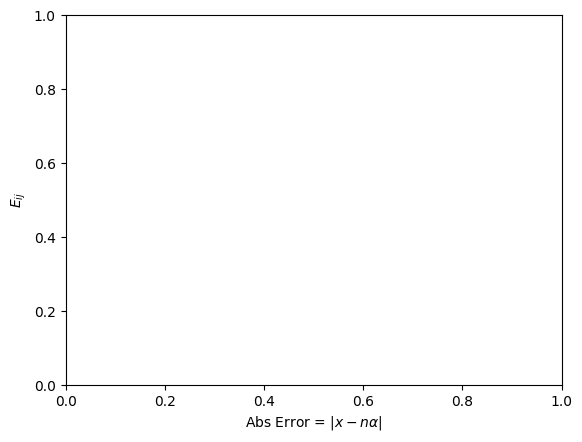

In [ ]:
import matplotlib.pyplot as plt
#col_label = r"$\frac{|x - n\alpha|}{\alpha\, n} \times 100\%$"
col_label = r"Pct Error = $\frac{|x - n\alpha|}{\alpha\, n} \times 100\%$"
abs_error_col_name = r"Abs Error = $|x - n\alpha|$"
plt.xlabel("value/"+r'$\n_alpha$')
plt.xlabel(abs_error_col_name)
plt.ylabel(r'$E_{ij}$')
#plt.show()

In [ ]:
import matplotlib.colors as mcolors

# Get a dictionary of CSS4 color names and their corresponding RGB values
css4_colors = mcolors.CSS4_COLORS

# Print the color names
for name in css4_colors:
    print(name)

aliceblue
antiquewhite
aqua
aquamarine
azure
beige
bisque
black
blanchedalmond
blue
blueviolet
brown
burlywood
cadetblue
chartreuse
chocolate
coral
cornflowerblue
cornsilk
crimson
cyan
darkblue
darkcyan
darkgoldenrod
darkgray
darkgreen
darkgrey
darkkhaki
darkmagenta
darkolivegreen
darkorange
darkorchid
darkred
darksalmon
darkseagreen
darkslateblue
darkslategray
darkslategrey
darkturquoise
darkviolet
deeppink
deepskyblue
dimgray
dimgrey
dodgerblue
firebrick
floralwhite
forestgreen
fuchsia
gainsboro
ghostwhite
gold
goldenrod
gray
green
greenyellow
grey
honeydew
hotpink
indianred
indigo
ivory
khaki
lavender
lavenderblush
lawngreen
lemonchiffon
lightblue
lightcoral
lightcyan
lightgoldenrodyellow
lightgray
lightgreen
lightgrey
lightpink
lightsalmon
lightseagreen
lightskyblue
lightslategray
lightslategrey
lightsteelblue
lightyellow
lime
limegreen
linen
magenta
maroon
mediumaquamarine
mediumblue
mediumorchid
mediumpurple
mediumseagreen
mediumslateblue
mediumspringgreen
mediumturquoise
mediumv

# Plotting Functions

In [ ]:
#Formatting Variables
# Define the fine structure constant (alpha ≈ 1/137.035999084)
alpha = 1 / 137.035999084

light_cone_mask_figsize = (24, 10) #(w,h) 20,9
heatmaps_figsize = (24, 10)
ex2_heatmaps_figsize = (14,11)
diff_heatmap_figsize = (10,8)
stats_table_figsize = (10,5)
spectrum_plot_figsize = (10,5)
spectrum_table_figsize = (18, 5)
table_font_size = 10
table_title_font_size = 10
tick_label_size = 10
pdf_dpi = 600

show_plot_ticks = False
plot_annotation_precision = 6
plot_annotation_font_size = 9
axis_label_font_size = 12
plot_title_font_size = 16
plot_colorbar_shrink = 0.5
plot_colorbar_aspect = 10

plot_probability_heatmap_font_color_threshold = 0.03
plot_probability_heatmap_over_font_color = "black" #over threshold font color
plot_probability_heatmap_under_font_color = "black" #unde_threshold_font_color

plot_masked_probability_heatmap_font_color_threshold = 0.04
plot_masked_probability_heatmap_over_font_color = "black" #over threshold font color
plot_masked_probability_heatmap_under_font_color = "white" #under_threshold_font_color

plot_outside_masked_probability_heatmap_font_color_threshold = 0.02
plot_outside_masked_probability_heatmap_over_font_color = "black" #over threshold font color
plot_outside_masked_probability_heatmap_under_font_color = "white" #under_threshold_font_color

plot_contribution_heatmap_font_color_threshold = 0.2
plot_contribution_heatmap_over_font_color = "white" #over threshold font color
plot_contribution_heatmap_under_font_color = "black" #under_threshold_font_color

plot_probability_diff_heatmap_font_color_threshold = 0.0
plot_probability_diff_heatmap_over_font_color = "white" #over threshold font color
plot_probability_diff_heatmap_under_font_color = "white" #under_threshold_font_color


def plot_light_cone(ax, light_cone_mask, center_i, center_j, observer_type='inertial', title="Light Cone Mask"):
    """
    Plots the light cone mask on a given Axes object with faint grid lines.

    Parameters:
    - ax (matplotlib.axes.Axes): The Axes object to plot on.
    - light_cone_mask (ndarray): Binary mask indicating light cone nodes.
    - center_i (int): Row index of the center node.
    - center_j (int): Column index of the center node.
    - observer_type (str): Type of observer ('inertial' or 'accelerating').
    - title (str): Title of the heatmap.
    """
    im = ax.imshow(light_cone_mask, cmap='Greys', origin='lower', interpolation='nearest', alpha=0.7)

    # Highlight the center node
    ax.scatter(center_j, center_i, color='lightgreen', marker='o', s=200, label='Present Event Node')

    # Highlight the future node
    future_i, future_j = calc_future_node(center_i, center_j, observer_type)

    ax.scatter(future_j, future_i, color='lightblue', marker='o', s=200, label='Future Event Node')

    # Add grid lines
    M, N = light_cone_mask.shape
    ax.set_xticks(np.arange(-0.5, N, 1))
    ax.set_yticks(np.arange(-0.5, M, 1))
    ax.grid(which='major', color='black', linestyle='-', linewidth=0.5, alpha=0.3)

    ax.set_title(title, fontsize = plot_title_font_size)
    ax.set_xlabel('Column Index (j)', fontsize=axis_label_font_size)
    ax.set_ylabel('Row Index (i)', fontsize=axis_label_font_size)
    ax.legend(loc='upper right', fontsize=axis_label_font_size)

    # Turn off tick labels
    ax.tick_params(axis='both', which='both', bottom=show_plot_ticks, top=show_plot_ticks, labelbottom=show_plot_ticks, left=show_plot_ticks, right=show_plot_ticks, labelleft=show_plot_ticks)
    # Invert y-axis to have i increase from bottom to top
    ax.invert_yaxis()


# === FUNCTION TO PLOT MASKS ===
def plot_mask(ax, mask, center_i, center_j, title="Mask"):
    """
    Plots a light cone mask on the given Axes object with faint grid lines.

    Parameters:
      - ax (matplotlib.axes.Axes): The Axes object to plot on.
      - mask (ndarray): Binary mask indicating light cone nodes.
      - center_i (int): Row index of the center (present) node.
      - center_j (int): Column index of the center (present) node.
      - title (str): Title of the plot.
    """
    ax.imshow(mask, cmap='Greys', origin='lower', interpolation='nearest', alpha=0.7)

    # Highlight the center (present) node in light green
    ax.scatter(center_j, center_i, color='lightgreen', marker='o', s=200, label='Present Node')

    # Add grid lines
    M, N = mask.shape
    ax.set_xticks(np.arange(-0.5, N, 1))
    ax.set_yticks(np.arange(-0.5, M, 1))
    ax.grid(which='major', color='black', linestyle='-', linewidth=0.5, alpha=0.3)

    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Column Index (j)', fontsize=12)
    ax.set_ylabel('Row Index (i)', fontsize=12)

    # Invert y-axis so row index increases from bottom to top
    ax.invert_yaxis()




def plot_probability_heatmap(ax, prob_grid, past_cone_mask=None, future_node_mask=None, center_i=None, center_j=None, observer_type='inertial', title="Bell Probability Heatmap"):
    """
    Plots the probability grid as a heatmap on a given Axes object with faint grid lines
    and highlights for past and future light cones, including the target node.

    Parameters:
    - ax (matplotlib.axes.Axes): The Axes object to plot on.
    - prob_grid (ndarray): The normalized probability grid.
    - past_cone_mask (ndarray, optional): Binary mask for the past light cone.
    - future_node_mask (ndarray, optional): Binary mask for the future node.
    - center_i (int, optional): Row index of the center node.
    - center_j (int, optional): Column index of the center node.
    - title (str): Title of the heatmap.
    """
    # Choose a colormap and set the color for zero probabilities
    cmap = plt.cm.viridis.copy()
    cmap.set_under(color='white')  # Color for zero probability

    # Mask the probability grid to handle zero probabilities
    masked_prob_grid = np.ma.masked_where(prob_grid == 0, prob_grid)

    # Plot the heatmap with proper masking
    im = ax.imshow(masked_prob_grid, cmap=cmap, origin='lower', interpolation='nearest', vmin=1e-10)

    # Add grid lines
    M, N = prob_grid.shape
    ax.set_xticks(np.arange(-0.5, N, 1))
    ax.set_yticks(np.arange(-0.5, M, 1))
    ax.grid(which='major', color='black', linestyle='-', linewidth=0.5, alpha=0.3)

    ax.set_title(title, fontsize = plot_title_font_size)
    ax.set_xlabel('Column Index (j)', fontsize=axis_label_font_size)
    ax.set_ylabel('Row Index (i)', fontsize=axis_label_font_size)

    # Add a colorbar
    cbar = ax.figure.colorbar(im, ax=ax, shrink=plot_colorbar_shrink, aspect=plot_colorbar_aspect)
    cbar.ax.set_ylabel('Probability', rotation=-90, va="bottom")

    # Add annotations
    for i in range(M):
        for j in range(N):
            if prob_grid[i, j] > 0:
                ax.text(j, i, f"{prob_grid[i, j]:.{plot_annotation_precision}f}",
                        ha='center', va='center',
                        color=plot_probability_heatmap_over_font_color if prob_grid[i, j] > plot_probability_heatmap_font_color_threshold else plot_probability_heatmap_under_font_color,
                        fontsize=plot_annotation_font_size)

    # Highlight Past Light Cone
    if past_cone_mask is not None:
        # Create a red transparent overlay for past light cone
        ax.imshow(past_cone_mask, cmap='Reds', alpha=0.3, origin='lower')

    # Highlight Future Light Cone
    #if future_node_mask is not None:
        # Create a blue transparent overlay for future node
        #ax.imshow(future_node_mask, cmap='Blues', alpha=0.5, origin='lower')

    # Highlight the target node with a green dot
    if center_i is not None and center_j is not None:
        ax.scatter(center_j, center_i, color='lightgreen', marker='o', s=200, label='Target Node')
        # Optionally, add to legend
        handles, labels = ax.get_legend_handles_labels()
        if 'Target Node' not in labels:
            ax.legend(loc='upper right')

    # Highlight the future node
    future_i, future_j = calc_future_node(center_i, center_j, observer_type)
    ax.scatter(future_j, future_i, color='lightblue', marker='o', s=200, label='Future Event Node')

    # Turn off tick labels
    ax.tick_params(axis='both', which='both', bottom=show_plot_ticks, top=show_plot_ticks, labelbottom=show_plot_ticks, left=show_plot_ticks, right=show_plot_ticks, labelleft=show_plot_ticks)
    # Invert y-axis to have i increase from bottom to top
    ax.invert_yaxis()


def plot_masked_probability_heatmap(ax, prob_grid, past_cone_mask, future_node_mask=None,
                                    center_i=None, center_j=None,  observer_type='inertial', title="Masked Probability Heatmap"):
    """
    Plots a heatmap of the probability grid but only displays cells where the combined mask is active.
    The combined mask is the logical OR of past_cone_mask and future_node_mask.
    Optionally marks the target node.

    Parameters:
    - ax (matplotlib.axes.Axes): The Axes object to plot on.
    - prob_grid (ndarray): The normalized probability grid.
    - past_cone_mask (ndarray): Binary mask for cells inside the past light cone.
    - future_node_mask (ndarray, optional): Binary mask for the future node.
    - center_i (int, optional): Row index of the target node.
    - center_j (int, optional): Column index of the target node.
    - title (str): Title for the heatmap.
    """
    # Combine past_cone_mask and future_node_mask using logical OR.
    if future_node_mask is not None:
        combined_mask = np.logical_or(past_cone_mask, future_node_mask)
    else:
        combined_mask = past_cone_mask

    # Create a masked array: keep values inside the combined mask, mask out the rest.
    masked_prob_grid = np.ma.masked_where(combined_mask == 0, prob_grid)

    # Choose a colormap and set masked (outside mask) values to appear white.
    cmap = plt.cm.viridis.copy()
    cmap.set_bad(color='white')

    # Plot the masked heatmap.
    im = ax.imshow(masked_prob_grid, cmap=cmap, origin='lower', interpolation='nearest')

    # Set titles and labels.
    ax.set_title(title, fontsize = plot_title_font_size)
    ax.set_xlabel('Column Index (j)', fontsize=axis_label_font_size)
    ax.set_ylabel('Row Index (i)', fontsize=axis_label_font_size)

    # Add grid lines.
    M, N = prob_grid.shape
    ax.set_xticks(np.arange(-0.5, N, 1))
    ax.set_yticks(np.arange(-0.5, M, 1))
    ax.grid(which='major', color='black', linestyle='-', linewidth=0.5, alpha=0.3)

    # Optionally mark the target node with a green dot.
    if center_i is not None and center_j is not None:
        ax.scatter(center_j, center_i, color='lightgreen', marker='o', s=200, label='Target Node')
        handles, labels = ax.get_legend_handles_labels()
        if 'Target Node' not in labels:
            ax.legend(loc='upper right')

    # Highlight the future node
    future_i, future_j = calc_future_node(center_i, center_j, observer_type)
    ax.scatter(future_j, future_i, color='lightblue', marker='o', s=200, label='Future Event Node')

    # Add a colorbar.
    cbar = ax.figure.colorbar(im, ax=ax, shrink=plot_colorbar_shrink, aspect=plot_colorbar_aspect)
    cbar.ax.set_ylabel('Probability', rotation=-90, va="bottom")

    # Add annotations for cells with non-zero probability.
    for i in range(M):
        for j in range(N):
            # Only annotate cells that are not masked and have a value > 0.
            if not np.ma.is_masked(masked_prob_grid[i, j]) and masked_prob_grid[i, j] > 0:
                ax.text(j, i, f"{masked_prob_grid[i, j]:.{plot_annotation_precision}f}",
                        ha='center', va='center',
                        color=plot_masked_probability_heatmap_under_font_color if masked_prob_grid[i, j] < plot_masked_probability_heatmap_font_color_threshold else plot_masked_probability_heatmap_over_font_color,
                        fontsize=plot_annotation_font_size)
    # Turn off tick labels
    ax.tick_params(axis='both', which='both', bottom=show_plot_ticks, top=show_plot_ticks, labelbottom=show_plot_ticks, left=show_plot_ticks, right=show_plot_ticks, labelleft=show_plot_ticks)
    # Invert y-axis so that row index increases from bottom to top.
    ax.invert_yaxis()

def plot_outside_mask_probability_heatmap(ax, prob_grid, past_cone_mask, future_node_mask=None,
                                          center_i=None, center_j=None, observer_type='inertial', title="Outside Mask Probability Heatmap"):
    """
    Plots a heatmap of the probability grid but only displays cells where the combined mask is NOT active.
    The combined mask is the logical OR of past_cone_mask and future_node_mask.
    Optionally marks the target node.

    Parameters:
    - ax (matplotlib.axes.Axes): The Axes object to plot on.
    - prob_grid (ndarray): The normalized probability grid.
    - past_cone_mask (ndarray): Binary mask for cells inside the past light cone.
    - future_node_mask (ndarray, optional): Binary mask for the future node.
    - center_i (int, optional): Row index of the target node.
    - center_j (int, optional): Column index of the target node.
    - title (str): Title for the heatmap.
    """
    # Combine past_cone_mask and future_node_mask using logical OR.
    if future_node_mask is not None:
        combined_mask = np.logical_or(past_cone_mask, future_node_mask)
    else:
        combined_mask = past_cone_mask

    # Create a masked array: mask out values inside the combined mask (i.e. where combined_mask == 1),
    # so that only values outside the mask are displayed.
    masked_prob_grid = np.ma.masked_where(combined_mask == 1, prob_grid)

    # Choose a colormap and set masked (inside mask) values to appear white.
    cmap = plt.cm.viridis.copy()
    cmap.set_bad(color='white')

    # Plot the masked heatmap.
    im = ax.imshow(masked_prob_grid, cmap=cmap, origin='lower', interpolation='nearest')

    # Set titles and labels.
    ax.set_title(title, fontsize = plot_title_font_size)
    ax.set_xlabel('Column Index (j)', fontsize=axis_label_font_size)
    ax.set_ylabel('Row Index (i)', fontsize=axis_label_font_size)

    # Add grid lines.
    M, N = prob_grid.shape
    ax.set_xticks(np.arange(-0.5, N, 1))
    ax.set_yticks(np.arange(-0.5, M, 1))
    ax.grid(which='major', color='black', linestyle='-', linewidth=0.5, alpha=0.3)

    # Optionally mark the target node with a green dot.
    if center_i is not None and center_j is not None:
        ax.scatter(center_j, center_i, color='lightgreen', marker='o', s=200, label='Target Node')
        handles, labels = ax.get_legend_handles_labels()
        if 'Target Node' not in labels:
            ax.legend(loc='upper right')

    # Highlight the future node
    future_i, future_j = calc_future_node(center_i, center_j, observer_type)
    ax.scatter(future_j, future_i, color='lightblue', marker='o', s=200, label='Future Event Node')

    # Add a colorbar.
    cbar = ax.figure.colorbar(im, ax=ax, shrink=plot_colorbar_shrink, aspect=plot_colorbar_aspect)
    cbar.ax.set_ylabel('Probability', rotation=-90, va="bottom")

    # Add annotations for cells with non-zero probability (outside the mask).
    for i in range(M):
        for j in range(N):
            # Only annotate cells that are not masked and have a value > 0.
            if not np.ma.is_masked(masked_prob_grid[i, j]) and masked_prob_grid[i, j] > 0:
                ax.text(j, i, f"{masked_prob_grid[i, j]:.{plot_annotation_precision}f}",
                        ha='center', va='center',
                        color=plot_outside_masked_probability_heatmap_under_font_color if masked_prob_grid[i, j] < plot_outside_masked_probability_heatmap_font_color_threshold else plot_outside_masked_probability_heatmap_over_font_color,
                        fontsize=plot_annotation_font_size)
    # Turn off tick labels
    ax.tick_params(axis='both', which='both', bottom=show_plot_ticks, top=show_plot_ticks, labelbottom=show_plot_ticks, left=show_plot_ticks, right=show_plot_ticks, labelleft=show_plot_ticks)
    # Invert y-axis so that row index increases from bottom to top.
    ax.invert_yaxis()


def plot_probability_difference_heatmap(ax, prob_grid1, prob_grid2, center_i, center_j, title="Bell Probability Difference Heatmap (Inertial - Accelerating)"):
    """
    Plots the difference between two probability grids as a heatmap on a given Axes object with faint grid lines.

    Parameters:
    - ax (matplotlib.axes.Axes): The Axes object to plot on.
    - prob_grid1 (ndarray): Probability grid for the first observer type (Inertial).
    - prob_grid2 (ndarray): Probability grid for the second observer type (Accelerating).
    - title (str): Title of the heatmap.
    """
    # Compute the difference
    #prob_diff = prob_grid1 - prob_grid2
    prob_diff = prob_grid2 - prob_grid1

    # Choose a diverging colormap for positive and negative differences
    cmap = plt.cm.seismic.copy()
    cmap.set_under(color='white')  # Color for zero probability difference

    # Determine the maximum absolute difference for symmetric color scaling
    max_diff = np.max(np.abs(prob_diff))

    # Plot the difference heatmap
    im = ax.imshow(prob_diff, cmap=cmap, origin='lower', interpolation='nearest',
                  vmin=-max_diff, vmax=max_diff)

    # Add grid lines
    M, N = prob_diff.shape
    ax.set_xticks(np.arange(-0.5, N, 1))
    ax.set_yticks(np.arange(-0.5, M, 1))
    ax.grid(which='major', color='black', linestyle='-', linewidth=0.5, alpha=0.3)

    ax.set_title(title, fontsize = plot_title_font_size)
    ax.set_xlabel('Column Index (j)', fontsize=axis_label_font_size)
    ax.set_ylabel('Row Index (i)', fontsize=axis_label_font_size)

    # Add a colorbar
    cbar = ax.figure.colorbar(im, ax=ax, shrink=plot_colorbar_shrink, aspect=plot_colorbar_aspect)
    cbar.ax.set_ylabel('Probability Difference (Accelerating - Inertial)', rotation=-90, va="bottom")

    # Optionally mark the target node with a green dot.
    if center_i is not None and center_j is not None:
        ax.scatter(center_j, center_i, color='lightgreen', marker='o', s=200, label='Target Node')
        handles, labels = ax.get_legend_handles_labels()
        if 'Target Node' not in labels:
            ax.legend(loc='upper right')

    # Highlight the two future nodes
    inertial_future_i, inertial_future_j = calc_future_node(center_i, center_j, "inertial")
    accelerated_future_i, accelerated_future_j = calc_future_node(center_i, center_j, "accelerating")

    ax.scatter(inertial_future_j, inertial_future_i, color='lightblue', marker='o', s=200, label='Inertial Future Event Node')
    ax.scatter(accelerated_future_j, accelerated_future_i, color='lightblue', marker='o', s=200, label='Accelerated Future Event Node')


    # annotation loop to prevent cluttering
    for i in range(M):
        for j in range(N):
             if prob_diff[i, j] != 0:
                 # Format differences in scientific notation with high precision
                 ax.text(j, i, f"{prob_diff[i, j]:.{plot_annotation_precision}f}",
                         ha='center', va='center',
                         color=plot_probability_diff_heatmap_over_font_color if prob_diff[i, j] > plot_probability_diff_heatmap_font_color_threshold else plot_probability_diff_heatmap_under_font_color,
                         fontsize=plot_annotation_font_size)

    # Turn off tick labels
    ax.tick_params(axis='both', which='both', bottom=show_plot_ticks, top=show_plot_ticks, labelbottom=show_plot_ticks, left=show_plot_ticks, right=show_plot_ticks, labelleft=show_plot_ticks)
    # Invert y-axis to have i increase from bottom to top
    ax.invert_yaxis()


def plot_causal_contributions_heatmap(ax, contribution_mask, center_i, center_j, observer_type='inertial', title="Causal Contributions Heatmap"):
    """
    Plots the causal contribution heatmap showing which past nodes contribute to the probability of the new event.

    Parameters:
    - ax (matplotlib.axes.Axes): The Axes object to plot on.
    - contribution_mask (ndarray): Contribution mask from `compute_causal_contributions_from_prob_grid`.
    - center_i (int): Row index of the center node.
    - center_j (int): Column index of the center node.
    - observer_type (str): Observer type ('inertial' or 'accelerating').
    - title (str): Title for the heatmap.
    """
    # Choose a colormap
    cmap = plt.cm.Reds.copy()
    cmap.set_under(color='white')  # Color for zero contributions

    # Mask the grid to handle zero contributions
    masked_contributions = np.ma.masked_where(contribution_mask == 0, contribution_mask)

    # Plot the heatmap
    im = ax.imshow(masked_contributions, cmap=cmap, origin='lower', interpolation='nearest', vmin=1e-10)

    # Add grid lines
    M, N = contribution_mask.shape
    ax.set_xticks(np.arange(-0.5, N, 1))
    ax.set_yticks(np.arange(-0.5, M, 1))
    ax.grid(which='major', color='black', linestyle='-', linewidth=0.5, alpha=0.3)

    ax.set_title(title, fontsize = plot_title_font_size)
    ax.set_xlabel('Column Index (j)', fontsize=axis_label_font_size)
    ax.set_ylabel('Row Index (i)', fontsize=axis_label_font_size)

    # Add a colorbar
    cbar = ax.figure.colorbar(im, ax=ax, shrink=plot_colorbar_shrink, aspect=plot_colorbar_aspect)
    cbar.ax.set_ylabel('Causal Contribution', rotation=-90, va="bottom")

    # Add annotations for contributions
    for i in range(M):
        for j in range(N):
            if contribution_mask[i, j] > 0:
                ax.text(j, i, f"{contribution_mask[i, j]:.{plot_annotation_precision}f}",
                        ha='center', va='center',
                        color=plot_contribution_heatmap_under_font_color if contribution_mask[i, j] < plot_contribution_heatmap_font_color_threshold else plot_contribution_heatmap_over_font_color,
                        fontsize=plot_annotation_font_size)

    # Highlight the future event node
    future_i, future_j = calc_future_node(center_i, center_j, observer_type)
    ax.scatter(future_j, future_i, color='lightblue', marker='o', s=200, label='Future Event Node')

    # Optionally mark the target node with a green dot.
    if center_i is not None and center_j is not None:
        ax.scatter(center_j, center_i, color='lightgreen', marker='o', s=200, label='Target Node')
        handles, labels = ax.get_legend_handles_labels()
        if 'Target Node' not in labels:
            ax.legend(loc='upper right')

    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    if 'Future Event Node' not in labels:
        ax.legend(loc='upper right')

    # Turn off tick labels
    ax.tick_params(axis='both', which='both', bottom=show_plot_ticks, top=show_plot_ticks, labelbottom=show_plot_ticks, left=show_plot_ticks, right=show_plot_ticks, labelleft=show_plot_ticks)
    # Invert y-axis to have i increase from bottom to top
    ax.invert_yaxis()


def verify_probabilities(prob_grid, light_cone_mask, observer_type):
    """
    Computes statistics of probabilities outside or inside the light cone.

    Parameters:
    - prob_grid (ndarray): The normalized probability grid.
    - light_cone_mask (ndarray): Binary mask indicating light cone nodes.
    - observer_type (str): Type of observer ('inertial' or 'accelerating').

    Returns:
    - stats (dict): Dictionary containing min, max, and total probabilities.
    """
    # Probabilities outside the light cone
    outside_probs = prob_grid[light_cone_mask == 0]
    min_prob_outside = outside_probs.min() if outside_probs.size > 0 else 0.0
    max_prob_outside = outside_probs.max() if outside_probs.size > 0 else 0.0
    total_prob_outside = outside_probs.sum() if outside_probs.size > 0 else 0.0

    # Probabilities inside the light cone
    inside_probs = prob_grid[light_cone_mask == 1]
    min_prob_inside = inside_probs.min() if inside_probs.size > 0 else 0.0
    max_prob_inside = inside_probs.max() if inside_probs.size > 0 else 0.0
    total_prob_inside = inside_probs.sum() if inside_probs.size > 0 else 0.0

    stats = {
        "Outside": {
            "Min Prob": min_prob_outside,
            "Max Prob": max_prob_outside,
            "Total Prob": total_prob_outside
        },
        "Inside": {
            "Min Prob": min_prob_inside,
            "Max Prob": max_prob_inside,
            "Total Prob": total_prob_inside
        }
    }
    return stats


def generate_comparison_table_from_stats(stats_table, caption, label):
    """
    Generates LaTeX code for a table comparing two observers from an input stats_table.

    Parameters:
    - stats_table (dict): A dictionary with keys "Inertial" and "Accelerating", where each value is a dictionary
      with keys "Min Prob", "Max Prob", and "Total Prob".
    - caption (str): The caption for the table.
    - label (str): The label for the table.

    Returns:
    - table_latex (str): A string containing the LaTeX code for the table.
    """
    # Define the rows we want: each is a tuple of (metric row label, dictionary key)
    rows = [("Min Prob", "Min Prob"),
            ("Max Prob", "Max Prob"),
            ("Total", "Total Prob")]

    # Build the header of the table.
    table_latex = r"""\begin{table}[htbp]
\centering
\caption{%s}
\label{%s}
\begin{tabular}{lrrr}
\toprule
Metric & Inertial Observer & Accelerating Observer & $O_a - O_i$ \\
\midrule
""" % (caption, label)

    # For each row, retrieve the corresponding values and compute the difference.
    for row_label, key in rows:
        inertial_value = stats_table["Inertial"].get(key, 0)
        accelerating_value = stats_table["Accelerating"].get(key, 0)
        diff = accelerating_value - inertial_value
        table_latex += "{} & {:.5g} & {:.5g} & {:.5g} \\\\ \n".format(row_label, inertial_value, accelerating_value, diff)

    table_latex += r"\bottomrule" + "\n" + r"\end{tabular}" + "\n" + r"\end{table}"
    return table_latex

    # Prepare data for the inside statistics table
    table_data_inside = []
    for metric in metrics:
        inertial = stats_table_inside["Inertial"][metric]
        accelerating = stats_table_inside["Accelerating"][metric]
        difference = accelerating - inertial
        table_data_inside.append([metric, f"{inertial:.6e}", f"{accelerating:.6e}", f"{difference:.6e}"])

    # Plot the outside statistics table
    table_outside = ax_outside.table(cellText=table_data_outside,
                                     colLabels=column_labels,
                                     loc='center',
                                     cellLoc='center',
                                     bbox=[0, 0, 1, 1])  # Adjust bbox if needed
    table_outside.auto_set_font_size(False)
    table_outside.set_fontsize(table_font_size)  # Adjust font size as needed
    table_outside.scale(1, 1.2)      # Adjust scale as needed

    ax_outside.set_title(title_outside, fontweight='bold', fontsize=table_title_font_size)  # Adjust font size as needed
    ax_outside.axis('off')

    # Plot the inside statistics table
    table_inside = ax_inside.table(cellText=table_data_inside,
                                   colLabels=column_labels,
                                   loc='center',
                                   cellLoc='center',
                                   bbox=[0, 0, 1, 1])  # Adjust bbox if needed
    table_inside.auto_set_font_size(False)
    table_inside.set_fontsize(table_font_size)  # Adjust font size as needed
    table_inside.scale(1, 1.2)      # Adjust scale as needed

    ax_inside.set_title(title_inside, fontweight='bold', fontsize=table_title_font_size)  # Adjust font size as needed
    ax_inside.axis('off')



def plot_spectrum(ax, grids, title):
    """
    Plots a histogram spectrum of adjusted non-zero grid values on the provided Axes.

    The function extracts non-zero values from the list of grids, divides them by the
    fine structure constant, and then plots a histogram.

    Parameters:
    - ax (matplotlib.axes.Axes): The Axes object on which to plot the histogram.
    - grids (iterable of ndarray): Iterable of numpy arrays representing probability grids.
    """
    # Define the fine structure constant (alpha ≈ 1/137.035999084)
    alpha = 1 / 137.035999084

    # Collect non-zero values from all grids
    values = []
    for grid in grids:
        values.extend(grid[grid != 0])

    if not values:
        raise ValueError("No non-zero values found in the provided grids.")

    values = np.array(values)
    # Adjust values by dividing by alpha
    adjusted_values = values / alpha

    # Plot the histogram on the provided Axes
    ax.hist(adjusted_values, bins=50, color='skyblue', edgecolor='black', alpha=0.75)
    ax.set_title(title, fontsize=plot_title_font_size)
    ax.set_xlabel('Value / '+r'$\alpha$', fontsize=axis_label_font_size)
    ax.set_ylabel('Frequency', fontsize=axis_label_font_size)
    ax.grid(True)
    # Set tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=tick_label_size)
    ml = ticker.MultipleLocator(base=1)  # Set tick increment to 2
    ax.xaxis.set_major_locator(ml)       # Apply to x-axis

    xticks = ax.get_xticks()  # Get the x-tick locations
    xlabels = [str(int(x)) for x in xticks]  # Create labels
    ax.set_xticklabels(xlabels)  # Set the labels


def tabulate_spectrum(grids):
    # Collect non-zero values from all grids
    values = []
    for grid in grids:
        values.extend(grid[grid != 0])

    if not values:
        raise ValueError("No non-zero values found in the provided grids.")

    values = np.array(values)
    # Adjust values by dividing by alpha
    adjusted_values = values / alpha

    # Collect data for the table
    unique_values, counts = np.unique(values, return_counts=True)
    data = []

    for value, count in zip(unique_values, counts):
        n_alpha = value / alpha
        nearest_n = int(round(n_alpha))
        error = value - nearest_n * alpha
        error_alpha = error / alpha
        pct_error = abs(error / (alpha * nearest_n)) * 100  # Calculate percentage error

        data.append([value, count, n_alpha, nearest_n, error, error_alpha, pct_error])
    return data

# For use in tables and LaTex
n_alpha_col_name = 'Value/'+r'$\alpha$'
abs_error_col_name = r"Abs Error = $|x - n\alpha|$"
norm_error_col_name ='abs_error/'+r'$\alpha$'
#pct_error_col_name = 'abs_error/'+r'$\n_alpha$'
pct_error_col_name =r"Pct Error = $\frac{|x - n\alpha|}{n\alpha} \times 100\%$"


def turn_spectrum_data_into_LaTex(data):
    # Create a DataFrame from your data
    columns = ['Value', 'Count', n_alpha_col_name, 'nearest_n', abs_error_col_name, norm_error_col_name , pct_error_col_name]
    df = pd.DataFrame(data, columns=columns)

    formatters = {
    'Value': '{:.6e}'.format,        # Two decimal places for Value
    n_alpha_col_name: '{:.6e}'.format,       # One decimal places for n_alpha
    abs_error_col_name: '{:.6e}'.format,         # Three decimal places for error
    norm_error_col_name: '{:.6e}'.format,   # Three decimal places for error_alpha
    pct_error_col_name: '{:.2f}\\%'.format   # One decimal place and add percent sign
    }

    latex_table = df.to_latex(index=False, formatters=formatters)
    print(latex_table)


def dispaly_spectrum_table(ax, data, title):
    # Add this check to handle empty cellText
    if not data:
        print("Warning: No data to tabulate. The table will be empty.")
        return  # Exit the function early to avoid the error

    # Format data for the table with precision and scientific notation
    formatted_data = []
    for row in data:
        formatted_row = [
            f"{row[0]:.6e}",  # grid_value in scientific notation with 6 decimal places
            f"{row[1]}",      # number_of_samples (integer, no formatting needed)
            f"{row[2]:.6e}",  # Value/alpha with 6 decimal places
            f"{row[3]}",      # nearest_n (integer, no formatting needed)
            f"{row[4]:.6e}",  # error in scientif notation with 6 decimal places
            f"{row[5]:.6e}",  # error_in_alphas in scientific notation with 6 decimal places
            f"{row[6]:.2f}%"  # pct_error as percentage with 2 decimal places
        ]
        formatted_data.append(formatted_row)

    # Create and display the table using formatted_data
    column_labels = ["grid_value", "number_of_samples", n_alpha_col_name , "nearest_n", abs_error_col_name, norm_error_col_name, pct_error_col_name]
    table = ax.table(cellText=formatted_data, colLabels=column_labels, loc='center', cellLoc='center', bbox=[0, 0, 1, 1])
    # ... (Rest of the table formatting code remains the same) ...

    table.auto_set_font_size(False)
    table.set_fontsize(table_font_size)
    table.scale(1, 1.2)  # Adjust scale as needed

    ax.set_title(title, fontweight='bold', fontsize=table_title_font_size)  # Adjust font size as needed
    ax.axis('off')





def visualize_probability_surface(prob_grid, center_i, center_j,
                                  future_i, future_j,
                                  x_start=None, x_end=None,
                                  y_start=None, y_end=None,
                                  event_threshold=0.0001,
                                  offset=0.05,
                                  invert_surface=False,
                                  norm_to_alpha=False,
                                  aspectratio=dict(x=1.5, y=1, z=0.85),
                                  show_event_labels=True,
                                  surface_opacity=0.8,
                                  show_center_lines=True,
                                  plot_title="3D Probability Surface"):
    """
    Visualize a probability grid as a 3D surface with event markers.
    Also plots:
      - A blue marker for the future node (at future_i, future_j)
      - A green marker for the current node (the center node, at center_i, center_j)
      - Optionally, two traces (lines) crossing through the center node
        along the x and y axes on the surface.

    Parameters:
      - prob_grid: 2D numpy array of probability values.
      - center_i, center_j: Center indices for x,y axis conversion.
      - future_i, future_j: Grid indices for the future node.
      - x_start, x_end: Column indices to slice the grid for ROI. If None, uses full range.
      - y_start, y_end: Row indices to slice the grid for ROI. If None, uses full range.
      - event_threshold: Minimum absolute probability value to mark an event.
      - offset: Vertical offset for label placement.
      - invert_surface: Whether the surface has been inverted.
      - aspectratio: Dict controlling the scene aspect ratio.
      - show_event_labels: If True, event labels are shown with the markers.
      - surface_opacity: Opacity of the surface.
      - show_center_lines: If True, adds two lines (x and y) intersecting the center node.
      - plot_title: Title of the plot.
    """

    if invert_surface:
        prob_grid = -prob_grid

    # Optionally normalize (commented out by default)
    if norm_to_alpha:
        prob_grid = prob_grid / alpha

    M, N = prob_grid.shape
    #Define full x and y arrays relative to the grid center
    full_x = np.arange(-center_j, N - center_j)
    full_y = np.arange(-center_i, M - center_i)

    # Use full grid if ROI indices are not provided
    if x_start is None or x_end is None:
        x_start, x_end = 0, N
    if y_start is None or y_end is None:
        y_start, y_end = 0, M

    # Slice the grid and axis arrays for the ROI
    zoomed_prob_grid = prob_grid[y_start:y_end, x_start:x_end]
    x_values = full_x[x_start:x_end]
    y_values = full_y[y_start:y_end]

    # === COLLECT EVENT POINTS ===
    black_events = {"x": [], "y": [], "z": [], "labels": []}
    white_events = {"x": [], "y": [], "z": [], "labels": []}

    for i in range(M):
        for j in range(N):
            prob_value = prob_grid[i, j]
            if abs(prob_value) > abs(event_threshold):
                x_val = j - center_j
                y_val = i - center_i
                adjusted_z = prob_value
                label_z = adjusted_z + offset
                label = f"{label_z:.4f}"
                if invert_surface:
                    if prob_value > 0.5 * np.min(prob_grid):
                        black_events["x"].append(x_val)
                        black_events["y"].append(y_val)
                        black_events["z"].append(adjusted_z)
                        black_events["labels"].append(label)
                    else:
                        white_events["x"].append(x_val)
                        white_events["y"].append(y_val)
                        white_events["z"].append(adjusted_z)
                        white_events["labels"].append(label)
                else:
                    if prob_value < 0.5 * np.max(prob_grid):
                        white_events["x"].append(x_val)
                        white_events["y"].append(y_val)
                        white_events["z"].append(adjusted_z)
                        white_events["labels"].append(label)
                    else:
                        black_events["x"].append(x_val)
                        black_events["y"].append(y_val)
                        black_events["z"].append(adjusted_z)
                        black_events["labels"].append(label)

    # === FILTER EVENTS TO THE ZOOMED ROI ===
    x_min, x_max = x_values[0], x_values[-1]
    y_min, y_max = y_values[0], y_values[-1]

    def in_zoom(x, y, x_min, x_max, y_min, y_max):
        return (x >= x_min) and (x <= x_max) and (y >= y_min) and (y <= y_max)

    def filter_events(events):
        filtered = {"x": [], "y": [], "z": [], "labels": []}
        for x, y, z, label in zip(events["x"], events["y"], events["z"], events["labels"]):
            if in_zoom(x, y, x_min, x_max, y_min, y_max):
                filtered["x"].append(x)
                filtered["y"].append(y)
                filtered["z"].append(z)
                filtered["labels"].append(label)
        return filtered

    zoomed_black_events = filter_events(black_events)
    zoomed_white_events = filter_events(white_events)

    # === CREATE 3D PLOT ===
    fig = go.Figure()

    # Add the probability surface (zoomed)
    fig.add_trace(go.Surface(
        z=zoomed_prob_grid,
        x=x_values,
        y=y_values,
        colorscale='Viridis',
        opacity=surface_opacity
    ))

    mode = 'markers+text' if show_event_labels else 'markers'
    fig.add_trace(go.Scatter3d(
        x=zoomed_black_events["x"],
        y=zoomed_black_events["y"],
        z=zoomed_black_events["z"],
        mode=mode,
        marker=dict(size=2.5, color='red', opacity=0.85),
        text=zoomed_black_events["labels"] if show_event_labels else None,
        textposition="top center",
        textfont=dict(color="black")
    ))
    fig.add_trace(go.Scatter3d(
        x=zoomed_white_events["x"],
        y=zoomed_white_events["y"],
        z=zoomed_white_events["z"],
        mode=mode,
        marker=dict(size=2.5, color='red', opacity=0.85),
        text=zoomed_white_events["labels"] if show_event_labels else None,
        textposition="top center",
        textfont=dict(color="white")
    ))

    # --- Add markers for Future and Current Nodes ---
    if not invert_surface:
        #future_multiplier = 1.0
        #current_multiplier = 1.0
        future_multiplier = 1.15
        current_multiplier = 1.025
    else:
        future_multiplier = 1.0
        current_multiplier = 1.0
        #future_multiplier = 0.82
        #current_multiplier = 0.97


    # Future node marker (blue)
    x_future = future_j - center_j
    y_future = future_i - center_i
    z_future = prob_grid[future_i, future_j] * future_multiplier  # raised a bit above the surface
    fig.add_trace(go.Scatter3d(
        x=[x_future],
        y=[y_future],
        z=[z_future],
        mode='markers',
        marker=dict(size=8, color='lightblue'),
        name='Future Node'
    ))

    # Current node marker (green) at the center node
    x_current = 0  # center node is at 0 in x (relative coordinates)
    y_current = 0  # center node is at 0 in y
    z_current = prob_grid[center_i, center_j] * current_multiplier  # slightly raised
    fig.add_trace(go.Scatter3d(
        x=[x_current],
        y=[y_current],
        z=[z_current],
        mode='markers',
        marker=dict(size=8, color='lightgreen'),
        name='Current Node'
    ))

    # --- Optionally add center cross-section lines ---
    if show_center_lines:
        # Ensure the ROI includes the center (0,0)
        if x_values[0] <= 0 <= x_values[-1] and y_values[0] <= 0 <= y_values[-1]:
            # x-line: center row
            x_line = x_values
            y_line = [0] * len(x_line)
            # Extract the center row from the full grid using ROI slice
            z_line_x = prob_grid[center_i, x_start:x_end]
            fig.add_trace(go.Scatter3d(
                x=x_line,
                y=y_line,
                z=z_line_x,
                mode='lines',
                line=dict(color='turquoise', width=2),
                name='Center X-line'
            ))
            # y-line: center column
            y_line = y_values
            x_line = [0] * len(y_line)
            z_line_y = prob_grid[y_start:y_end, center_j]
            fig.add_trace(go.Scatter3d(
                x=x_line,
                y=y_line,
                z=z_line_y,
                mode='lines',
                line=dict(color='turquoise', width=2),
                name='Center Y-line'
            ))

    # === LAYOUT CUSTOMIZATION ===
    fig.update_layout(
        title=plot_title,
        width=1400,
        height=800,
        margin=dict(l=50, r=50, b=50, t=50),
        legend=dict(
            orientation="h",
            x=0.5,
            y=-0.1,
            xanchor="center"
        ),
        scene=dict(
            xaxis=dict(
                title="",
                showticklabels=False,
                backgroundcolor="rgba(200,200,230,0.5)",
                gridcolor="mediumslateblue",
                zerolinecolor="mediumslateblue",
                showbackground=False
            ),
            yaxis=dict(
                title="",
                showticklabels=False,
                backgroundcolor="rgba(230,200,230,0.5)",
                gridcolor="mediumslateblue",
                zerolinecolor="mediumslateblue",
                showbackground=False
            ),
            zaxis=dict(
                title="Probability",
                tickformat=".4f",
                titlefont=dict(color="mediumslateblue"),
                tickfont=dict(color="mediumslateblue"),
                color="mediumslateblue",
                tickcolor="mediumslateblue",
                backgroundcolor="rgba(230,230,200,0.5)",
                gridcolor="mediumslateblue",
                zerolinecolor="mediumslateblue",
                showbackground=False
            ),
            camera=dict(eye=dict(x=1.0, y=1.0, z=1.0)),
            aspectratio=aspectratio,
            bgcolor='rgb(39,29,71)'
        )
    )

    fig.show()


# TTO Kernel Studies


In [ ]:
# TTO DOE Functions

def display_tto_masks(tto_masks, center_i, center_j, cols=5):
    """
    Plots all TTO masks stored in the dictionary, arranging them in a grid with a fixed number of columns.

    Parameters:
    - tto_masks (dict): Dictionary containing masks, titles, and descriptions.
    - center_i (int): Row index of the center node.
    - center_j (int): Column index of the center node.
    - cols (int): Number of columns for layout (default: 5).
    """
    num_masks = len(tto_masks)
    rows = (num_masks + cols - 1) // cols  # Compute number of rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))

    # Ensure axes is always a 2D array for indexing consistency
    axes = np.array(axes).reshape(rows, cols)

    for ax, (title, data) in zip(axes.flatten(), tto_masks.items()):
        plot_mask(ax, data["mask"], center_i, center_j, title=title)

    # Hide any unused subplots
    for i in range(num_masks, rows * cols):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()


def display_kernel_shapes(kernel_shapes, cols=5):
    """
    Plots all kernel shapes stored in a list, arranging them in a grid with a fixed number of columns.

    Parameters:
    - kernel_shapes (list of ndarray): List of kernel matrices.
    - cols (int): Number of columns for layout (default: 5).
    """
    num_kernels = len(kernel_shapes)
    rows = (num_kernels + cols - 1) // cols  # Compute number of rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))

    # Ensure axes is always a 2D array for indexing consistency
    axes = np.array(axes).reshape(rows, cols)

    for ax, (i, kernel) in zip(axes.flatten(), enumerate(kernel_shapes)):
        ax.imshow(kernel, cmap='Blues', interpolation='nearest', origin='lower', alpha=0.8)

        ax.set_title(f"Kernel {i+1}\nShape: {kernel.shape}", fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)

    # Hide any unused subplots
    for i in range(num_kernels, rows * cols):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()


def run_tto_doe(kernel_shapes, plc_masks):
    """
    Runs a Design of Experiments (DOE) study over multiple TTO kernel shapes and PLC masks.

    Parameters:
    - kernel_shapes (list of ndarrays): Different kernel configurations to test.
    - plc_masks (dict): Dictionary containing PLC masks with metadata.

    Modifies:
    - plc_masks (dict): Stores the computed probability distributions inside each mask entry.
    """
    for k_shape in kernel_shapes:
        for mask_name, mask_data in plc_masks.items():
            #print(f"Testing Kernel: {k_shape.shape}, PLC Mask: {mask_name}")

            # Compute probability distribution
            prob_grid = compute_probability_grid(mask_data["mask"], k_shape)

            # Store results inside plc_masks dictionary
            plc_masks[mask_name][f"prob_grid_{k_shape.shape}"] = prob_grid

            # Optional: Visualize 3D probability surface
            #plot_3d_probability_surface(prob_grid, title=f"{mask_name} - Kernel {k_shape.shape}")

    return plc_masks  # Now contains probability grids inside








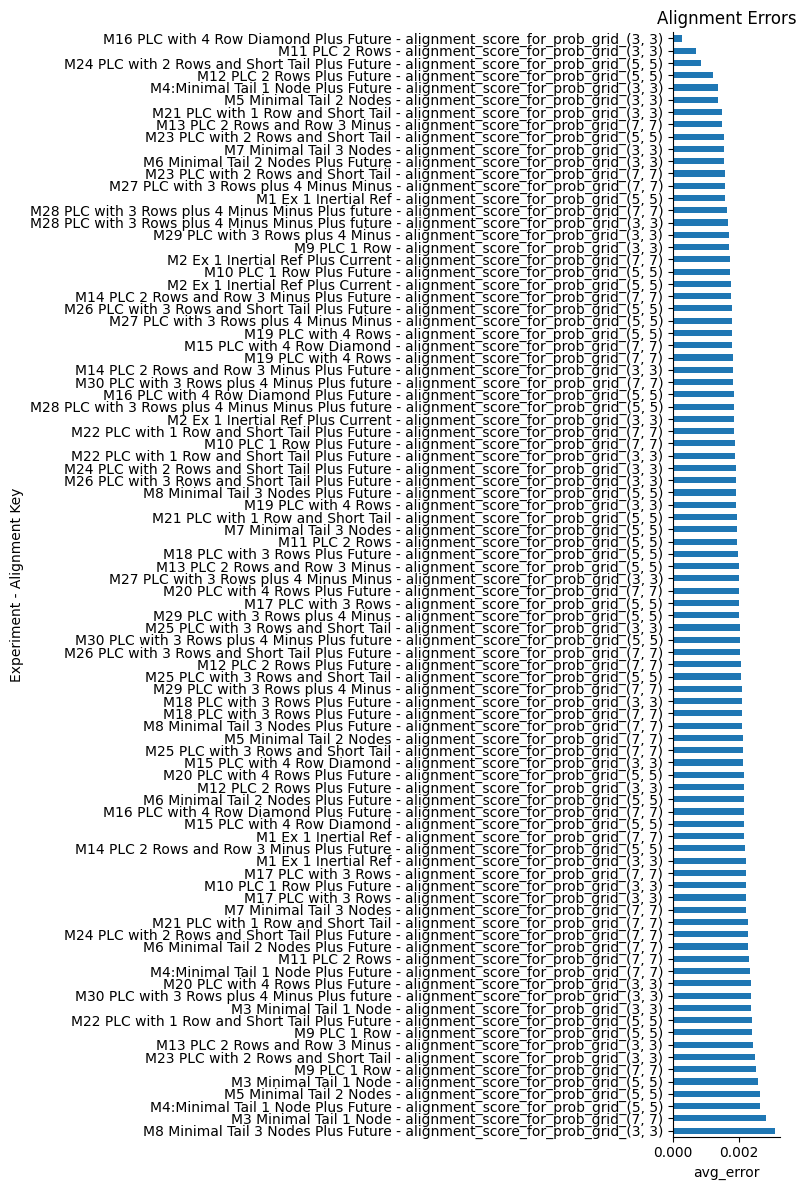

In [ ]:
# === GRID PARAMETERS ===
M, N = 10, 10  # Grid size (rows x columns)
center_i, center_j = M // 2, N // 2

# === LIGHT CONE COMPONENTS ===
current_node = [(0, 0)]
future_node = [(-1, 0)]
plc1 = [(1, -1), (1, 0), (1, 1)]
plc2_minus = [(2, -1), (2, 0), (2, 1)]
plc2 = [(2, -2), (2, -1), (2, 0), (2, 1), (2, 2)]
plc3 = [(3, -3), (3, -2), (3, -1), (3, 0), (3, 1), (3, 2), (3, 3)]
plc3_minus = [(3, -1), (3, 0), (3, 1)]
plc4 = [(4, -4), (4, -3), (4, -2), (4, -1), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]
plc4_minus = [(4, -2), (4, -1), (4, 0), (4, 1), (4, 2)]
plc4_minus_minus = [(4, -1), (4, 0), (4, 1)]

plc1_tail = [(1, 0)]
plc2_tail = [(1, 0), (2, 0)]
plc3_tail = [(1, 0), (2, 0), (3, 0)]
plc4_tail = [(1, 0), (2, 0), (3, 0), (4, 0)]
plc5_tail = [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0)]


tto_kernel_experiments = {}

# === DICTIONARY OF MASKS ===
tto_kernel_experiments = {
    "M1 Ex 1 Inertial Ref": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, future_node + plc1_tail + plc2_minus + plc3_minus + plc4_minus),
        "description": "M1 Ex 1 Inertial Ref",
        "center_i": center_i,
        "center_j": center_j
    },
    "M2 Ex 1 Inertial Ref Plus Current": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, future_node + current_node + plc1_tail + plc2_minus + plc3_minus + plc4_minus),
        "description": "M2 Ex 1 Inertial Ref Plus Current",
        "center_i": center_i,
        "center_j": center_j
    },
    "M3 Minimal Tail 1 Node": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, current_node + plc1_tail),
        "description": "M3 Minimal Tail 1 Node",
        "center_i": center_i,
        "center_j": center_j
    },
    "M4:Minimal Tail 1 Node Plus Future": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, current_node + future_node + plc1_tail),
        "description": "M4 Minimal Tail 1 Node Plus Future",
        "center_i": center_i,
        "center_j": center_j
    },
    "M5 Minimal Tail 2 Nodes": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, current_node + plc2_tail),
        "description": "M5 Minimal Tail 2 Nodes",
        "center_i": center_i,
        "center_j": center_j
    },
    "M6 Minimal Tail 2 Nodes Plus Future": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, current_node + future_node + plc2_tail),
        "description": "M6 Minimal Tail 2 Nodes Plus Future",
        "center_i": center_i,
        "center_j": center_j
    },
    "M7 Minimal Tail 3 Nodes": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, current_node + plc3_tail),
        "description": "M7 Minimal Tail 3 Nodes",
        "center_i": center_i,
        "center_j": center_j
    },
    "M8 Minimal Tail 3 Nodes Plus Future": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, current_node + future_node + plc3_tail),
        "description": "M8 Minimal Tail 3 Nodes Plus Future",
        "center_i": center_i,
        "center_j": center_j
    },
    "M9 PLC 1 Row": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, current_node + plc1),
        "description": "M9 PLC 1 Row",
        "center_i": center_i,
        "center_j": center_j
    },
    "M10 PLC 1 Row Plus Future": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, current_node + future_node + plc1),
        "description": "M10 PLC 1 Row Plus Future",
        "center_i": center_i,
        "center_j": center_j
    },
    "M11 PLC 2 Rows": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, current_node + plc1 + plc2),
        "description": "M11 PLC 2 Rows",
        "center_i": center_i,
        "center_j": center_j
    },
    "M12 PLC 2 Rows Plus Future": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, current_node + future_node + plc1 + plc2),
        "description": "M12 PLC 2 Rows Plus Future",
        "center_i": center_i,
        "center_j": center_j
    },
    "M13 PLC 2 Rows and Row 3 Minus": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, current_node + plc1 + plc2 + plc3_minus),
        "description": "M13 PLC 2 Rows and Row 3 Minus",
        "center_i": center_i,
        "center_j": center_j
    },
    "M14 PLC 2 Rows and Row 3 Minus Plus Future": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, current_node + future_node + plc1 + plc2 + plc3_minus),
        "description": "M14 PLC 2 Rows and Row 3 Minus Plus Future",
        "center_i": center_i,
        "center_j": center_j
    },
    "M15 PLC with 4 Row Diamond": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, current_node + plc1 + plc2 + plc3_minus + plc4_tail),
        "description": "M15 PLC with 4 Row Diamond",
        "center_i": center_i,
        "center_j": center_j
    },
    "M16 PLC with 4 Row Diamond Plus Future": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, current_node + future_node + plc1 + plc2 + plc3_minus + plc4_tail),
        "description": "M16 PLC with 4 Row Diamond Plus Future",
        "center_i": center_i,
        "center_j": center_j
    },
    "M17 PLC with 3 Rows": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, current_node + plc1 + plc2 + plc3),
        "description": "M17 Current node plus the first three rows of PLC.",
        "center_i": center_i,
        "center_j": center_j
    },
    "M18 PLC with 3 Rows Plus Future": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, current_node + future_node + plc1 + plc2 + plc3),
        "description": "M18 PLC with 3 Rows Plus Future",
        "center_i": center_i,
        "center_j": center_j
    },
    "M19 PLC with 4 Rows": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, current_node + plc1 + plc2 + plc3 + plc4),
        "description": "M19 PLC with 4 Rows",
        "center_i": center_i,
        "center_j": center_j
    },
    "M20 PLC with 4 Rows Plus Future": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, current_node + future_node + plc1 + plc2 + plc3 + plc4),
        "description": "M20 PLC with 4 Rows Plus Future",
        "center_i": center_i,
        "center_j": center_j
    },
    "M21 PLC with 1 Row and Short Tail": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, current_node + plc1 + plc2_tail),
        "description": "M21 PLC with 1 Row and Short Tail",
        "center_i": center_i,
        "center_j": center_j
    },
    "M22 PLC with 1 Row and Short Tail Plus Future": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, current_node + future_node + plc1 + plc2_tail),
        "description": "M22 PLC with 1 Row and Short Tail Plus Future",
        "center_i": center_i,
        "center_j": center_j
    },
    "M23 PLC with 2 Rows and Short Tail": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, current_node + plc1 + plc2 + plc3_tail),
        "description": "M23 PLC with 2 Rows and Short Tail",
        "center_i": center_i,
        "center_j": center_j
    },
    "M24 PLC with 2 Rows and Short Tail Plus Future": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, current_node + future_node + plc1 + plc2 + plc3_tail),
        "description": "M24 PLC with 2 Rows and Short Tail Plus Future",
        "center_i": center_i,
        "center_j": center_j
    },
    "M25 PLC with 3 Rows and Short Tail": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, current_node + plc1 + plc2 + plc3 + plc4_tail),
        "description": "M25 PLC with 3 Rows and Short Tail",
        "center_i": center_i,
        "center_j": center_j
    },
    "M26 PLC with 3 Rows and Short Tail Plus Future": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, current_node + future_node + plc1 + plc2 + plc3 + plc4_tail),
        "description": "M26 PLC with 3 Rows and Short Tail Plus Future",
        "center_i": center_i,
        "center_j": center_j
    },
    "M27 PLC with 3 Rows plus 4 Minus Minus": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, current_node  + plc1 + plc2 + plc3 + plc4_minus_minus),
        "description": "M27 PLC with 3 Rows plus 4 Minus Minus",
        "center_i": center_i,
        "center_j": center_j
    },
    "M28 PLC with 3 Rows plus 4 Minus Minus Plus future": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, current_node + future_node + plc1 + plc2 + plc3 + plc4_minus_minus),
        "description": "M28 PLC with 3 Rows plus 4 Minus Minus Plus future",
        "center_i": center_i,
        "center_j": center_j
    },
    "M29 PLC with 3 Rows plus 4 Minus": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, current_node  + plc1 + plc2 + plc3 + plc4_minus),
        "description": "M29 PLC with 3 Rows plus 4 Minus",
        "center_i": center_i,
        "center_j": center_j
    },
    "M30 PLC with 3 Rows plus 4 Minus Plus future": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, current_node + future_node + plc1 + plc2 + plc3 + plc4_minus),
        "description": "M30 PLC with 3 Rows plus 4 Minus Plus future",
        "center_i": center_i,
        "center_j": center_j
    }
}
#display_tto_masks(tto_kernel_experiments, center_i, center_j, cols=4)

kernel_shapes = [
    #create_uniform_euclidean_kernel(1),  # Small Euc kernel
    create_space_filling_lattice_kernel(1),  # Small MH kernel
    create_space_filling_lattice_kernel(2),  # Ref MH
    create_space_filling_lattice_kernel(3)  # Larger MH kernel
    #create_space_filling_lattice_kernel(4)  # Even Larger MH kernel
]
#display_kernel_shapes(kernel_shapes,cols=3)

# Run the full DOE to generate probability grids
results = run_tto_doe(kernel_shapes, tto_kernel_experiments)
#print(results)

def evaluate_spectrum_alignment(plc_masks, alpha):
    """
    Compares probability distributions to integer multiples of alpha and calculates error estimates,
    and adds the alignment score to each mask's dictionary.

    Parameters:
    - plc_masks (dict): Dictionary of PLC masks containing computed probability grids.
    - alpha (float): Fine-structure constant.

    Returns:
    - plc_masks (dict): The input dictionary updated with alignment scores for each configuration.
    """
    for mask_name, mask_data in plc_masks.items():
        #for key, grid in mask_data.items():
        for key, grid in list(mask_data.items()):
            # Only process keys that store probability grids
            if key.startswith("prob_grid_"):
                values = grid[grid > 0]  # Consider only nonzero probabilities
                closest_multiples = np.round(values / alpha) * alpha  # Find nearest integer multiple of alpha
                errors = np.abs(values - closest_multiples)  # Compute error estimates
                avg_error = np.mean(errors)
                # Add the score to the mask's dictionary, e.g. under a new key
                mask_data[f"alignment_score_for_{key}"] = avg_error
                #mask_data["alignment_score"] = avg_error
    return plc_masks


# Evaluate how well each probability spectrum aligns with alpha
experiments_with_alignment_results = evaluate_spectrum_alignment(results, alpha)

#for mask_name, mask_data in results.items():
#    print(mask_name, type(mask_data))




def evaluate_structure_metrics(plc_masks, alpha, export_csv=True, csv_filename="structure_metrics.csv"):
    """
    Evaluates probability grid structure using multiple methods:
    - Spectrum alignment to integer multiples of alpha
    - Shannon entropy for randomness vs. structure
    - Fourier transform for periodicity analysis
    - Fractal dimension estimation (box-counting method)

    Parameters:
    - plc_masks (dict): Dictionary containing probability grids for different masks.
    - alpha (float): Fine-structure constant.
    - export_csv (bool): Whether to export results as a CSV file.
    - csv_filename (str): Filename for the CSV output.

    Returns:
    - plc_masks (dict): The input dictionary updated with structure metrics for each configuration.
    - df_metrics (pd.DataFrame): DataFrame containing the computed structure metrics.
    """

    def fractal_dimension(Z, threshold=0.01):
        """Estimates the fractal dimension using the box-counting method."""
        Z = Z > threshold  # Convert to binary mask
        sizes = 2**np.arange(1, int(np.log2(min(Z.shape))) + 1)
        counts = [np.sum(Z[::s, ::s]) for s in sizes]
        coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
        return -coeffs[0]  # Fractal dimension estimate

    structure_metrics = []

    for mask_name, mask_data in plc_masks.items():
        for key, grid in list(mask_data.items()):
            if key.startswith("prob_grid_"):
                values = grid[grid > 0]  # Consider only nonzero probabilities

                # Spectrum alignment error
                closest_multiples = np.round(values / alpha) * alpha
                errors = np.abs(values - closest_multiples)
                avg_error = np.mean(errors)

                # Shannon entropy
                flat_values = values / np.sum(values)  # Normalize to probability distribution
                shannon_entropy = entropy(flat_values)

                # Fourier Analysis (dominant frequency component)
                fft_values = np.abs(scipy.fftpack.fft2(grid))
                dominant_freq = np.argmax(fft_values)  # Highest frequency component

                # Fractal dimension
                fractal_dim = fractal_dimension(grid)

                # Store metrics in mask dictionary
                mask_data[f"alignment_score_for_{key}"] = avg_error
                mask_data[f"shannon_entropy_for_{key}"] = shannon_entropy
                mask_data[f"dominant_frequency_for_{key}"] = dominant_freq
                mask_data[f"fractal_dimension_for_{key}"] = fractal_dim

                # Store metrics in DataFrame structure
                structure_metrics.append({
                    "Mask": mask_name,
                    "Grid": key,
                    "Alignment Error": avg_error,
                    "Shannon Entropy": shannon_entropy,
                    "Dominant Frequency": dominant_freq,
                    "Fractal Dimension": fractal_dim
                })

    # Convert metrics to DataFrame
    df_metrics = pd.DataFrame(structure_metrics)

    # Sort the DataFrame for easier interpretation
    df_metrics = df_metrics.sort_values(by="Alignment Error")

    # Export results to CSV if enabled
    if export_csv:
        df_metrics.to_csv(csv_filename, index=False)
        print(f"✅ Structure metrics saved to {csv_filename}")

    return plc_masks, df_metrics  # Returning both updated dict and DataFrame



#=== Display Experimental Results ====
# Build a list of rows from the experiments dictionary.
rows = []
for exp_name, exp_data in experiments_with_alignment_results.items():
    for key, value in exp_data.items():
        if key.startswith("alignment_score_for_"):
            rows.append({
                "experiment": exp_name,
                "alignment_key": key,
                "avg_error": value
            })

# Create a DataFrame from the rows.
alignment_df = pd.DataFrame(rows)

# Optionally, sort the DataFrame by the error.
alignment_df = alignment_df.sort_values(by="avg_error")

# Display the DataFrame interactively using ipywidgets (if desired)
alignment_table = widgets.Output()
with alignment_table:
    display(alignment_df)

# Create a dropdown to toggle sorting order
sort_order = widgets.Dropdown(
    options=['Ascending', 'Descending'],
    value='Ascending',
    description='Sort Order:'
)

def update_table(order):
    with alignment_table:
        alignment_table.clear_output(wait=True)
        sorted_df = alignment_df.sort_values(by="avg_error", ascending=(order == "Ascending"))
        display(sorted_df)

sort_order.observe(lambda change: update_table(sort_order.value), names="value")
#display(sort_order, alignment_table)

# Plot a horizontal bar chart (optional) for visualization of avg_error values
# Here, we use the DataFrame directly. For clarity, we concatenate experiment and key to form labels.
alignment_df["label"] = alignment_df["experiment"] + " - " + alignment_df["alignment_key"]
alignment_sorted = alignment_df.sort_values("avg_error", ascending=True)
ax = alignment_sorted.set_index("label")["avg_error"].plot(kind="barh", figsize=(8, 12), title="Alignment Errors")
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel("avg_error")
ax.set_ylabel("Experiment - Alignment Key")
ax.invert_yaxis()
plt.tight_layout()
#plt.show()

#import pprint
#exp = experiments_with_alignment_results["M1 Ex 1 Inertial Ref"]
#pprint.pprint(exp)





<ipython-input-3-11006b11703a>:629: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels)  # Set the labels


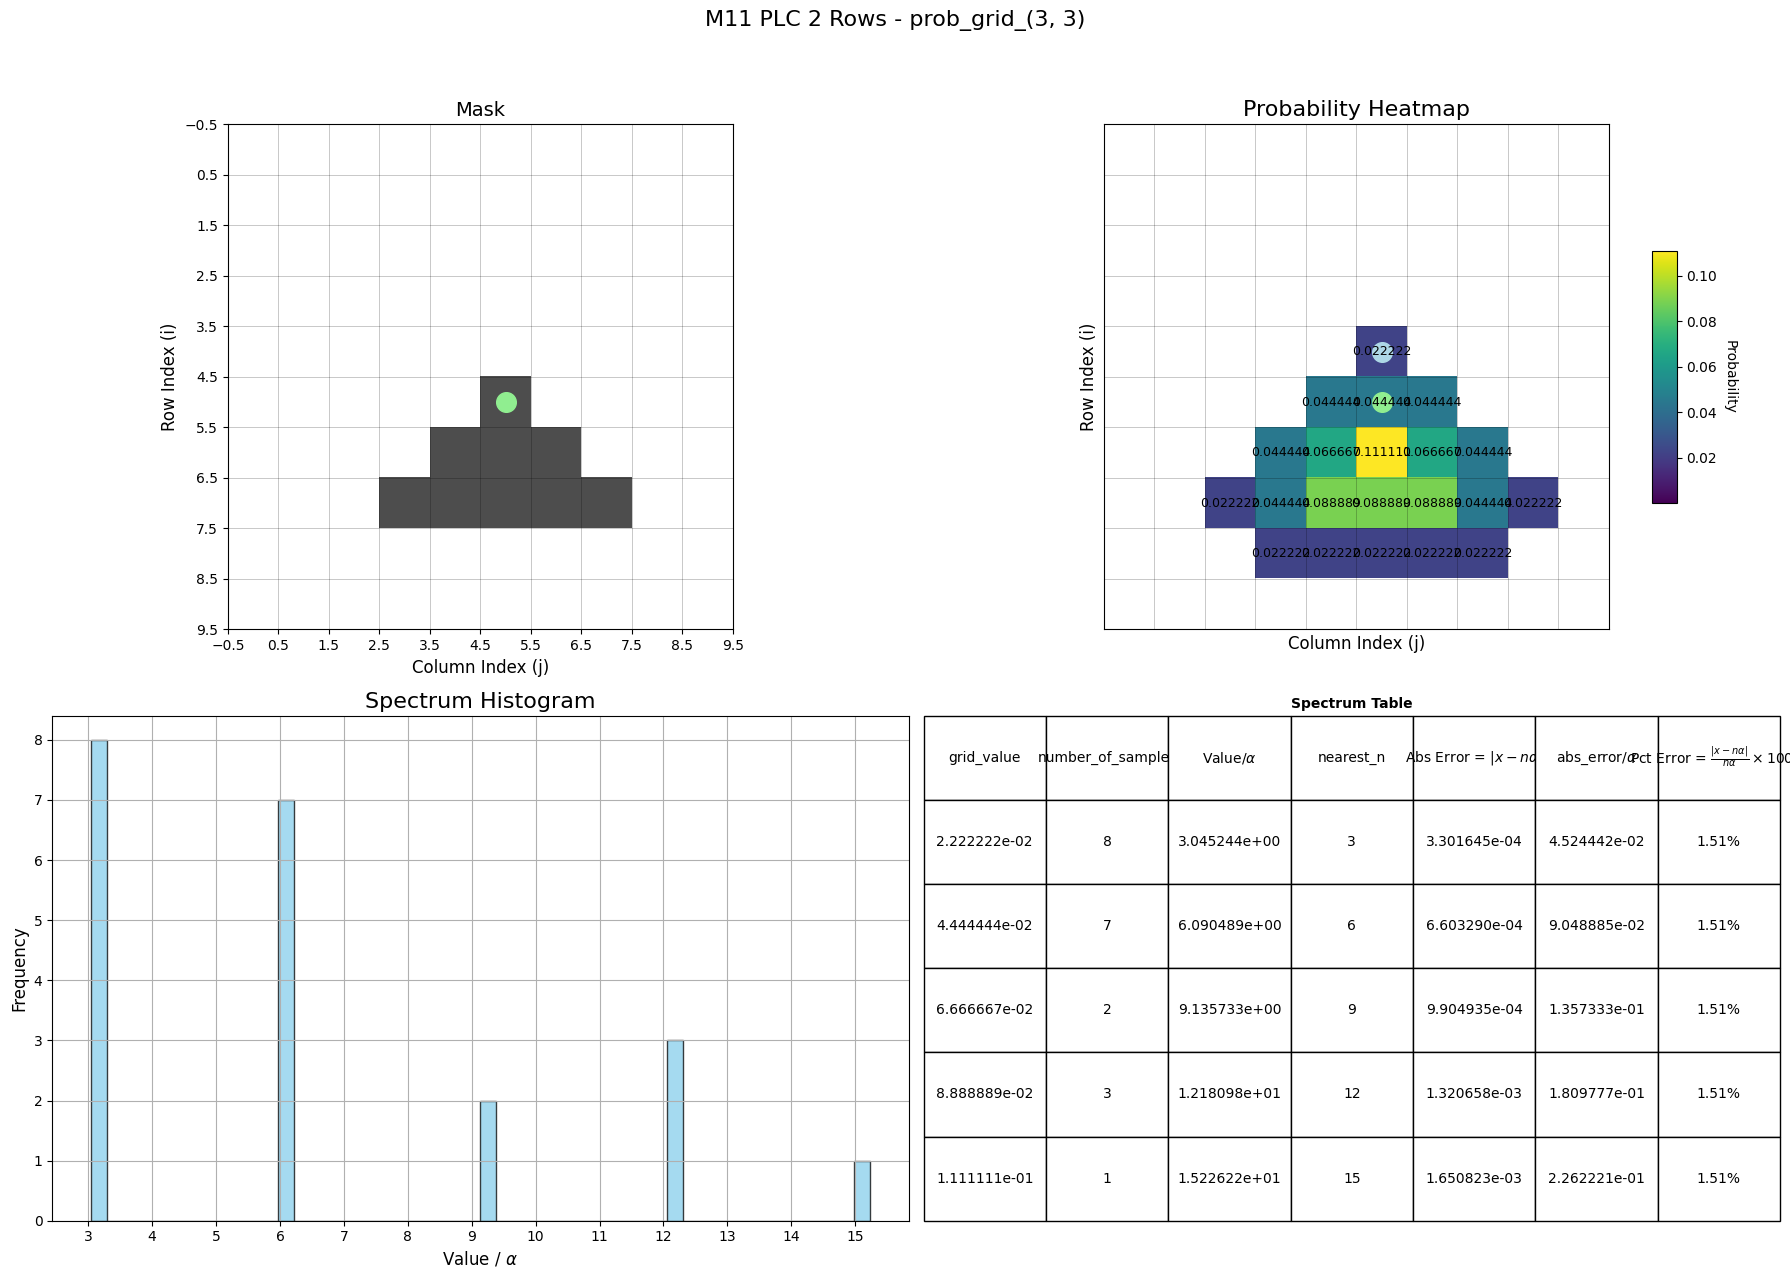

<ipython-input-3-11006b11703a>:629: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels)  # Set the labels


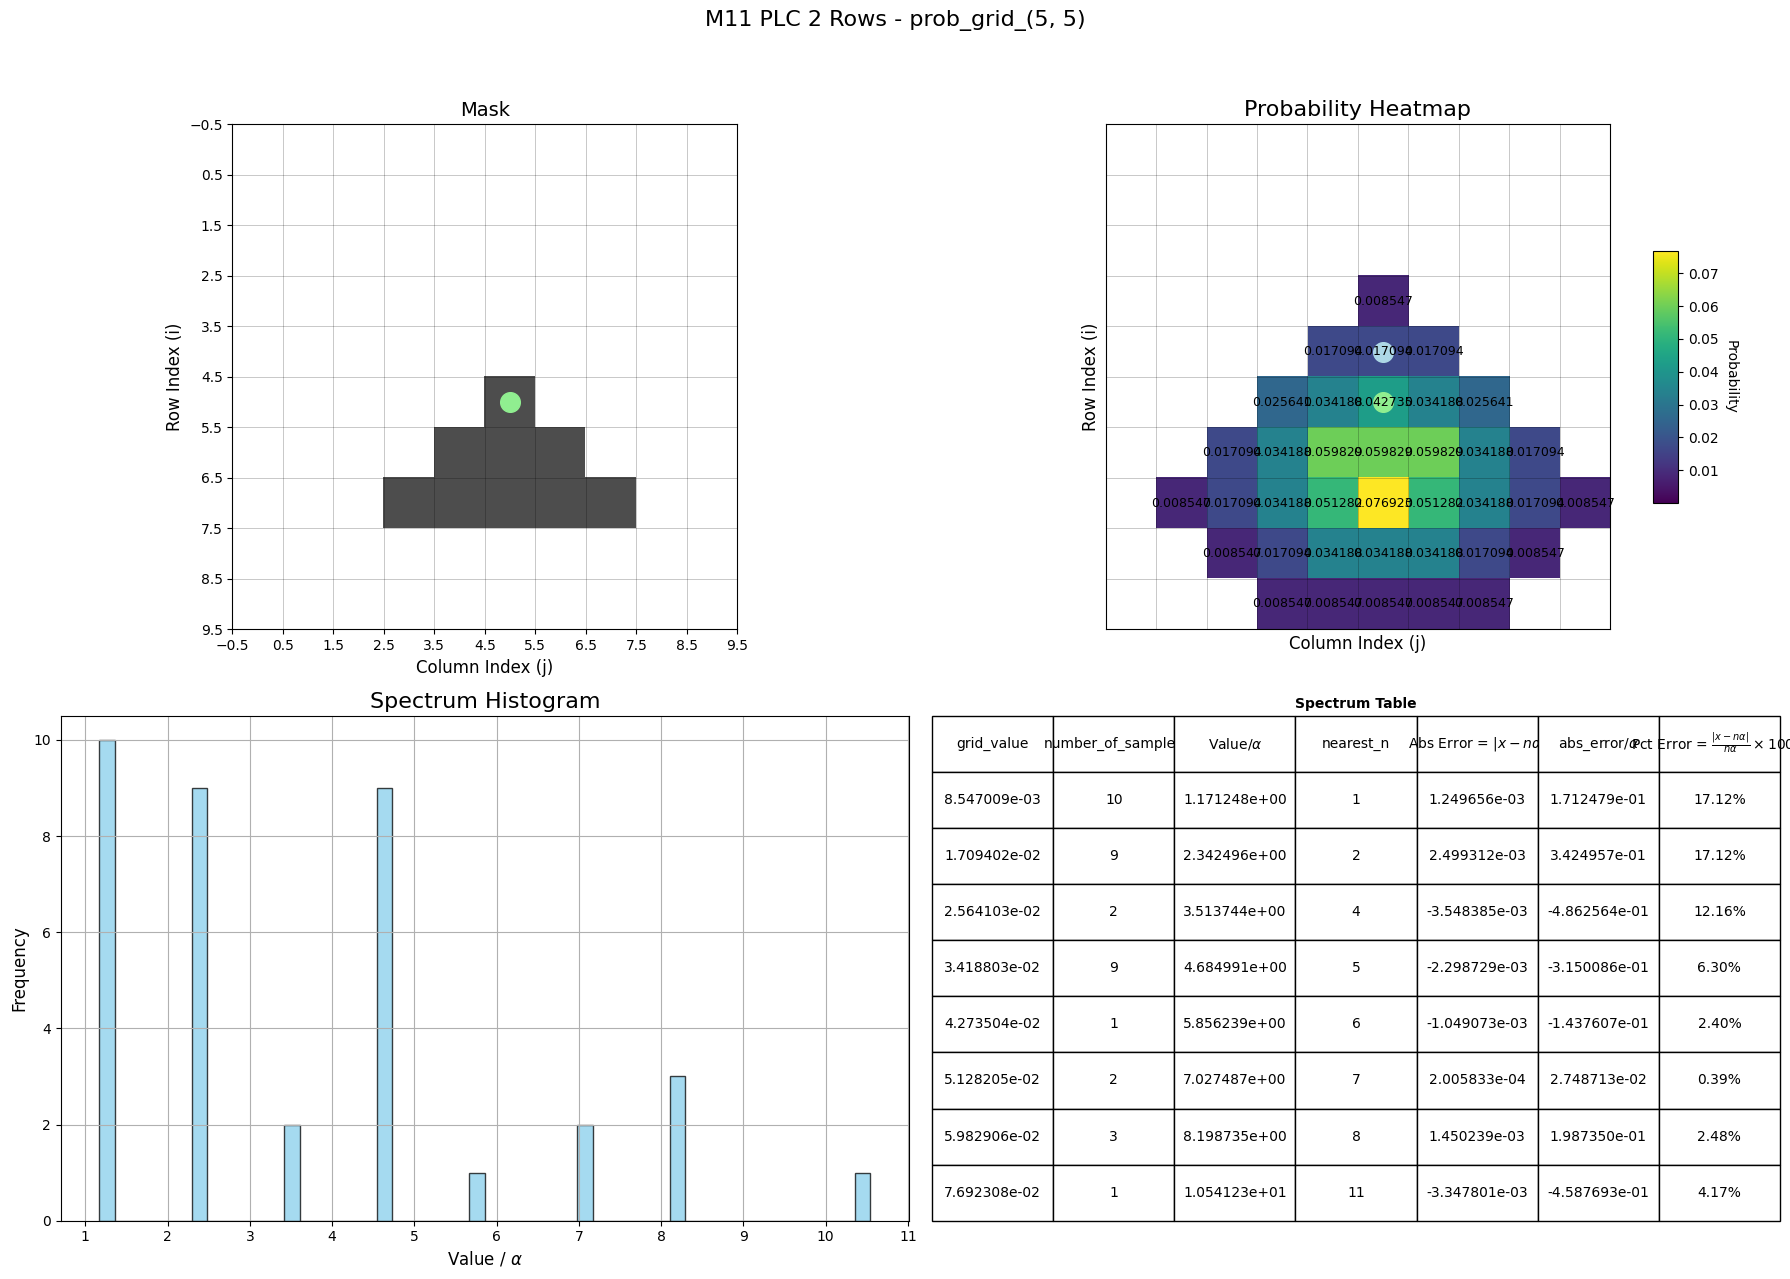

<ipython-input-3-11006b11703a>:629: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels)  # Set the labels


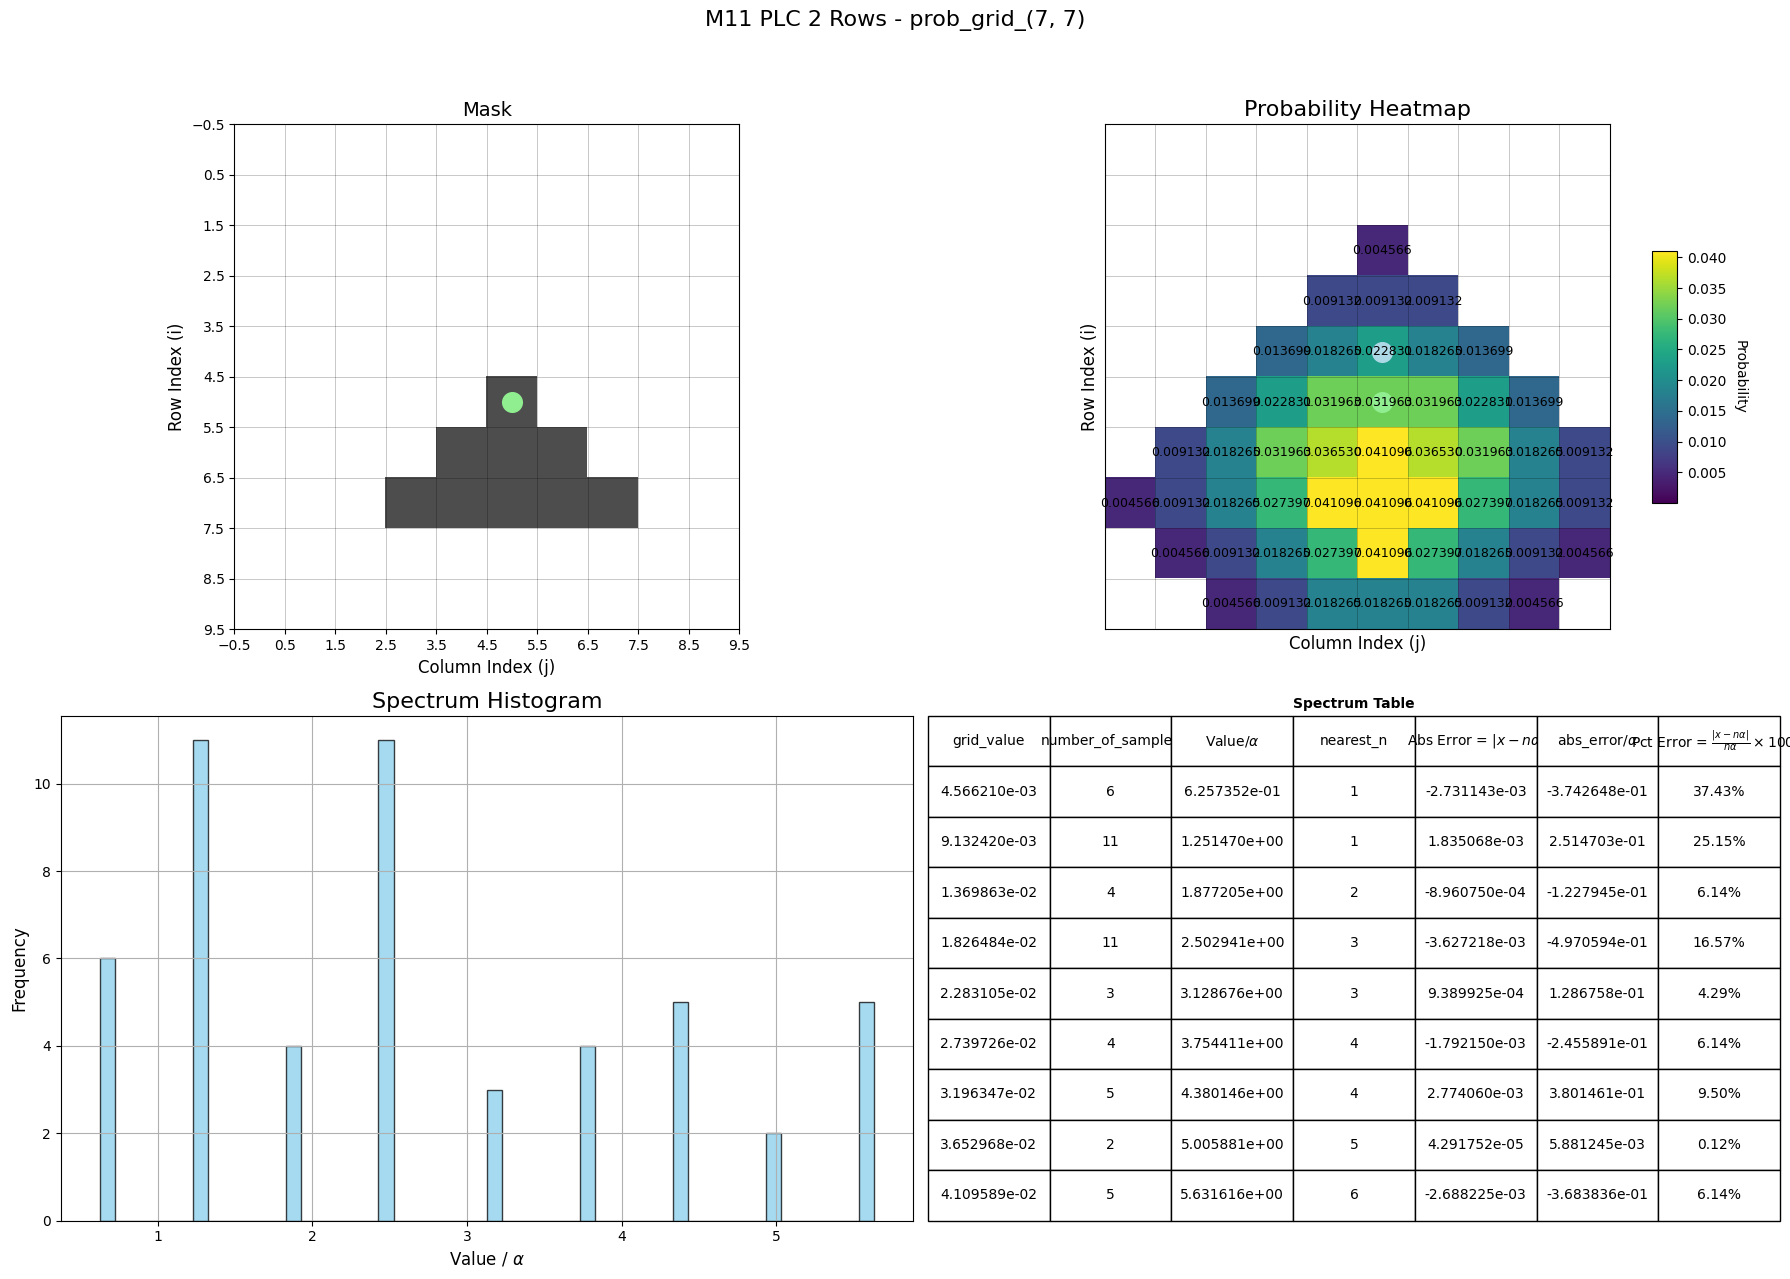

'\n#plot_single_experiment_alignments("M1 Ex 1 Inertial Ref", experiments_with_alignment_results["M1 Ex 1 Inertial Ref"])\n#plot_single_experiment_alignments("M2 Ex 1 Inertial Ref Plus Current", experiments_with_alignment_results["M2 Ex 1 Inertial Ref Plus Current"])\n#plot_single_experiment_alignments("M3 Minimal Tail 1 Node", experiments_with_alignment_results["M3 Minimal Tail 1 Node"])\nplot_single_experiment_alignments("M4:Minimal Tail 1 Node Plus Future", experiments_with_alignment_results["M4:Minimal Tail 1 Node Plus Future"])\n#plot_single_experiment_alignments("M5 Minimal Tail 2 Nodes", experiments_with_alignment_results["M5 Minimal Tail 2 Nodes"])\n#plot_single_experiment_alignments("M6 Minimal Tail 2 Nodes Plus Future", experiments_with_alignment_results["M6 Minimal Tail 2 Nodes Plus Future"])\n#plot_single_experiment_alignments("M7 Minimal Tail 3 Nodes", experiments_with_alignment_results["M7 Minimal Tail 3 Nodes"])\n#plot_single_experiment_alignments("M8 Minimal Tail 3 Node

In [ ]:
def plot_single_experiment_alignments(exp_name, exp_data):
    """
    For a single experiment (exp_data), loops over every probability grid
    (keys starting with "prob_grid_") and creates a 2x2 figure for each,
    displaying:
      - The mask (using plot_mask)
      - The probability heatmap (using plot_probability_heatmap)
      - The spectrum histogram (using plot_spectrum)
      - The spectrum table (using tabulate_spectrum and dispaly_spectrum_table)

    The overall title of each figure includes the experiment name,
    the probability grid key, and its alignment error.

    Parameters:
      - exp_name (str): The name of the experiment.
      - exp_data (dict): Dictionary containing experiment data. Must include:
            "mask"     : ndarray for the custom light cone mask,
            "center_i" : int, row index for the center node,
            "center_j" : int, column index for the center node,
        and one or more keys starting with "prob_grid_" with corresponding alignment
        scores stored under keys in the form "alignment_score_for_" + <suffix>.
    """
    # Check that exp_data is a dict and contains the required "mask" key.
    if not isinstance(exp_data, dict):
        raise ValueError(f"Data for experiment '{exp_name}' is not a dictionary.")
    if "mask" not in exp_data:
        raise KeyError(f"Experiment '{exp_name}' does not contain a 'mask' key. Available keys: {list(exp_data.keys())}")

    # Retrieve common experiment data.
    mask_data = exp_data["mask"]
    center_i = exp_data.get("center_i", 0)
    center_j = exp_data.get("center_j", 0)

    # Loop over keys that start with "prob_grid_"
    for key in sorted(exp_data.keys()):
        if key.startswith("prob_grid_"):
            prob_grid_data = exp_data[key]
            # Construct the corresponding alignment key.
            align_key = "alignment_score_for_" + key[len("prob_grid_"):]
            alignment_value = exp_data.get(align_key, None)

            # Build overall title for this probability grid.
            overall_title = f"{exp_name} - {key}"
            if alignment_value is not None:
                overall_title += f": Alignment Error = {alignment_value:.2e}"

            # Create a figure with 2x2 subplots.
            fig, axs = plt.subplots(2, 2, figsize=(18, 13))

            # Top Left: Plot the mask.
            plot_mask(axs[0, 0], mask_data, center_i, center_j, title="Mask")

            # Top Right: Plot the probability heatmap.
            plot_probability_heatmap(axs[0, 1], prob_grid_data,
                                     past_cone_mask=None, future_node_mask=None,
                                     center_i=center_i, center_j=center_j,
                                     title="Probability Heatmap")

            # Bottom Left: Plot the spectrum histogram.
            # Wrap the grid in a list, since these functions expect an iterable.
            plot_spectrum(axs[1, 0], [prob_grid_data], title="Spectrum Histogram")

            # Bottom Right: Tabulate and display the spectrum table.
            table_data = tabulate_spectrum([prob_grid_data])
            dispaly_spectrum_table(axs[1, 1], table_data, title="Spectrum Table")

            # Set the overall title and adjust layout.
            fig.suptitle(overall_title, fontsize=16)
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()


#top 5
#1 k3x3
#plot_single_experiment_alignments("M16 PLC with 4 Row Diamond Plus Future", experiments_with_alignment_results["M16 PLC with 4 Row Diamond Plus Future"])
#2 k3x3
plot_single_experiment_alignments("M11 PLC 2 Rows", experiments_with_alignment_results["M11 PLC 2 Rows"])
#3 k 5x5
#plot_single_experiment_alignments("M24 PLC with 2 Rows and Short Tail Plus Future", experiments_with_alignment_results["M24 PLC with 2 Rows and Short Tail Plus Future"])
#4 k5x5
#plot_single_experiment_alignments("M12 PLC 2 Rows Plus Future", experiments_with_alignment_results["M12 PLC 2 Rows Plus Future"])
#5 k3x3
#plot_single_experiment_alignments("M4:Minimal Tail 1 Node Plus Future", experiments_with_alignment_results["M4:Minimal Tail 1 Node Plus Future"])

"""
#plot_single_experiment_alignments("M1 Ex 1 Inertial Ref", experiments_with_alignment_results["M1 Ex 1 Inertial Ref"])
#plot_single_experiment_alignments("M2 Ex 1 Inertial Ref Plus Current", experiments_with_alignment_results["M2 Ex 1 Inertial Ref Plus Current"])
#plot_single_experiment_alignments("M3 Minimal Tail 1 Node", experiments_with_alignment_results["M3 Minimal Tail 1 Node"])
plot_single_experiment_alignments("M4:Minimal Tail 1 Node Plus Future", experiments_with_alignment_results["M4:Minimal Tail 1 Node Plus Future"])
#plot_single_experiment_alignments("M5 Minimal Tail 2 Nodes", experiments_with_alignment_results["M5 Minimal Tail 2 Nodes"])
#plot_single_experiment_alignments("M6 Minimal Tail 2 Nodes Plus Future", experiments_with_alignment_results["M6 Minimal Tail 2 Nodes Plus Future"])
#plot_single_experiment_alignments("M7 Minimal Tail 3 Nodes", experiments_with_alignment_results["M7 Minimal Tail 3 Nodes"])
#plot_single_experiment_alignments("M8 Minimal Tail 3 Nodes Plus Future", experiments_with_alignment_results["M8 Minimal Tail 3 Nodes Plus Future"])
#plot_single_experiment_alignments("M9 PLC 1 Row", experiments_with_alignment_results["M9 PLC 1 Row"])
#plot_single_experiment_alignments("M10 PLC 1 Row Plus Future", experiments_with_alignment_results["M10 PLC 1 Row Plus Future"])
plot_single_experiment_alignments("M11 PLC 2 Rows", experiments_with_alignment_results["M11 PLC 2 Rows"])
plot_single_experiment_alignments("M12 PLC 2 Rows Plus Future", experiments_with_alignment_results["M12 PLC 2 Rows Plus Future"])
#plot_single_experiment_alignments("M13 PLC 2 Rows and Row 3 Minus", experiments_with_alignment_results["M13 PLC 2 Rows and Row 3 Minus"])
#plot_single_experiment_alignments("M14 PLC 2 Rows and Row 3 Minus Plus Future", experiments_with_alignment_results["M14 PLC 2 Rows and Row 3 Minus Plus Future"])
#plot_single_experiment_alignments("M15 PLC with 4 Row Diamond", experiments_with_alignment_results["M15 PLC with 4 Row Diamond"])
plot_single_experiment_alignments("M16 PLC with 4 Row Diamond Plus Future", experiments_with_alignment_results["M16 PLC with 4 Row Diamond Plus Future"])
#plot_single_experiment_alignments("M17 PLC with 3 Rows", experiments_with_alignment_results["M17 PLC with 3 Rows"])
#plot_single_experiment_alignments("M18 PLC with 3 Rows Plus Future", experiments_with_alignment_results["M18 PLC with 3 Rows Plus Future"])
#plot_single_experiment_alignments("M19 PLC with 4 Rows", experiments_with_alignment_results["M19 PLC with 4 Rows"])
#plot_single_experiment_alignments("M20 PLC with 4 Rows Plus Future", experiments_with_alignment_results["M20 PLC with 4 Rows Plus Future"])
#plot_single_experiment_alignments("M21 PLC with 1 Row and Short Tail", experiments_with_alignment_results["M21 PLC with 1 Row and Short Tail"])
#plot_single_experiment_alignments("M22 PLC with 1 Row and Short Tail Plus Future", experiments_with_alignment_results["M22 PLC with 1 Row and Short Tail Plus Future"])
#plot_single_experiment_alignments("M23 PLC with 2 Rows and Short Tail", experiments_with_alignment_results["M23 PLC with 2 Rows and Short Tail"])
plot_single_experiment_alignments("M24 PLC with 2 Rows and Short Tail Plus Future", experiments_with_alignment_results["M24 PLC with 2 Rows and Short Tail Plus Future"])
#plot_single_experiment_alignments("M25 PLC with 3 Rows and Short Tail", experiments_with_alignment_results["M25 PLC with 3 Rows and Short Tail"])
#plot_single_experiment_alignments("M26 PLC with 3 Rows and Short Tail Plus Future", experiments_with_alignment_results["M26 PLC with 3 Rows and Short Tail Plus Future"])
#plot_single_experiment_alignments("M27 PLC with 3 Rows plus 4 Minus Minus", experiments_with_alignment_results["M27 PLC with 3 Rows plus 4 Minus Minus"])
#plot_single_experiment_alignments("M28 PLC with 3 Rows plus 4 Minus Minus Plus future", experiments_with_alignment_results["M28 PLC with 3 Rows plus 4 Minus Minus Plus future"])
#plot_single_experiment_alignments("M29 PLC with 3 Rows plus 4 Minus", experiments_with_alignment_results["M29 PLC with 3 Rows plus 4 Minus"])
#plot_single_experiment_alignments("M30 PLC with 3 Rows plus 4 Minus Plus future", experiments_with_alignment_results["M30 PLC with 3 Rows plus 4 Minus Plus future"])
"""


In [ ]:
# Assuming tto_kernel_experiments is already defined as in your snippet:
experiment_calls = [
    f'plot_single_experiment_alignments("{name}", experiments_with_alignment_results["{name}"])'
    for name in tto_kernel_experiments.keys()
]

# If you want to print them one by one:
for call in experiment_calls:
    print(call)

plot_single_experiment_alignments("M1 Ex 1 Inertial Ref", experiments_with_alignment_results["M1 Ex 1 Inertial Ref"])
plot_single_experiment_alignments("M2 Ex 1 Inertial Ref Plus Current", experiments_with_alignment_results["M2 Ex 1 Inertial Ref Plus Current"])
plot_single_experiment_alignments("M3 Minimal Tail 1 Node", experiments_with_alignment_results["M3 Minimal Tail 1 Node"])
plot_single_experiment_alignments("M4:Minimal Tail 1 Node Plus Future", experiments_with_alignment_results["M4:Minimal Tail 1 Node Plus Future"])
plot_single_experiment_alignments("M5 Minimal Tail 2 Nodes", experiments_with_alignment_results["M5 Minimal Tail 2 Nodes"])
plot_single_experiment_alignments("M6 Minimal Tail 2 Nodes Plus Future", experiments_with_alignment_results["M6 Minimal Tail 2 Nodes Plus Future"])
plot_single_experiment_alignments("M7 Minimal Tail 3 Nodes", experiments_with_alignment_results["M7 Minimal Tail 3 Nodes"])
plot_single_experiment_alignments("M8 Minimal Tail 3 Nodes Plus Future", e

# Boost Resolution Studies

In [ ]:
# --- Assume these helper functions are defined elsewhere ---
# For example:
# def initialize_grid(M, N): ...
# def create_space_filling_lattice_kernel(r): ...
# def define_past_light_cone(M, N, center_i, center_j, k): ...
# def add_future_node(past_cone_mask, center_i, center_j, observer_type): ...
# def compute_probability_grid(light_cone_mask, kernel, epsilon): ...

# ------------------ MAIN ------------------
if __name__ == "__main__":
    M, N = 10, 10  # Grid size (rows(y) x columns(x))
    r = 2          # Kernel radius
    k = 0.5        # Slope factor for the light cone
    observer_type = 'accelerating'
    event_labels = False
    title = "Probability Surface " + observer_type + " Next Event"


    # --- Grid initialization, kernel definition, and scenario calculation ---
    grid, center_i, center_j = initialize_grid(M, N)
    kernel = create_space_filling_lattice_kernel(r)
    binary_kernel = kernel.copy()

    future_i, future_j = calc_future_node(center_i, center_j, observer_type)

    past_cone_mask_1 = define_past_light_cone(M, N, center_i, center_j, k=k)
    light_cone_mask_1, future_node_mask_1 = add_future_node(past_cone_mask_1, center_i, center_j, observer_type=observer_type)
    prob_grid = compute_probability_grid(light_cone_mask_1, kernel, epsilon=1e-10)

    # --- Call the visualization function ---
    # Here we set an ROI to zoom in (columns 2 to 8, rows 2 to 8). Adjust as needed.
    visualize_probability_surface(prob_grid, center_i, center_j, future_i, future_j,
                                  x_start=0, x_end=N,
                                  y_start=0, y_end=M,
                                  event_threshold=0.0001,
                                  offset=0.05,
                                  invert_surface=True,
                                  norm_to_alpha=False,
                                  aspectratio=dict(x=1.2, y=1.0, z=1.0),
                                  show_event_labels=False,
                                  surface_opacity=0.9,
                                  plot_title = title)


In [ ]:
import numpy as np
import plotly.graph_objects as go

# --- Assume these helper functions are defined elsewhere ---
# initialize_grid, create_space_filling_lattice_kernel, define_past_light_cone,
# add_future_node, compute_probability_grid

# === USER CONTROLS ===
norm_to_alpha = True  # Set to True to normalize to alpha
invert_surface = True  # Set to True to flip the surface for "Marble Roll View"
event_threshold = 0.0001  # Minimum probability for marking events
alpha = 0.007297  # Fine-structure constant

# Test Params
M, N = 10, 10  # Grid size (rows x columns)
r = 2          # Radius of the uniform Euclidean kernel
k = 0.5        # Slope factor for the light cone

# === SELECT REGION OF INTEREST (ROI) ===
# Define indices for zooming into a region (adjust as needed)
x_start, x_end = 0, N  # columns (x dimension)
y_start, y_end = 0, M-3  # rows (y dimension)

# Initialize grid and center node
grid, center_i, center_j = initialize_grid(M, N)

# Define the kernel
# kernel = create_uniform_euclidean_kernel(r)
kernel = create_space_filling_lattice_kernel(r)
binary_kernel = kernel.copy()

# Scenario 1: Inertial Observer
observer_type_1 = 'inertial'
past_cone_mask_1 = define_past_light_cone(M, N, center_i, center_j, k=k)
light_cone_mask_1, future_node_mask_1 = add_future_node(past_cone_mask_1, center_i, center_j, observer_type=observer_type_1)
prob_grid = compute_probability_grid(light_cone_mask_1, kernel, epsilon=1e-10)

# === INVERT ===
if invert_surface:
    prob_grid = -prob_grid

# === NORMALIZE IN TERMS OF ALPHA ===
if norm_to_alpha:
    prob_grid = prob_grid / alpha

# Slice the probability grid and corresponding x and y arrays
zoomed_prob_grid = prob_grid[y_start:y_end, x_start:x_end]
x_values = np.arange(-center_j, N - center_j)[x_start:x_end]
y_values = np.arange(-center_i, M - center_i)[y_start:y_end]

# === COLLECT EVENT POINTS (Ensuring they stay visible when inverted) ===
offset = 0.05  # Small offset to keep labels readable above points

# Separate events into two groups based on text color
black_events = {"x": [], "y": [], "z": [], "labels": []}
white_events = {"x": [], "y": [], "z": [], "labels": []}

for i in range(M):
    for j in range(N):
        prob_value = prob_grid[i, j]
        if abs(prob_value) > abs(event_threshold):
            x_val = j - center_j
            y_val = i - center_i
            adjusted_z = prob_value
            label_z = adjusted_z + offset
            label = f"{label_z:.2f}"
            if invert_surface:
                if prob_value > 0.5 * np.min(prob_grid):
                    black_events["x"].append(x_val)
                    black_events["y"].append(y_val)
                    black_events["z"].append(adjusted_z)
                    black_events["labels"].append(label)
                else:
                    white_events["x"].append(x_val)
                    white_events["y"].append(y_val)
                    white_events["z"].append(adjusted_z)
                    white_events["labels"].append(label)
            else:
                if prob_value < 0.5 * np.max(prob_grid):
                    white_events["x"].append(x_val)
                    white_events["y"].append(y_val)
                    white_events["z"].append(adjusted_z)
                    white_events["labels"].append(label)
                else:
                    black_events["x"].append(x_val)
                    black_events["y"].append(y_val)
                    black_events["z"].append(adjusted_z)
                    black_events["labels"].append(label)

# Filter event markers so only points within the zoomed region are plotted
def in_zoom(x, y, x_min, x_max, y_min, y_max):
    return (x >= x_min) and (x <= x_max) and (y >= y_min) and (y <= y_max)

# Define the ROI boundaries based on the x_values and y_values
x_min, x_max = x_values[0], x_values[-1]
y_min, y_max = y_values[0], y_values[-1]

def filter_events(events):
    filtered = {"x": [], "y": [], "z": [], "labels": []}
    for x, y, z, label in zip(events["x"], events["y"], events["z"], events["labels"]):
        if in_zoom(x, y, x_min, x_max, y_min, y_max):
            filtered["x"].append(x)
            filtered["y"].append(y)
            filtered["z"].append(z)
            filtered["labels"].append(label)
    return filtered

zoomed_black_events = filter_events(black_events)
zoomed_white_events = filter_events(white_events)

# === CREATE 3D PLOT ===
fig = go.Figure()

# Add probability surface for the zoomed region
fig.add_trace(go.Surface(
    z=zoomed_prob_grid,
    x=x_values,
    y=y_values,
    colorscale='Viridis',
    opacity=0.9
))

# Add the event markers for the zoomed region
fig.add_trace(go.Scatter3d(
    x=zoomed_black_events["x"],
    y=zoomed_black_events["y"],
    z=zoomed_black_events["z"],
    mode='markers+text',
    marker=dict(size=5, color='red', opacity=0.85),
    text=zoomed_black_events["labels"],
    textposition="top center",
    textfont=dict(color="black")
))
fig.add_trace(go.Scatter3d(
    x=zoomed_white_events["x"],
    y=zoomed_white_events["y"],
    z=zoomed_white_events["z"],
    mode='markers+text',
    marker=dict(size=5, color='red', opacity=0.85),
    text=zoomed_white_events["labels"],
    textposition="top center",
    textfont=dict(color="white")
))

# === LAYOUT CUSTOMIZATION ===
fig.update_layout(
    title="Zoomed 3D Probability Surface",
    scene=dict(
        xaxis=dict(title="", showticklabels=False),
        yaxis=dict(title="", showticklabels=False),
        zaxis=dict(
            title="Probability",
            tickformat=".3f"
        ),
        camera=dict(eye=dict(x=1.1, y=1.0, z=0.9)),
        aspectratio=dict(x=1.2, y=1, z=1.0)  # Adjust aspect ratio as needed
    ),
    width=1800,
    height=1200
)

# SHOW PLOT
fig.show()


# Next Event Studies (Exp 1)

\begin{table}[htbp]
\centering
\caption{Comparison of probability statistics Inside the light cone.}
\label{tab:inside_comparison}
\begin{tabular}{lrrr}
\toprule
Metric & Inertial Observer & Accelerating Observer & $O_a - O_i$ \\
\midrule
Min Prob & 0.013699 & 0.0068493 & -0.0068493 \\ 
Max Prob & 0.068493 & 0.068493 & 0 \\ 
Total & 0.59589 & 0.58219 & -0.013699 \\ 
\bottomrule
\end{tabular}
\end{table}
\begin{table}[htbp]
\centering
\caption{Comparison of probability statistics Outside the light cone.}
\label{tab:outside_comparison}
\begin{tabular}{lrrr}
\toprule
Metric & Inertial Observer & Accelerating Observer & $O_a - O_i$ \\
\midrule
Min Prob & 0 & 0 & 0 \\ 
Max Prob & 0.034247 & 0.034247 & 0 \\ 
Total & 0.40411 & 0.41781 & 0.013699 \\ 
\bottomrule
\end{tabular}
\end{table}
\begin{tabular}{rrrrrrr}
\toprule
Value & Count & Value/$\alpha$ & nearest_n & Abs Error = $|x - n\alpha|$ & abs_error/$\alpha$ & Pct Error = $\frac{|x - n\alpha|}{n\alpha} \times 100\%$ \\
\midrule
-6.849315e

<ipython-input-101-4383c6a3558c>:595: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



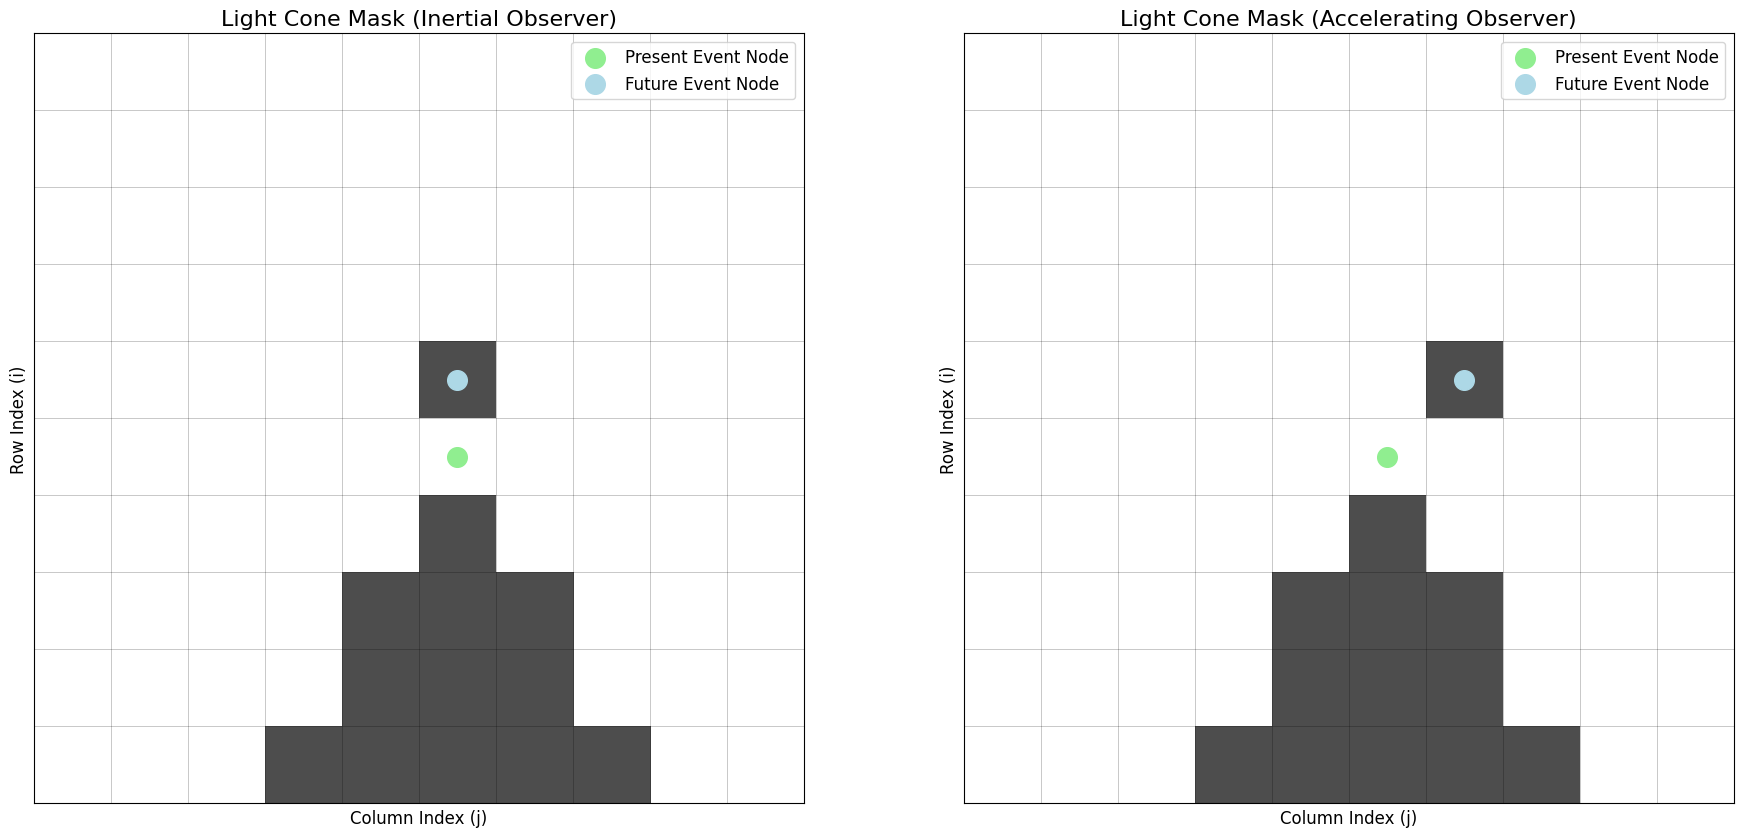

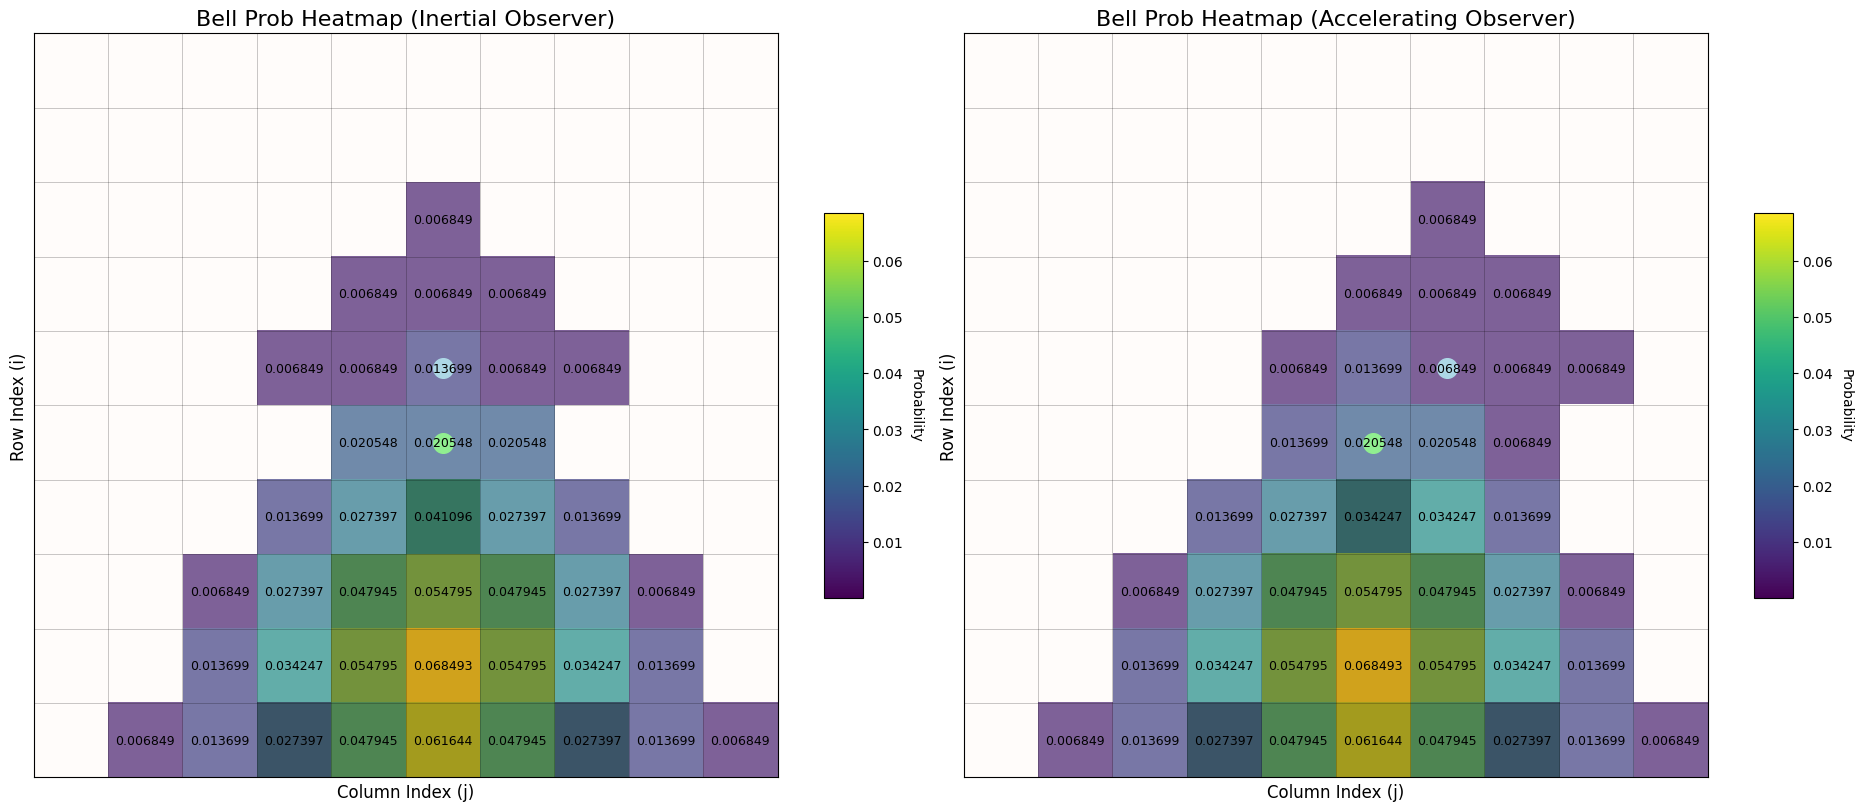

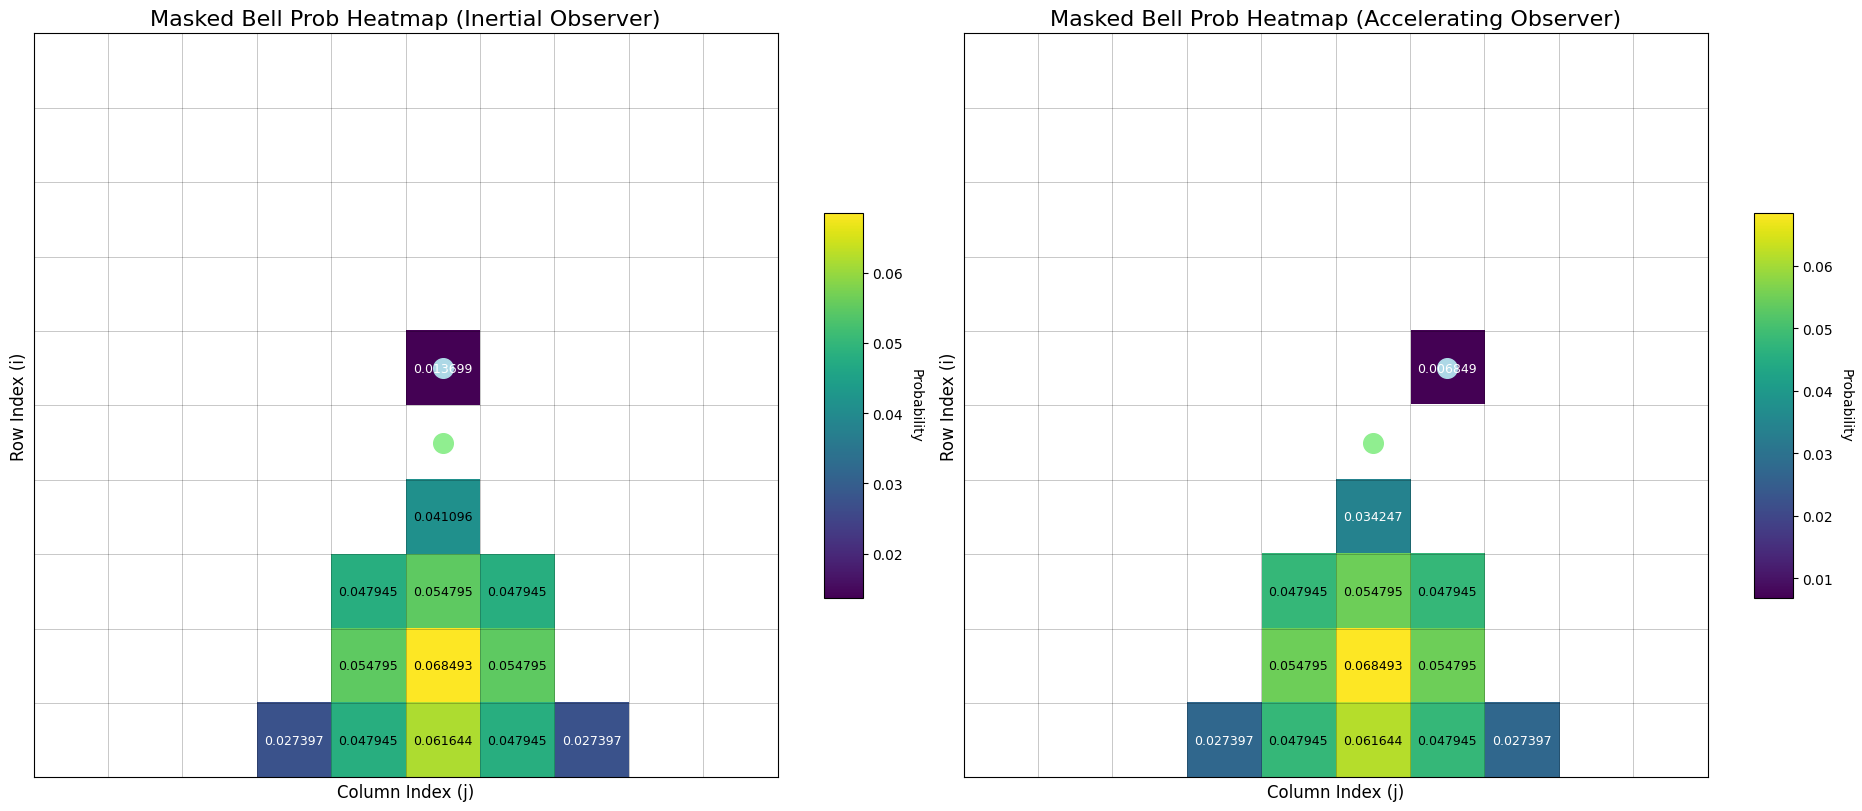

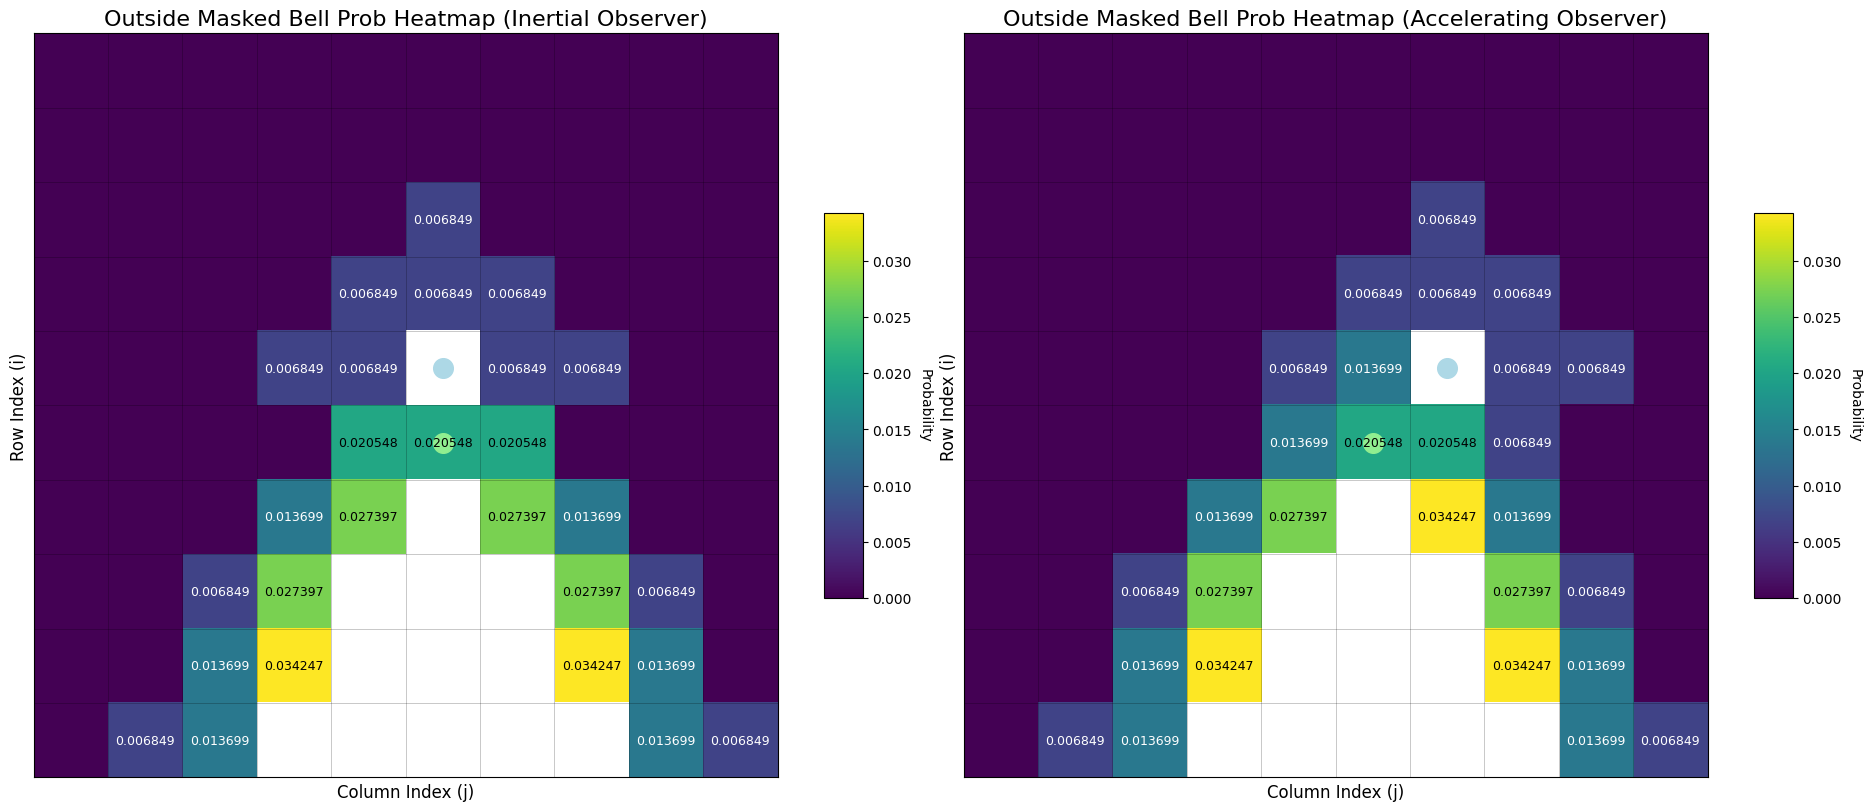

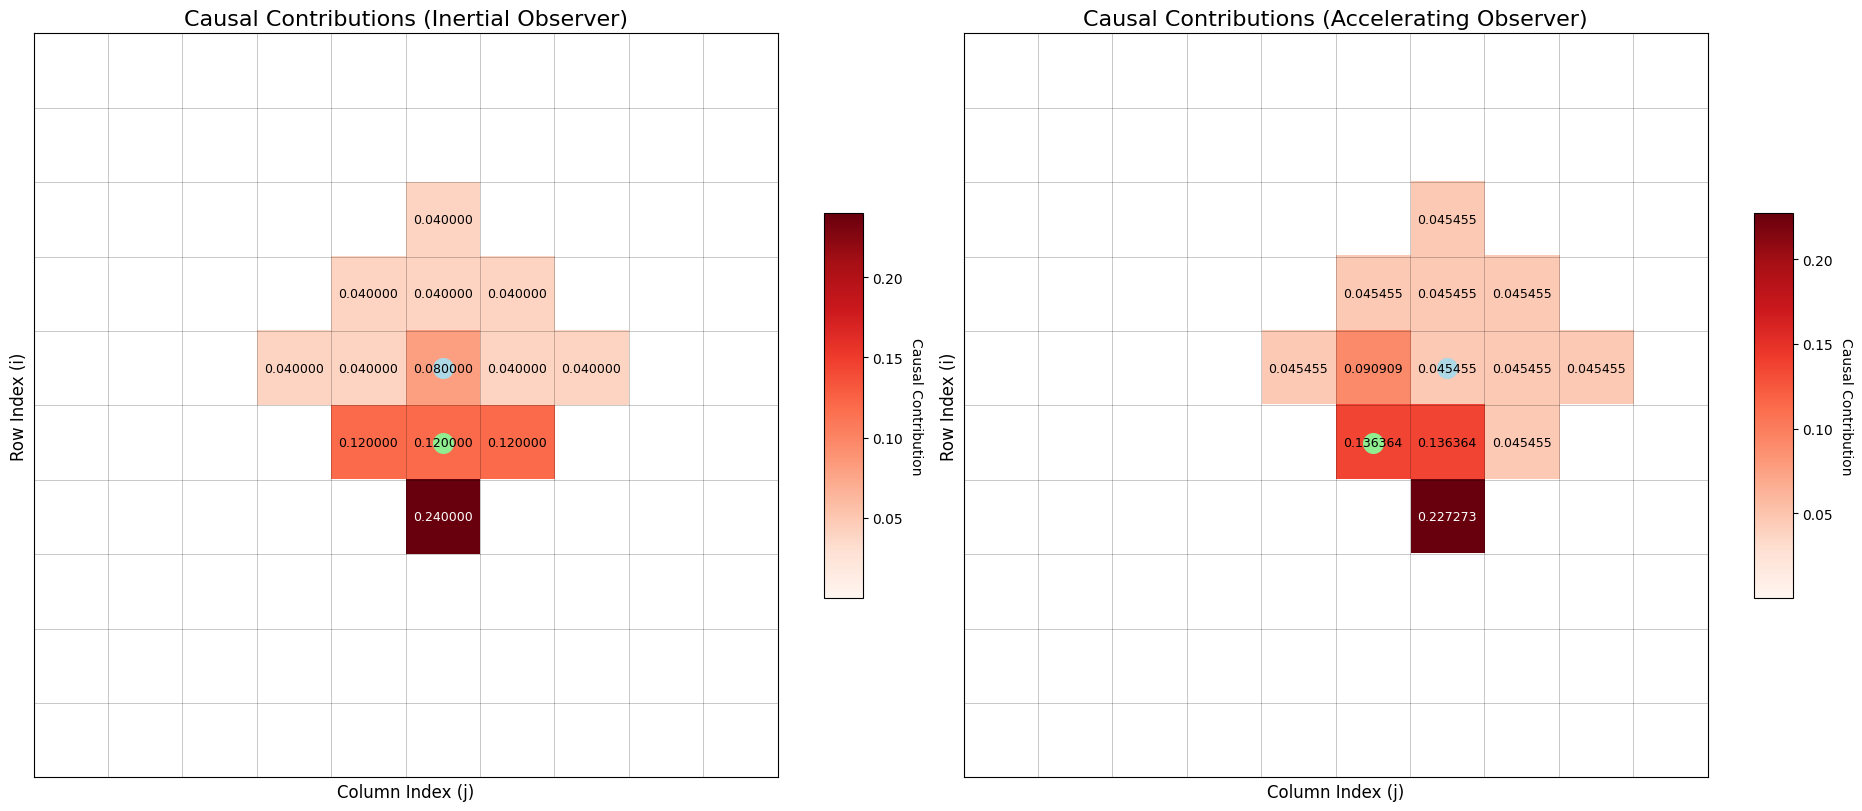

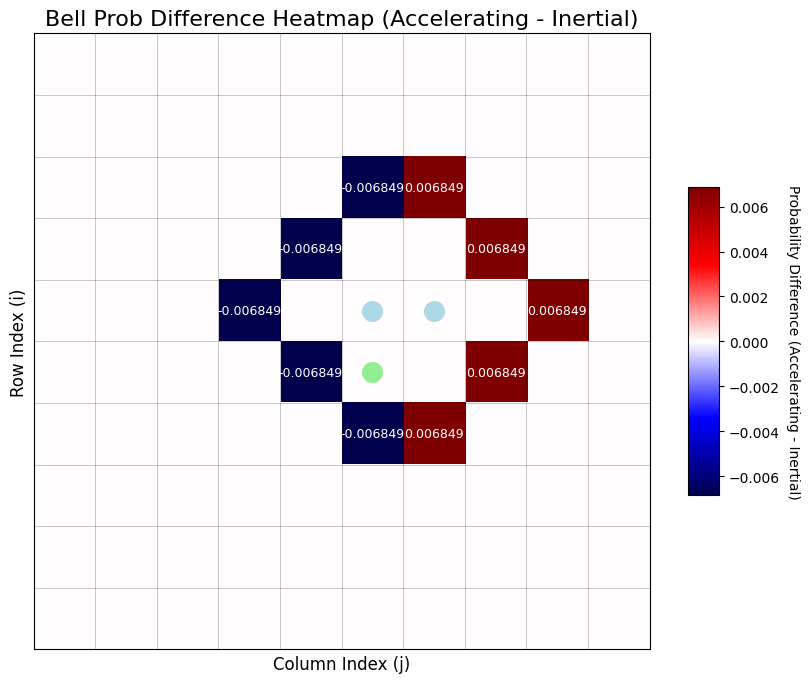

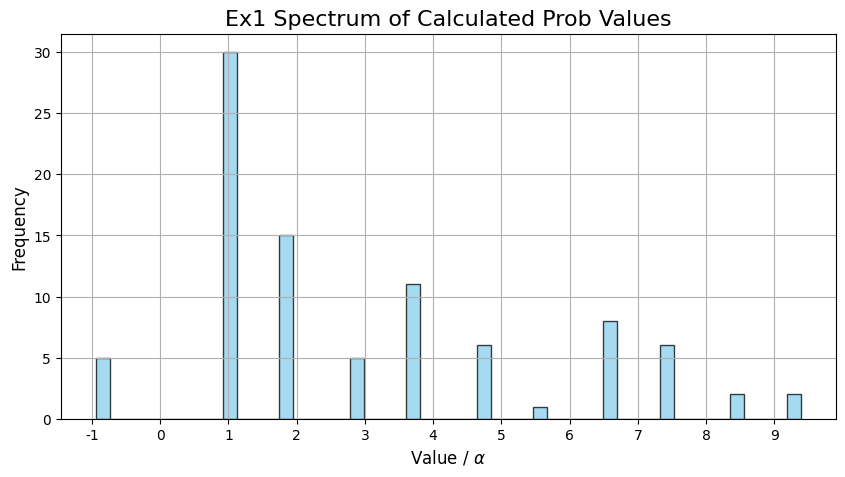

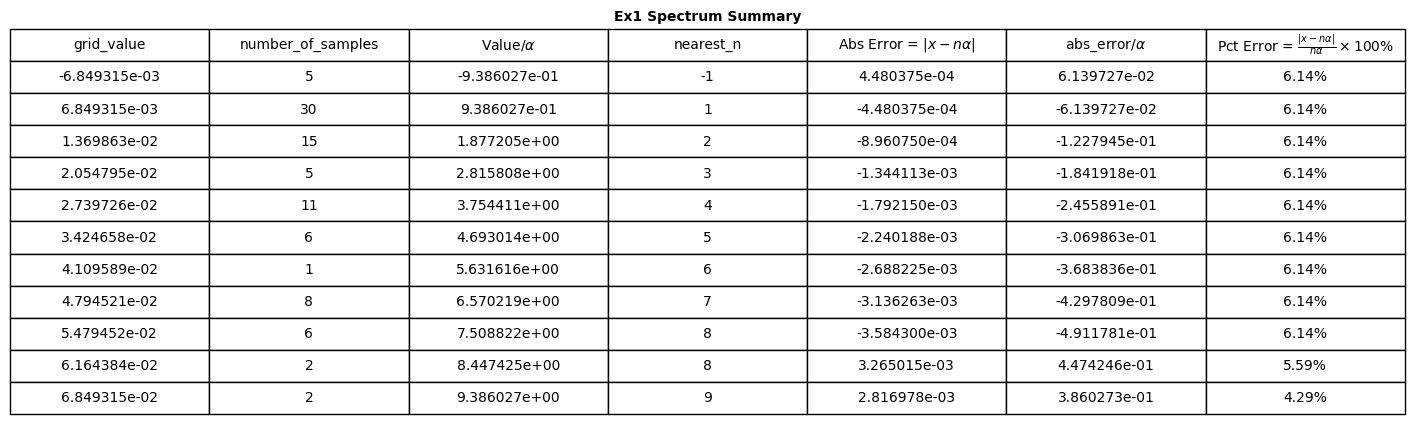

In [ ]:
def main():
    # Fine Structure Constant Coincidence - Parameters
    #M, N = 10, 10  # Grid size (rows x columns)
    #r = 2          # Radius of the uniform Euclidean kernel
    #k = 0.5        # Slope factor for the light cone

    # Test Params
    M, N = 10, 10  # Grid size (rows x columns)
    r = 2          # Radius of the uniform Euclidean kernel
    k = 0.5        # Slope factor for the light cone

    # Initialize grid and center node
    grid, center_i, center_j = initialize_grid(M, N)

    # Define the kernel
    #kernel = create_uniform_euclidean_kernel(r)
    kernel = create_space_filling_lattice_kernel(r)
    binary_kernel = kernel.copy()

    # Scenario 1: Inertial Observer
    observer_type_1 = 'inertial'
    past_cone_mask_1 = define_past_light_cone(M, N, center_i, center_j, k=k)
    #past_cone_mask_1 = define_adaptive_light_cone(M, N, center_i, center_j, k=k)
    light_cone_mask_1, future_node_mask_1 = add_future_node(past_cone_mask_1, center_i, center_j, observer_type=observer_type_1)
    prob_grid_1 = compute_probability_grid(light_cone_mask_1, kernel, epsilon=1e-10)

    # Scenario 2: Accelerating Observer
    observer_type_2 = 'accelerating'
    past_cone_mask_2 = define_past_light_cone(M, N, center_i, center_j, k=k)
    #past_cone_mask_2 = define_adaptive_light_cone(M, N, center_i, center_j, k=k)
    light_cone_mask_2, future_node_mask_2 = add_future_node(past_cone_mask_2, center_i, center_j, observer_type=observer_type_2)
    prob_grid_2 = compute_probability_grid(light_cone_mask_2, kernel, epsilon=1e-10)

    # Compute statistics for both observers
    stats_inertial = verify_probabilities(prob_grid_1, light_cone_mask_1, observer_type_1)
    stats_accelerating = verify_probabilities(prob_grid_2, light_cone_mask_2, observer_type_2)

    # Combine statistics into dictionaries for the tables
    stats_table_outside = {
        "Inertial": stats_inertial["Outside"],
        "Accelerating": stats_accelerating["Outside"]
    }

    stats_table_inside = {
        "Inertial": stats_inertial["Inside"],
        "Accelerating": stats_accelerating["Inside"]
    }

    # Compute contribution maps
    contribution_from_prob_1 = compute_causal_contributions_from_prob_grid(
        prob_grid_1, kernel, center_i, center_j, observer_type='inertial'
    )

    contribution_from_prob_2 = compute_causal_contributions_from_prob_grid(
        prob_grid_2, kernel, center_i, center_j, observer_type='accelerating'
    )


    # Visualization -----------------------------------------
    # 1. Light Cone Masks
    fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=light_cone_mask_figsize)  # Adjust figsize as needed
    plot_light_cone(ax1, light_cone_mask_1, center_i, center_j, observer_type_1, title="Light Cone Mask (Inertial Observer)")
    plot_light_cone(ax2, light_cone_mask_2, center_i, center_j, observer_type_2, title="Light Cone Mask (Accelerating Observer)")
    plt.subplots_adjust(wspace=0.0)
    #fig1.savefig("Ex1_fig1_light_cone_masks.pdf", dpi=pdf_dpi)  # Save as PDF or desired format
    #plt.close(fig1)  # Close the figure to release resources

    # 2. Probability Heatmaps
    fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=heatmaps_figsize)
    # Row 2: Probability Heatmaps
    plot_probability_heatmap(ax3, prob_grid_1, past_cone_mask=past_cone_mask_1, future_node_mask=future_node_mask_1,
                            center_i=center_i, center_j=center_j, observer_type=observer_type_1, title="Bell Prob Heatmap (Inertial Observer)")
    plot_probability_heatmap(ax4, prob_grid_2, past_cone_mask=past_cone_mask_2, future_node_mask=future_node_mask_2,
                            center_i=center_i, center_j=center_j, observer_type=observer_type_2, title="Bell Prob Heatmap (Accelerating Observer)")
    plt.subplots_adjust(wspace=0.0)
    #fig2.savefig("Ex1_fig2_probability_heatmaps.pdf", dpi=pdf_dpi)
    #plt.close(fig2)

    # 3. Masked Probability Heatmaps (Inside PLC)
    fig3, (ax5, ax6) = plt.subplots(1, 2, figsize=heatmaps_figsize)
    # Row 3: Masked Probability Heatmaps (Inside PLC)
    plot_masked_probability_heatmap(ax5, prob_grid_1, past_cone_mask=past_cone_mask_1, future_node_mask=future_node_mask_1,
                                    center_i=center_i, center_j=center_j, observer_type=observer_type_1, title="Masked Bell Prob Heatmap (Inertial Observer)")
    plot_masked_probability_heatmap(ax6, prob_grid_2, past_cone_mask=past_cone_mask_2, future_node_mask=future_node_mask_2,
                                    center_i=center_i, center_j=center_j, observer_type=observer_type_2, title="Masked Bell Prob Heatmap (Accelerating Observer)")
    plt.subplots_adjust(wspace=0.0)
    #fig3.savefig("Ex1_fig3_masked_probability_heatmaps_inside.pdf", dpi=pdf_dpi)
    #plt.close(fig3)

    # 4. Masked Probability Heatmaps (Outside PLC)
    fig4, (ax7, ax8) = plt.subplots(1, 2, figsize=heatmaps_figsize)
    plot_outside_mask_probability_heatmap(ax7, prob_grid_1, past_cone_mask=past_cone_mask_1, future_node_mask=future_node_mask_1,
                                          center_i=center_i, center_j=center_j, observer_type=observer_type_1, title="Outside Masked Bell Prob Heatmap (Inertial Observer)")
    plot_outside_mask_probability_heatmap(ax8, prob_grid_2, past_cone_mask=past_cone_mask_2, future_node_mask=future_node_mask_2,
                                          center_i=center_i, center_j=center_j, observer_type=observer_type_2, title="Outside Masked Bell Prob Heatmap (Accelerating Observer)")
    plt.subplots_adjust(wspace=0.0)
    #fig4.savefig("Ex1_fig4_masked_probability_heatmaps_outside.pdf", dpi=pdf_dpi)
    #plt.close(fig4)

    # 5. Causal Contributions Heatmaps
    fig5, (ax9, ax10) = plt.subplots(1, 2, figsize=heatmaps_figsize)
    plot_causal_contributions_heatmap(ax9, contribution_from_prob_1, center_i, center_j, 'inertial',
                                      title="Causal Contributions (Inertial Observer)")
    plot_causal_contributions_heatmap(ax10, contribution_from_prob_2, center_i, center_j, 'accelerating',
                                      title="Causal Contributions (Accelerating Observer)")
    plt.subplots_adjust(wspace=0.0)
    #fig5.savefig("Ex1_fig5_causal_contributions_heatmaps.pdf", dpi=pdf_dpi)
    #plt.close(fig5)

    # 6. Probability Difference Heatmap
    fig6, ax11 = plt.subplots(figsize=diff_heatmap_figsize)  # Adjust figsize
    plot_probability_difference_heatmap(ax11, prob_grid_1, prob_grid_2, center_i, center_j, title="Bell Prob Difference Heatmap (Accelerating - Inertial)")
    #fig6.savefig("Ex1_fig6_probability_difference_heatmap.pdf", dpi=pdf_dpi)
    #plt.close(fig6)

    """
    # 7. Statistics Tables
    fig7, (ax_outside, ax_inside) = plt.subplots(2, 1, figsize=stats_table_figsize)  # Adjust figsize for tables
    # ... (call your plot_statistics_table function with ax_outside and ax_inside) ...
    # Plot the statistics tables
    plot_statistics_table(ax_outside, ax_inside,
                          stats_table_outside, stats_table_inside,
                          title_outside="Bell Prob Stats Outside Causal Light Cone",
                          title_inside="Bell Prob Stats Inside Causal Light Cone")
    #fig7.savefig("Ex1_fig7_statistics_tables.pdf", dpi=pdf_dpi)
    #plt.close(fig7)
    """


    # Generate LaTex for the summary tables.
    caption = "Comparison of probability statistics Outside the light cone."
    label = "tab:outside_comparison"
    outside_table_latex = generate_comparison_table_from_stats(stats_table_outside, caption, label)

    caption = "Comparison of probability statistics Inside the light cone."
    label = "tab:inside_comparison"
    inside_table_latex = generate_comparison_table_from_stats(stats_table_inside, caption, label)

    print(inside_table_latex)
    print(outside_table_latex)


    # List of grids
    diff_grid = prob_grid_2 - prob_grid_1
    grids = [prob_grid_1, prob_grid_2, diff_grid]

    # 8. Plot the spectrum of numbers
    fig8, ax_spectrum = plt.subplots(figsize=spectrum_plot_figsize)
    # Plot the spectrum on the provided Axes
    plot_spectrum(ax_spectrum, grids,'Ex1 Spectrum of Calculated Prob Values')
    #fig8.savefig("Ex1_fig8_alpha_spectrum_plot.pdf", dpi=pdf_dpi)
    #plt.close(fig8)

    # 9. plot the spectrum table
    spectrum_data = tabulate_spectrum(grids)
    #print(spectrum_data)
    fig9, ax_spectrum_table = plt.subplots(figsize=spectrum_table_figsize)
    # display spectrum table
    dispaly_spectrum_table(ax_spectrum_table, spectrum_data, "Ex1 Spectrum Summary")
    #fig9.savefig("Ex1_fig9_spectrum_table.pdf", dpi=pdf_dpi)
    #plt.close(fig9)

    # spectrum_data into LaTex table and print
    turn_spectrum_data_into_LaTex(spectrum_data)


    """
    #Export code for exporting numerical results to npz or csv files
    filename_npz = "exported_data_npz"
    if os.path.exists(filename_npz):
        os.remove(filename_npz)  # Explicitly remove existing file to ensure overwrite

    export_variables_to_npz(
      filename_npz,
      grid=grid,
      kernel=kernel,
      past_cone_mask_1=past_cone_mask_1,
      past_cone_mask_2=past_cone_mask_2,
      light_cone_mask_1=light_cone_mask_1,
      light_cone_mask_2=light_cone_mask_2,
      prob_grid_1=prob_grid_1,
      prob_grid_2=prob_grid_2,
      contribution_from_prob_1=contribution_from_prob_1,
      contribution_from_prob_2=contribution_from_prob_2
    )"""

    """
    filename_csv = "exported_data"
    export_variables_to_csv(
      filename_csv,
      grid=grid,
      kernel=kernel,
      past_cone_mask_1=past_cone_mask_1,
      past_cone_mask_2=past_cone_mask_2,
      light_cone_mask_1=light_cone_mask_1,
      light_cone_mask_2=light_cone_mask_2,
      prob_grid_1=prob_grid_1,
      prob_grid_2=prob_grid_2,
      contribution_from_prob_1=contribution_from_prob_1,
      contribution_from_prob_2=contribution_from_prob_2
    )
    export_to_npz_google_drive("data.npz",
      grid=grid,
      binary_kernel=binary_kernel,
      kernel=kernel,
      past_cone_mask_1=past_cone_mask_1,
      past_cone_mask_2=past_cone_mask_2,
      light_cone_mask_1=light_cone_mask_1,
      light_cone_mask_2=light_cone_mask_2,
      prob_grid_1=prob_grid_1,
      prob_grid_2=prob_grid_2,
      contribution_from_prob_1=contribution_from_prob_1,
      contribution_from_prob_2=contribution_from_prob_2
    )

    export_to_csv_google_drive("grid.csv", grid)
    export_to_csv_google_drive("kernel.csv", kernel)
    export_to_csv_google_drive("past_cone_mask_1.csv", past_cone_mask_1)
    export_to_csv_google_drive("past_cone_mask_2.csv", past_cone_mask_2)
    export_to_csv_google_drive("light_cone_mask_1.csv", light_cone_mask_1)
    export_to_csv_google_drive("light_cone_mask_2.csv", light_cone_mask_2)
    export_to_csv_google_drive("prob_grid_1.csv", prob_grid_1)
    export_to_csv_google_drive("prob_grid_2.csv", prob_grid_2)
    export_to_csv_google_drive("contribution_from_prob_1.csv", contribution_from_prob_1)
    export_to_csv_google_drive("contribution_from_prob_2.csv", contribution_from_prob_2)
    """

    # Show the figure
    plt.show()


if __name__ == "__main__":
    main()


# Fluidity and NS

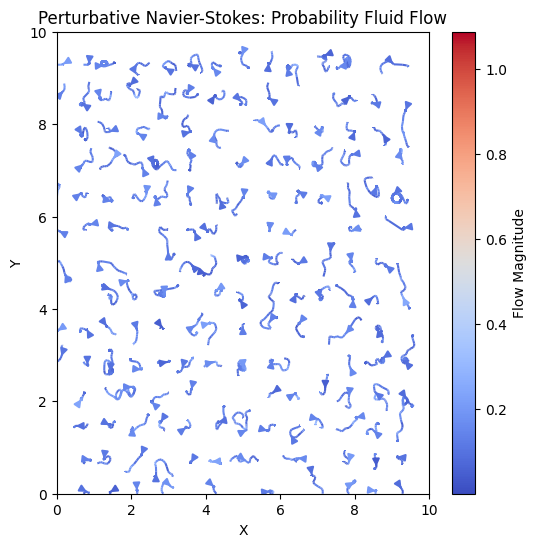

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation grid parameters
nx, ny = 100, 100  # Grid size
dx, dy = 0.1, 0.1  # Spatial step size
dt = 0.001         # Time step
nu_classical = 0.1 # Classical kinematic viscosity

# Quantum viscosity perturbation term (modifiable)
def quantum_viscosity(Q, T, P, rho_grad, S_grad, v_grad):
    """
    Defines the perturbative correction to viscosity based on ensemble parameters.
    - Q: Quantum coherence measure
    - T: Temperature
    - P: Pressure
    - rho_grad: Density gradient
    - S_grad: Entropy gradient
    - v_grad: Velocity gradient
    """
    return 1 + np.exp(-Q) * np.tanh(P * rho_grad) * np.sin(S_grad) / (1 + v_grad**2)

# Initialize velocity and pressure fields
u = np.zeros((nx, ny))  # x-direction velocity
v = np.zeros((nx, ny))  # y-direction velocity
p = np.zeros((nx, ny))  # Pressure

# Random initial condition for turbulence
u += 0.1 * np.random.randn(nx, ny)
v += 0.1 * np.random.randn(nx, ny)

# Compute velocity gradients
def compute_gradients(field, dx, dy):
    """Computes numerical gradients for a given field."""
    dfdx = np.gradient(field, dx, axis=0)
    dfdy = np.gradient(field, dy, axis=1)
    return dfdx, dfdy

# Time evolution function for the modified Navier-Stokes equation
def evolve_ns(Q, T, P, steps=1000):
    """Evolves the velocity field with a quantum viscosity perturbation."""
    global u, v, p

    for _ in range(steps):
        rho_grad_x, rho_grad_y = compute_gradients(u, dx, dy)
        S_grad_x, S_grad_y = compute_gradients(v, dx, dy)
        v_grad_x, v_grad_y = compute_gradients(np.sqrt(u**2 + v**2), dx, dy)

        # Compute viscosity with perturbative quantum correction
        eta_eff = nu_classical * quantum_viscosity(Q, T, P, rho_grad_x, S_grad_x, v_grad_x)

        # Navier-Stokes update equations (simplified)
        u_new = u + dt * (-u * rho_grad_x - v * rho_grad_y + eta_eff * (np.gradient(np.gradient(u, axis=0), axis=0) + np.gradient(np.gradient(u, axis=1), axis=1)))
        v_new = v + dt * (-u * S_grad_x - v * S_grad_y + eta_eff * (np.gradient(np.gradient(v, axis=0), axis=0) + np.gradient(np.gradient(v, axis=1), axis=1)))

        u, v = u_new, v_new  # Update velocity fields

# Run the simulation with an example parameter set
evolve_ns(Q=0.5, T=300, P=1.0, steps=200)

# Visualization
plt.figure(figsize=(6,6))
plt.streamplot(np.linspace(0, nx*dx, nx), np.linspace(0, ny*dy, ny), u.T, v.T, density=0.5, color=np.sqrt(u**2 + v**2), cmap='coolwarm')
plt.title("Perturbative Navier-Stokes: Probability Fluid Flow")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label="Flow Magnitude")
plt.show()


# Symmetrical Light Cone Studies (Exp 2)


<ipython-input-101-4383c6a3558c>:595: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



\begin{tabular}{rrrrrrr}
\toprule
Value & Count & Value/$\alpha$ & nearest_n & Abs Error = $|x - n\alpha|$ & abs_error/$\alpha$ & Pct Error = $\frac{|x - n\alpha|}{n\alpha} \times 100\%$ \\
\midrule
3.676471e-03 & 1 & 5.038088e-01 & 1 & -3.620882e-03 & -4.961912e-01 & 49.62\% \\
7.352941e-03 & 16 & 1.007618e+00 & 1 & 5.558861e-05 & 7.617640e-03 & 0.76\% \\
1.102941e-02 & 18 & 1.511426e+00 & 2 & -3.565293e-03 & -4.885735e-01 & 24.43\% \\
1.470588e-02 & 15 & 2.015235e+00 & 2 & 1.111772e-04 & 1.523528e-02 & 0.76\% \\
1.838235e-02 & 25 & 2.519044e+00 & 3 & -3.509705e-03 & -4.809559e-01 & 16.03\% \\
\bottomrule
\end{tabular}



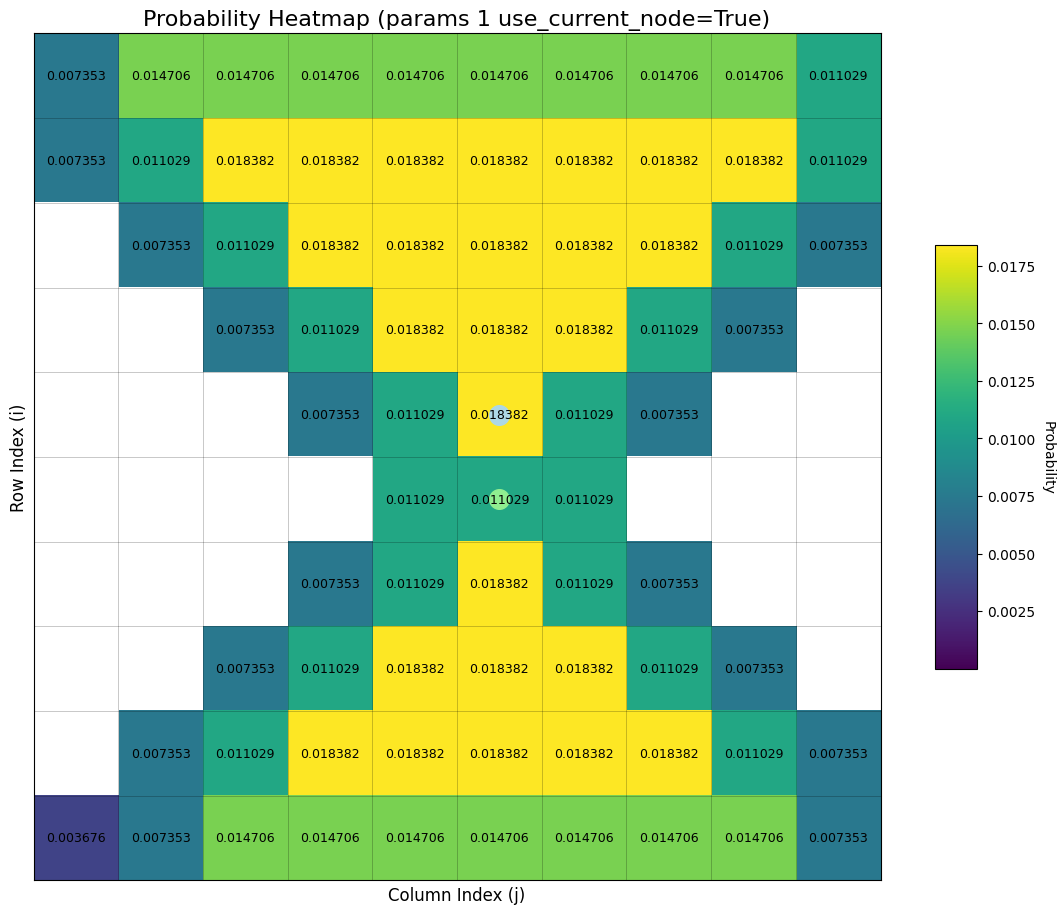

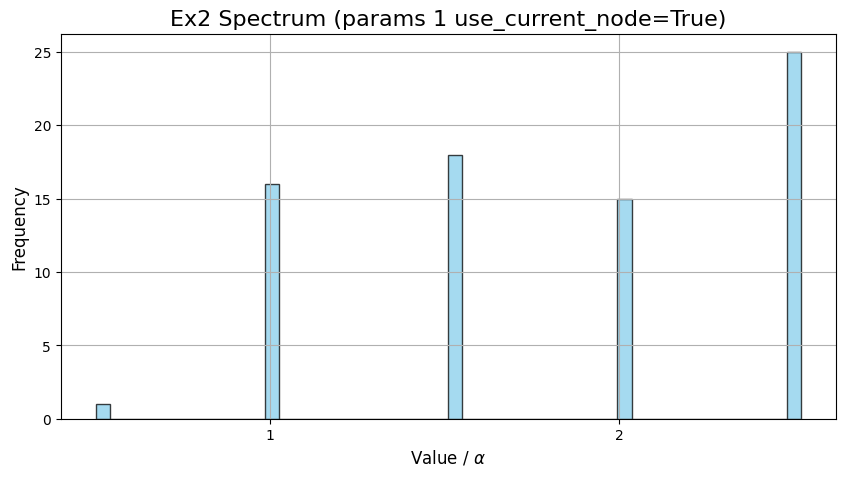

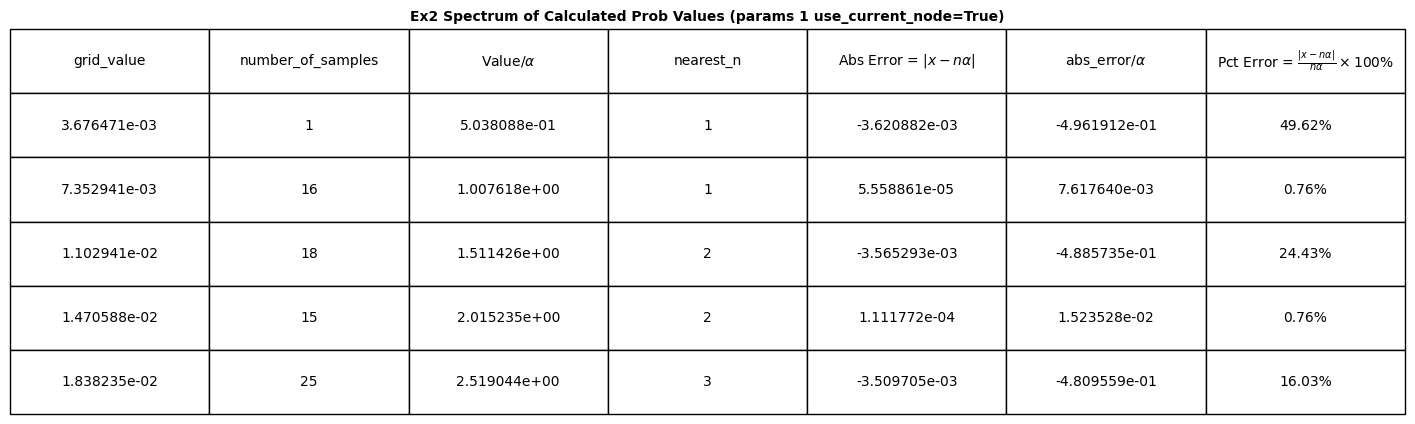

<ipython-input-101-4383c6a3558c>:595: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



\begin{tabular}{rrrrrrr}
\toprule
Value & Count & Value/$\alpha$ & nearest_n & Abs Error = $|x - n\alpha|$ & abs_error/$\alpha$ & Pct Error = $\frac{|x - n\alpha|}{n\alpha} \times 100\%$ \\
\midrule
3.745318e-03 & 1 & 5.132434e-01 & 1 & -3.552034e-03 & -4.867566e-01 & 48.68\% \\
7.490637e-03 & 19 & 1.026487e+00 & 1 & 1.932841e-04 & 2.648688e-02 & 2.65\% \\
1.123596e-02 & 15 & 1.539730e+00 & 2 & -3.358750e-03 & -4.602697e-01 & 23.01\% \\
1.498127e-02 & 17 & 2.052974e+00 & 2 & 3.865683e-04 & 5.297377e-02 & 2.65\% \\
1.872659e-02 & 23 & 2.566217e+00 & 3 & -3.165466e-03 & -4.337828e-01 & 14.46\% \\
\bottomrule
\end{tabular}



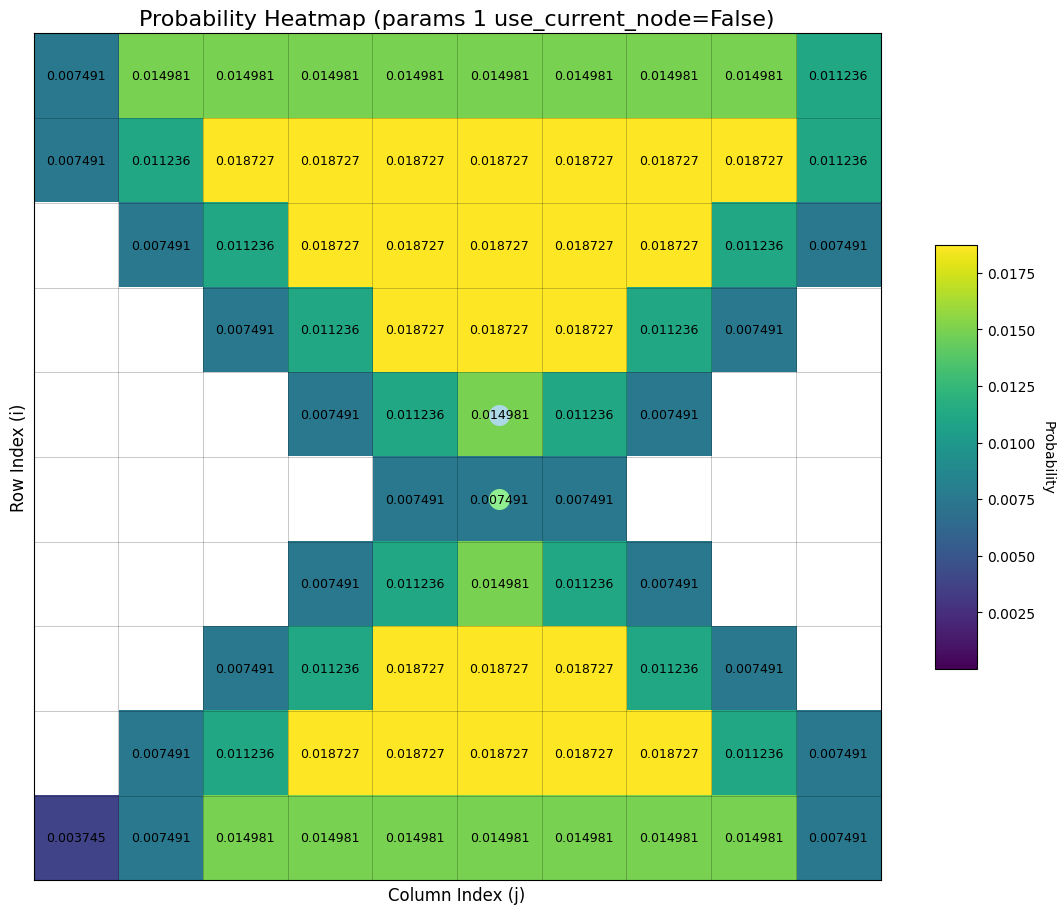

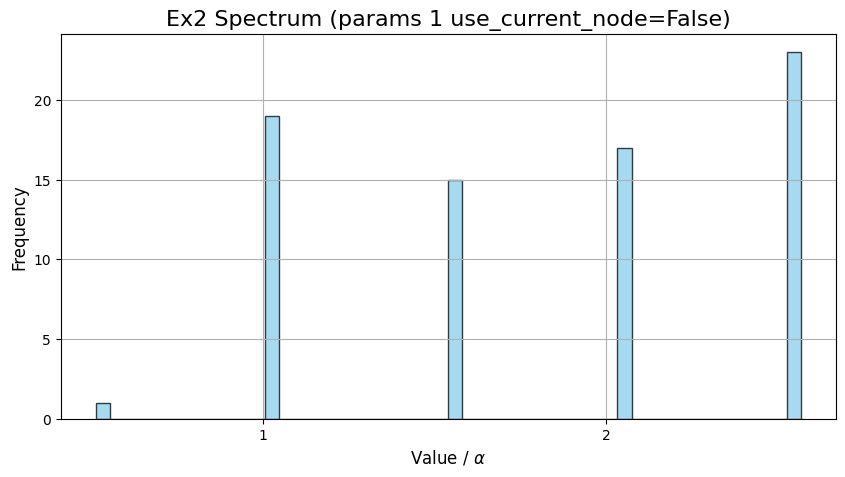

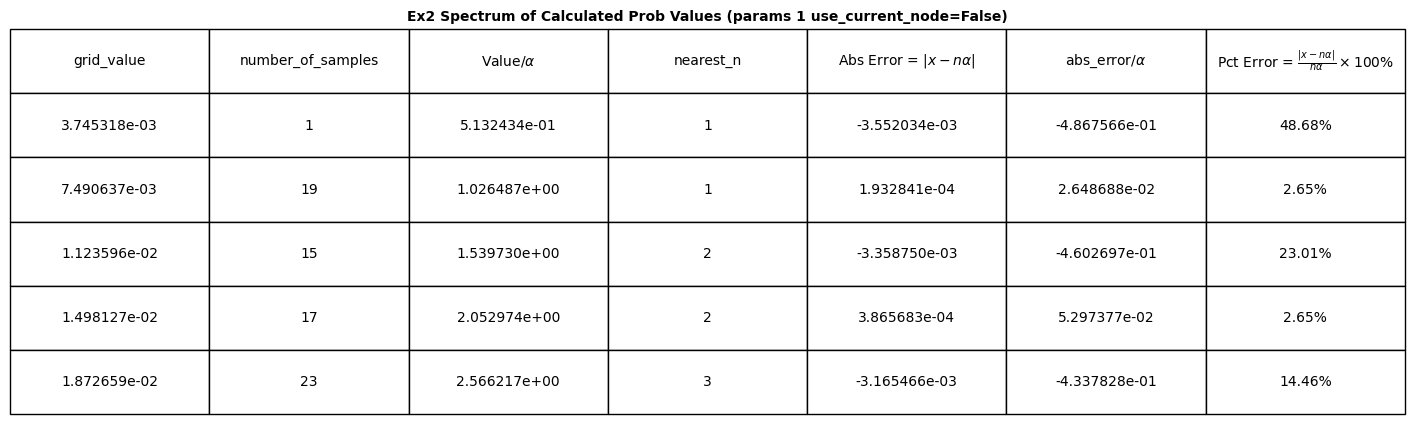

In [ ]:
#Params 1
def main():
    # --- Common Parameters ---
    M, N = 10, 10     # Grid size (rows x columns)
    r = 1             # Kernel radius (modify as needed)
    k = 1.0           # Slope factor for the light cone

    # We'll run two cases: one with use_current_node True, and one with False.
    for use_current_node in [True, False]:
        # --- STEP 1: Create the Grid, Kernel, and Light Cone Masks ---
        # Initialize grid and get the center coordinates.
        inertial_grid, center_i, center_j = initialize_grid(M, N)

        # Create the kernel. (Using the space_filling_lattice version here.)
        kernel = create_space_filling_lattice_kernel(r)
        binary_kernel = kernel.copy()

        # Define the past light cone mask.
        past_cone_mask = define_past_light_cone(M, N, center_i, center_j, k=k)
        # Incorporate the future node based on the observer type.
        observer_type = 'inertial'
        past_light_cone_mask, future_node_mask = add_future_node(
            past_cone_mask, center_i, center_j, observer_type=observer_type
        )
        # Define the future light cone mask using the current node parameter.
        future_cone_mask = define_future_light_cone(
            M, N, center_i, center_j, k=k, include_current_node=use_current_node
        )
        # Combine the past and future light cones.
        light_cone_mask = combine_past_future_light_cones(past_cone_mask, future_cone_mask)

        # --- STEP 2: Compute the Probability Grid and Plot the Heatmap ---
        prob_grid = compute_probability_grid(light_cone_mask, binary_kernel, epsilon=1e-10)

        fig1, ax1 = plt.subplots(figsize=ex2_heatmaps_figsize)
        plot_probability_heatmap(ax1, prob_grid, center_i=center_i, center_j=center_j,
                                 title=f"Probability Heatmap (params 1 use_current_node={use_current_node})")
        #plt.savefig(f"Ex2_p1_heatmap_use_{use_current_node}.pdf", dpi=pdf_dpi)
        #plt.close(fig1)

        # List of grids
        grids = [prob_grid]

        # Plot the spectrum
        fig2, ax_spectrum = plt.subplots(figsize=stats_table_figsize)
        plot_spectrum(ax_spectrum, grids, f"Ex2 Spectrum (params 1 use_current_node={use_current_node})")
        #fig2.savefig(f"Ex2_fig2_spectrum_plot_p1_use_{use_current_node}.pdf", dpi=pdf_dpi)
        #plt.close(fig2)

        # 3. plot the spectrum table
        spectrum_data = tabulate_spectrum(grids)
        #print(spectrum_data)
        fig3, ax_spectrum_table = plt.subplots(figsize=spectrum_table_figsize)
        dispaly_spectrum_table(ax_spectrum_table, spectrum_data, f"Ex2 Spectrum of Calculated Prob Values (params 1 use_current_node={use_current_node})")
        #fig3.savefig(f"Ex2_fig3_spectrum_table_p1_{use_current_node}.pdf", dpi=pdf_dpi)
        #plt.close(fig3)

        # spectrum_data into LaTex table and print
        turn_spectrum_data_into_LaTex(spectrum_data)

        # Show the figure
        plt.show()

if __name__ == "__main__":
    main()


<ipython-input-101-4383c6a3558c>:595: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

<ipython-input-101-4383c6a3558c>:620: RuntimeWarning:

divide by zero encountered in scalar divide



\begin{tabular}{rrrrrrr}
\toprule
Value & Count & Value/$\alpha$ & nearest_n & Abs Error = $|x - n\alpha|$ & abs_error/$\alpha$ & Pct Error = $\frac{|x - n\alpha|}{n\alpha} \times 100\%$ \\
\midrule
2.923977e-03 & 12 & 4.006901e-01 & 0 & 2.923977e-03 & 4.006901e-01 & inf\% \\
5.847953e-03 & 10 & 8.013801e-01 & 1 & -1.449399e-03 & -1.986199e-01 & 19.86\% \\
8.771930e-03 & 4 & 1.202070e+00 & 1 & 1.474577e-03 & 2.020702e-01 & 20.21\% \\
1.169591e-02 & 6 & 1.602760e+00 & 2 & -2.898799e-03 & -3.972398e-01 & 19.86\% \\
1.461988e-02 & 11 & 2.003450e+00 & 2 & 2.517790e-05 & 3.450279e-03 & 0.17\% \\
1.754386e-02 & 4 & 2.404140e+00 & 2 & 2.949155e-03 & 4.041403e-01 & 20.21\% \\
2.046784e-02 & 8 & 2.804830e+00 & 3 & -1.424221e-03 & -1.951696e-01 & 6.51\% \\
2.339181e-02 & 4 & 3.205520e+00 & 3 & 1.499755e-03 & 2.055204e-01 & 6.85\% \\
2.631579e-02 & 6 & 3.606211e+00 & 4 & -2.873621e-03 & -3.937895e-01 & 9.84\% \\
2.923977e-02 & 3 & 4.006901e+00 & 4 & 5.035580e-05 & 6.900558e-03 & 0.17\% \\
3.21637

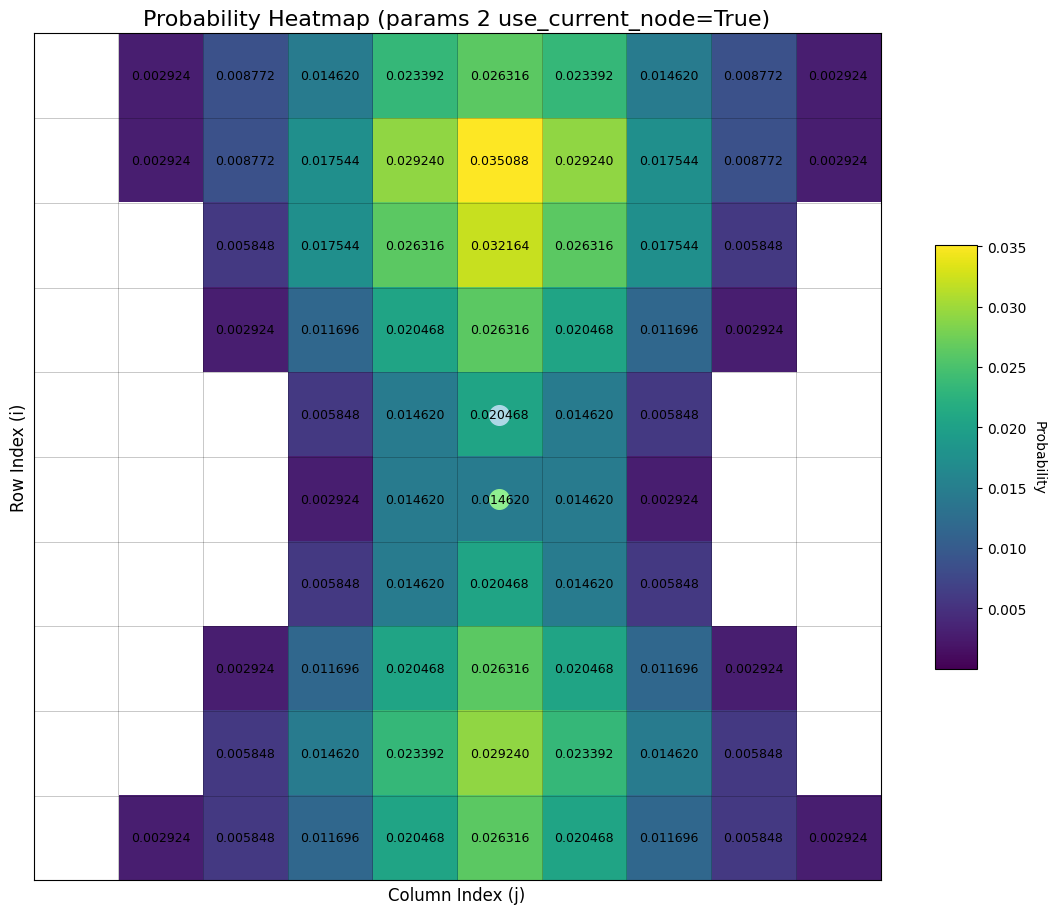

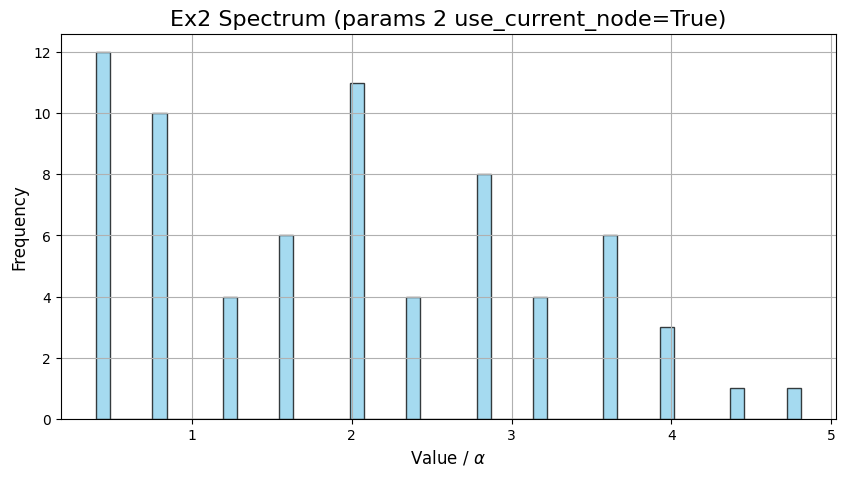

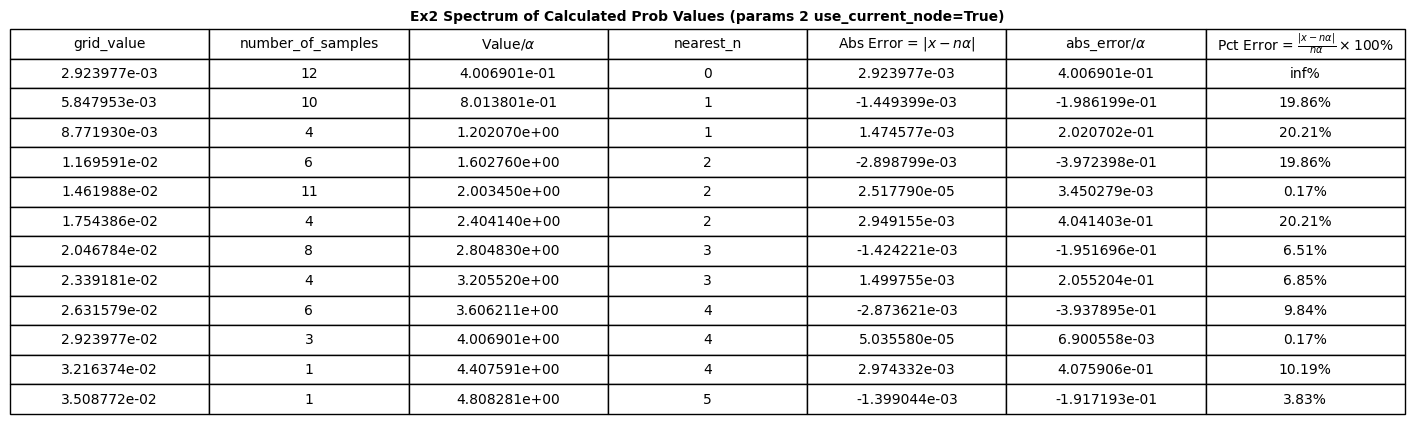

<ipython-input-101-4383c6a3558c>:595: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

<ipython-input-101-4383c6a3558c>:620: RuntimeWarning:

divide by zero encountered in scalar divide



\begin{tabular}{rrrrrrr}
\toprule
Value & Count & Value/$\alpha$ & nearest_n & Abs Error = $|x - n\alpha|$ & abs_error/$\alpha$ & Pct Error = $\frac{|x - n\alpha|}{n\alpha} \times 100\%$ \\
\midrule
3.039514e-03 & 10 & 4.165228e-01 & 0 & 3.039514e-03 & 4.165228e-01 & inf\% \\
6.079027e-03 & 10 & 8.330456e-01 & 1 & -1.218325e-03 & -1.669544e-01 & 16.70\% \\
9.118541e-03 & 4 & 1.249568e+00 & 1 & 1.821188e-03 & 2.495684e-01 & 24.96\% \\
1.215805e-02 & 13 & 1.666091e+00 & 2 & -2.436650e-03 & -3.339088e-01 & 16.70\% \\
1.519757e-02 & 4 & 2.082614e+00 & 2 & 6.028633e-04 & 8.261397e-02 & 4.13\% \\
1.823708e-02 & 6 & 2.499137e+00 & 2 & 3.642377e-03 & 4.991368e-01 & 24.96\% \\
2.127660e-02 & 6 & 2.915660e+00 & 3 & -6.154620e-04 & -8.434045e-02 & 2.81\% \\
2.431611e-02 & 6 & 3.332182e+00 & 3 & 2.424052e-03 & 3.321823e-01 & 11.07\% \\
2.735562e-02 & 4 & 3.748705e+00 & 4 & -1.833787e-03 & -2.512949e-01 & 6.28\% \\
3.039514e-02 & 3 & 4.165228e+00 & 4 & 1.205727e-03 & 1.652279e-01 & 4.13\% \\
3.3434

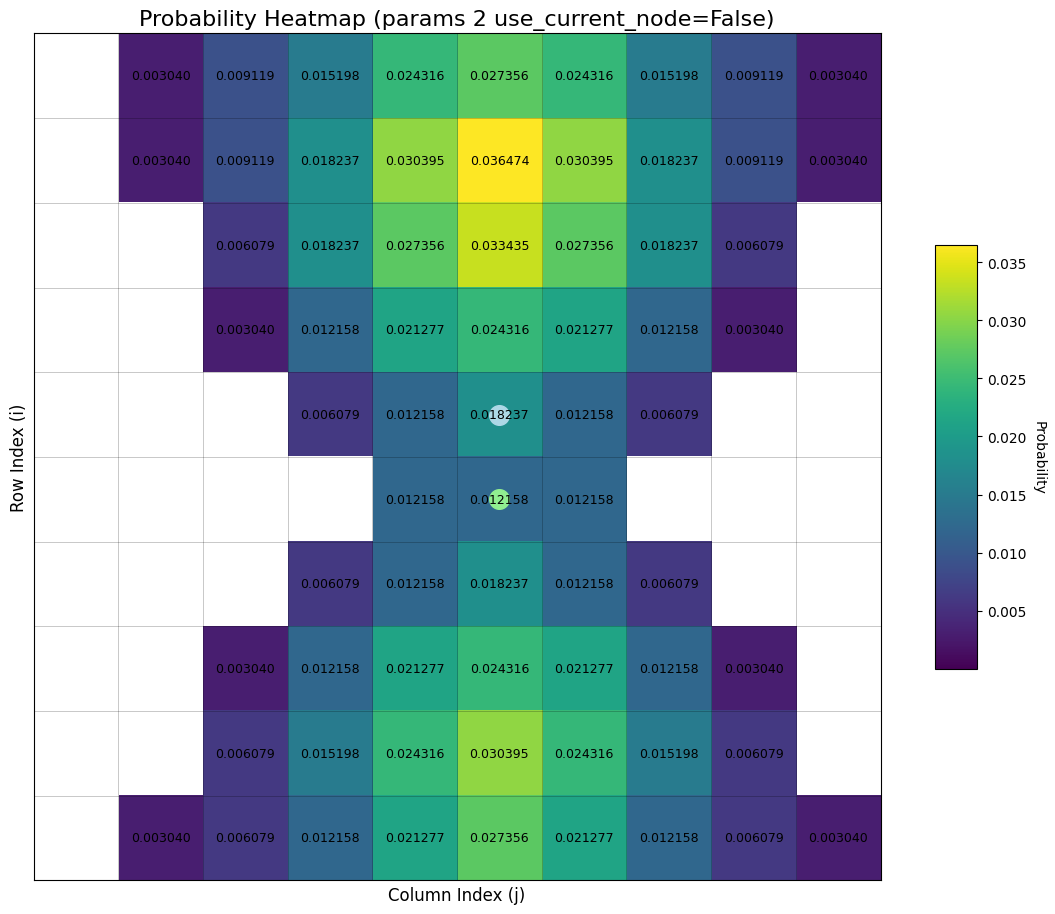

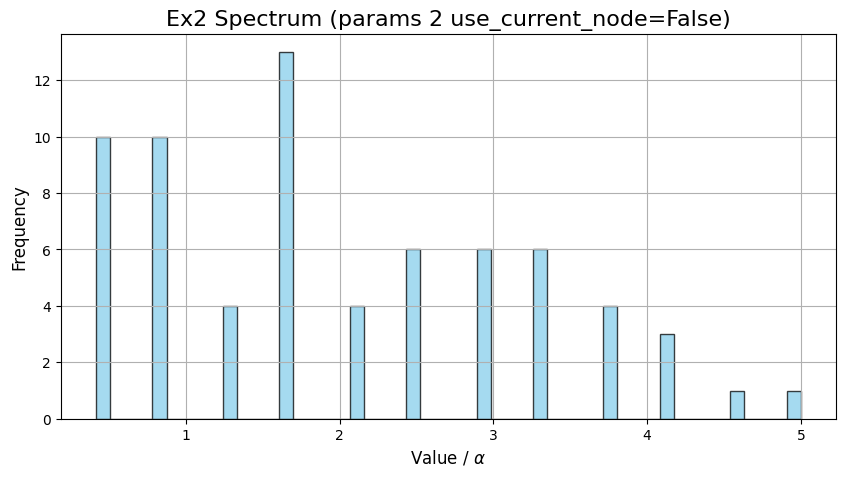

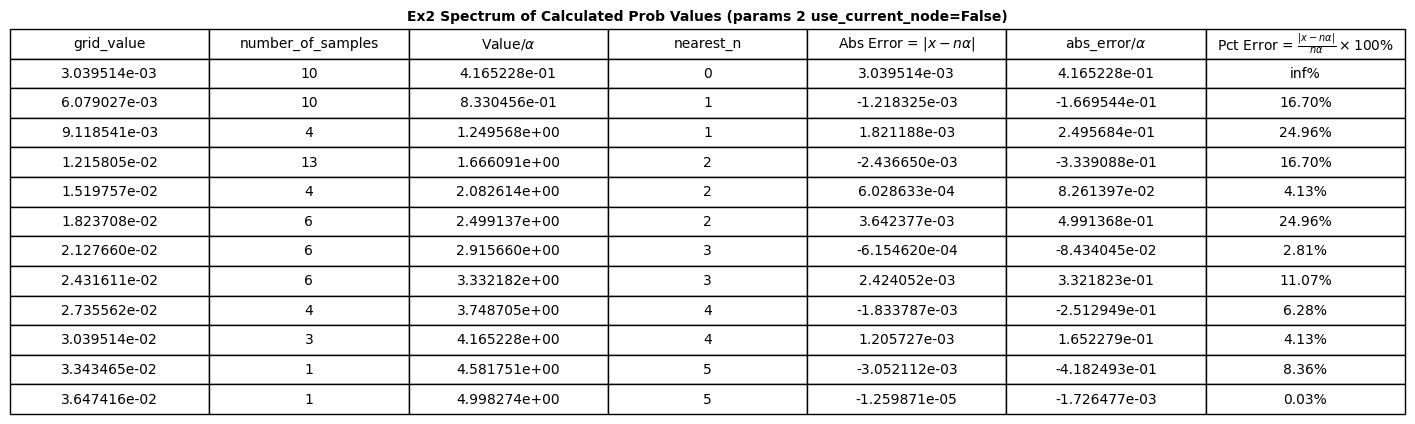

In [ ]:
#Params 2
def main():
    # --- Common Parameters ---
    M, N = 10, 10     # Grid size (rows x columns)
    r = 2             # Kernel radius (modify as needed)
    k = 0.5           # Slope factor for the light cone

    # We'll run two cases: one with use_current_node True, and one with False.
    for use_current_node in [True, False]:
        # --- STEP 1: Create the Grid, Kernel, and Light Cone Masks ---
        # Initialize grid and get the center coordinates.
        inertial_grid, center_i, center_j = initialize_grid(M, N)

        # Create the kernel. (Using the space_filling_lattice version here.)
        kernel = create_space_filling_lattice_kernel(r)
        binary_kernel = kernel.copy()

        # Define the past light cone mask.
        past_cone_mask = define_past_light_cone(M, N, center_i, center_j, k=k)
        # Incorporate the future node based on the observer type.
        observer_type = 'inertial'
        past_light_cone_mask, future_node_mask = add_future_node(
            past_cone_mask, center_i, center_j, observer_type=observer_type
        )
        # Define the future light cone mask using the current node parameter.
        future_cone_mask = define_future_light_cone(
            M, N, center_i, center_j, k=k, include_current_node=use_current_node
        )
        # Combine the past and future light cones.
        light_cone_mask = combine_past_future_light_cones(past_cone_mask, future_cone_mask)

        # --- STEP 2: Compute the Probability Grid and Plot the Heatmap ---
        prob_grid = compute_probability_grid(light_cone_mask, binary_kernel, epsilon=1e-10)

        fig1, ax1 = plt.subplots(figsize=ex2_heatmaps_figsize)
        plot_probability_heatmap(ax1, prob_grid, center_i=center_i, center_j=center_j,
                                 title=f"Probability Heatmap (params 2 use_current_node={use_current_node})")
        #plt.savefig(f"Ex2_p2_heatmap_use_{use_current_node}.pdf", dpi=pdf_dpi)
        #plt.close(fig1)

        # List of grids
        grids = [prob_grid]

        # Plot the spectrum
        fig2, ax_spectrum = plt.subplots(figsize=stats_table_figsize)
        plot_spectrum(ax_spectrum, grids, f"Ex2 Spectrum (params 2 use_current_node={use_current_node})")
        #fig2.savefig(f"Ex2_fig2_spectrum_plot_p2_use_{use_current_node}.pdf", dpi=pdf_dpi)
        #plt.close(fig2)

        # 3. plot the spectrum table
        spectrum_data = tabulate_spectrum(grids)
        #print(spectrum_data)
        fig3, ax_spectrum_table = plt.subplots(figsize=spectrum_table_figsize)
        dispaly_spectrum_table(ax_spectrum_table, spectrum_data, f"Ex2 Spectrum of Calculated Prob Values (params 2 use_current_node={use_current_node})")
        #fig3.savefig(f"Ex2_fig3_spectrum_table_p2_{use_current_node}.pdf", dpi=pdf_dpi)
        #plt.close(fig3)

        # spectrum_data into LaTex table and print
        turn_spectrum_data_into_LaTex(spectrum_data)

        # Show the figure
        plt.show()

if __name__ == "__main__":
    main()


# Data Export Functions

In [ ]:
def export_variables_to_npz(filename="exported_data.npz", **kwargs):
    """
    Saves multiple numpy arrays into a single .npz file for easy sharing.

    Parameters:
    - filename (str): Name of the output .npz file.
    - kwargs: Dictionary of named numpy arrays to store.
    """
    np.savez(filename, **kwargs)
    print(f"Variables successfully saved to {filename}.")


def export_to_npz_google_drive(filename, **arrays):
    """
    Exports multiple numpy arrays to an NPZ file in Google Drive, overwriting if necessary.

    Parameters:
    - filename (str): The filename for the NPZ file (without path).
    - **arrays: Named numpy arrays to save.
    """
    # Define the Google Drive path
    save_path = f"/content/drive/My Drive/RBWData/{filename}"

    if os.path.exists(save_path):
        os.remove(save_path)  # Explicitly remove existing file to ensure overwrite

    np.savez(save_path, **arrays)  # Save new data
    print(f"NPZ file saved to: {save_path}")


def export_variables_to_csv(base_filename="exported_data", **kwargs):
    """
    Saves multiple numpy arrays as CSV files for easy inspection.

    Parameters:
    - base_filename (str): Prefix for the CSV files.
    - kwargs: Dictionary of named numpy arrays to store.
    """
    for name, array in kwargs.items():
        filename = f"{base_filename}_{name}.csv"
        if array.ndim == 2:
            pd.DataFrame(array).to_csv(filename, index=False, header=False)
        elif array.ndim == 1:
            pd.DataFrame(array[:, np.newaxis]).to_csv(filename, index=False, header=False)
        print(f"Saved {name} to {filename}.")

def export_to_csv_google_drive(filename, data):
    """
    Exports a 2D numpy array or pandas DataFrame to a CSV file in Google Drive, overwriting if necessary.

    Parameters:
    - filename (str): The filename for the CSV file (without path).
    - data (numpy.ndarray or pandas.DataFrame): Data to save.
    """
    # Define the Google Drive path
    save_path = f"/content/drive/My Drive/RBWData/{filename}"

    df = pd.DataFrame(data)  # Convert to DataFrame if not already
    df.to_csv(save_path, index=False)  # Overwrites by default

    print(f"CSV file saved to: {save_path}")

# Light Cone DOE

In [ ]:
import numpy as np

# Define the tolerance and target value
#target = 0.01369863
target = 0.0137035999
#tol = 0.00001
tol = 0.000005

def meets_target(prob_grid, target, tol):
    # Return True if at least one value in prob_grid is within tolerance of the target
    return np.any(np.abs(prob_grid - target) <= tol)

#for verification
#M_values = [9]         # Example grid sizes for rows
#N_values = [9]         # Example grid sizes for columns
#r_values = [2]           # Example kernel radii
#k_values = [0.5]     # Example slope factors


# Define the ranges for the parameters
M_values = [9, 11, 13, 15, 17, 19, 21,]         # Example grid sizes for rows
N_values = [9, 11, 13, 15, 17, 19, 21]         # Example grid sizes for columns
r_values = [2, 3, 4, 5, 6]           # Example kernel radii
k_values = [0.5, 0.6, 0.7, 0.9, 1.0, 1.5, 2.0]     # Example slope factors

results = []  # To store the combinations that meet the condition



# Loop over all parameter combinations
for M in M_values:
    for N in N_values:
        for r in r_values:
            for k in k_values:
                print(f"Checking combination: M={M}, N={N}, r={r}, k={k}")

                # Initialize grid and center node (assuming your function returns grid, center_i, center_j)
                inertial_grid, center_i, center_j = initialize_grid(M, N)

                # Generate the kernel (using the space-filling lattice kernel function)
                kernel = create_space_filling_lattice_kernel(r)

                # Define the past light cone mask
                past_cone_mask = define_past_light_cone(M, N, center_i, center_j, k=k)
                # Augment the mask by adding the inertial next event
                light_cone_mask, future_node_mask = add_future_node(past_cone_mask, center_i, center_j, observer_type='inertial')

                # Compute the probability grid
                prob_grid = compute_probability_grid(light_cone_mask, kernel, epsilon=1e-10)

                # Check if any value in the probability grid meets the target condition
                if meets_target(prob_grid, target, tol):
                    # Find the indices and values that match
                    matching_indices = np.where(np.abs(prob_grid - target) <= tol)
                    matching_values = prob_grid[matching_indices]
                    count_matches = matching_values.size  # count how many matching values
                    results.append({
                        "M": M,
                        "N": N,
                        "r": r,
                        "k": k,
                        "indices": matching_indices,
                        "values": matching_values,
                        "count": count_matches
                    })
                    print(f"Match found for M={M}, N={N}, r={r}, k={k}")
                    print("Matching probability values:", matching_values)
                    print("Number of matching values:", count_matches)

# Report results
if results:
    print("\nParameter combinations that yield a probability value within the target range:")
    for res in results:
        print(res)
else:
    print("No parameter combinations produced a probability value within the target range.")


# Process the results list to convert arrays into strings for CSV output
output_data = []
for res in results:
    row = {
        "M": res["M"],
        "N": res["N"],
        "r": res["r"],
        "k": res["k"],
        "count": res["count"],
        # Convert indices and values to a string representation
        "indices": str(res["indices"]),
        "values": str(res["values"])
    }
    output_data.append(row)

# Create a DataFrame from the results and write it out as a CSV
df = pd.DataFrame(output_data)
df.to_csv("doe_results.csv", index=False)

print("Results dumped to doe_results.csv")


Checking combination: M=9, N=9, r=2, k=0.5
Match found for M=9, N=9, r=2, k=0.5
Matching probability values: [0.01369863 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863
 0.01369863]
Number of matching values: 7
Checking combination: M=9, N=9, r=2, k=0.6
Match found for M=9, N=9, r=2, k=0.6
Matching probability values: [0.01369863 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863
 0.01369863]
Number of matching values: 7
Checking combination: M=9, N=9, r=2, k=0.7
Checking combination: M=9, N=9, r=2, k=0.9
Checking combination: M=9, N=9, r=2, k=1.0
Checking combination: M=9, N=9, r=2, k=1.5
Checking combination: M=9, N=9, r=2, k=2.0
Checking combination: M=9, N=9, r=3, k=0.5
Checking combination: M=9, N=9, r=3, k=0.6
Checking combination: M=9, N=9, r=3, k=0.7
Checking combination: M=9, N=9, r=3, k=0.9
Checking combination: M=9, N=9, r=3, k=1.0
Checking combination: M=9, N=9, r=3, k=1.5
Checking combination: M=9, N=9, r=3, k=2.0
Checking combination: M=9, N=9, r=4, k=0.5
Check

In [ ]:
import numpy as np
import pandas as pd

# Define the tolerance and target probability
target = 0.01369
tol = 0.0000005

def meets_target(prob_grid, target, tol):
    """Returns True if at least one probability in prob_grid is within tolerance of target."""
    return np.any(np.abs(prob_grid - target) <= tol)


def check_next_event(prob_grid, center_i, center_j):
    """
    Checks if the next event node contains the target probability value.

    Returns:
        - Boolean indicating if it matches.
        - Probability value at the next event node.
    """
    next_i = center_i - 1  # Assuming forward in time direction
    next_j = center_j

    if 0 <= next_i < prob_grid.shape[0] and 0 <= next_j < prob_grid.shape[1]:
        next_event_prob = prob_grid[next_i, next_j]
        if abs(next_event_prob - target) <= tol:
            return True, next_event_prob
    return False, None

def run_design_of_experiments(M_range, N_range, r_range, k_range):
    """
    Runs a design of experiments over a range of M, N, r, and k values.
    Handles ranges or fixed values for each parameter.

    Parameters:
        - M_range: (min, max, step) for M (rows) OR a fixed value
        - N_range: (min, max, step) for N (columns) OR a fixed value
        - r_range: (min, max, step) for kernel radius OR a fixed value
        - k_range: (min, max, step) for light cone slope OR a fixed value

    Outputs:
        - Prints matched results
        - Saves results to a CSV file ("doe_results.csv")
    """

    # Generate parameter values using np.arange for ranges, or use the fixed value
    if isinstance(M_range, tuple):
        M_values = np.arange(M_range[0], M_range[1], M_range[2])
    else:
        M_values = [M_range]

    if isinstance(N_range, tuple):
        N_values = np.arange(N_range[0], N_range[1], N_range[2])
    else:
         N_values = [N_range]

    if isinstance(r_range, tuple):
        r_values = np.arange(r_range[0], r_range[1], r_range[2])
    else:
        r_values = [r_range]

    if isinstance(k_range, tuple):
        k_values = np.arange(k_range[0], k_range[1], k_range[2])
    else:
        k_values = [k_range]


    results = []  # Store results

    # Loop over all combinations of M, N, r, k
    for M in M_values:
        for N in N_values:
            for r in r_values:
                for k in k_values:
                    print(f"Checking: M={M}, N={N}, r={r}, k={k}")

                    # Initialize grid and center node
                    inertial_grid, center_i, center_j = initialize_grid(M, N)

                    # Generate the kernel
                    kernel = create_space_filling_lattice_kernel(r)

                    # Define the past light cone mask
                    past_cone_mask = define_past_light_cone(M, N, center_i, center_j, k=k)
                    light_cone_mask, future_node_mask = add_future_node(past_cone_mask, center_i, center_j, observer_type='inertial')

                    # Compute the probability grid
                    prob_grid = compute_probability_grid(light_cone_mask, kernel, epsilon=1e-10)


                    # Check for target probability match anywhere in the grid
                    match_found = meets_target(prob_grid, target, tol)
                    matching_indices = np.where(np.abs(prob_grid - target) <= tol) if match_found else None
                    matching_values = prob_grid[matching_indices] if match_found else None
                    count_matches = matching_values.size if match_found else 0

                    # Check if the next event node contains the fun number
                    next_event_match, next_event_value = check_next_event(prob_grid, center_i, center_j)

                    results.append({
                        "M": M, "N": N, "r": r, "k": k,
                        "count": count_matches,
                        "indices": str(matching_indices) if match_found else "None",
                        "values": str(matching_values) if match_found else "None",
                        "next_event_has_fun_number": next_event_match,  # New column
                        "next_event_value": next_event_value if next_event_match else "None"
                    })
                    # Check if the next event node contains the fun number
                    next_event_match, next_event_value = check_next_event(prob_grid, center_i, center_j)

                    results.append({
                        "M": M, "N": N, "r": r, "k": k,
                        "count": count_matches,
                        "indices": str(matching_indices) if match_found else "None",
                        "values": str(matching_values) if match_found else "None",
                        "next_event_has_fun_number": next_event_match,  # New column
                        "next_event_value": next_event_value if next_event_match else "None"
                    })

                    if match_found:
                        print(f"Match found! M={M}, N={N}, r={r}, k={k}, Count={count_matches}")

                    if next_event_match:
                        print(f"Fun number found in next event! M={M}, N={N}, r={r}, k={k}, Value={next_event_value}")
                        print(f"Match found! M={M}, N={N}, r={r}, k={k}, Count={count_matches}")

    # Save results to a CSV file
    if results:
        df = pd.DataFrame(results)
        df.to_csv("doe_results.csv", index=False)
        print("Results saved to doe_results.csv")
    else:
        print("No matching parameter sets found.")

run_design_of_experiments(
    M_range=(9, 100, 1),     # M values from 9 to 100, stepping by 2
    N_range=(9, 100, 1),     # N values from 9 to 100, stepping by 2
    r_range=(2,10,1),          # r is fixed at 2.0
    k_range=(0.5,10,0.5)            # k is fixed at 1.0
)

Streaming output truncated to the last 5000 lines.
Checking: M=99, N=67, r=2, k=9.0
Checking: M=99, N=67, r=2, k=9.5
Checking: M=99, N=67, r=3, k=0.5
Checking: M=99, N=67, r=3, k=1.0
Checking: M=99, N=67, r=3, k=1.5
Checking: M=99, N=67, r=3, k=2.0
Checking: M=99, N=67, r=3, k=2.5
Checking: M=99, N=67, r=3, k=3.0
Checking: M=99, N=67, r=3, k=3.5
Checking: M=99, N=67, r=3, k=4.0
Checking: M=99, N=67, r=3, k=4.5
Checking: M=99, N=67, r=3, k=5.0
Checking: M=99, N=67, r=3, k=5.5
Checking: M=99, N=67, r=3, k=6.0
Checking: M=99, N=67, r=3, k=6.5
Checking: M=99, N=67, r=3, k=7.0
Checking: M=99, N=67, r=3, k=7.5
Checking: M=99, N=67, r=3, k=8.0
Checking: M=99, N=67, r=3, k=8.5
Checking: M=99, N=67, r=3, k=9.0
Checking: M=99, N=67, r=3, k=9.5
Checking: M=99, N=67, r=4, k=0.5
Checking: M=99, N=67, r=4, k=1.0
Checking: M=99, N=67, r=4, k=1.5
Checking: M=99, N=67, r=4, k=2.0
Checking: M=99, N=67, r=4, k=2.5
Checking: M=99, N=67, r=4, k=3.0
Checking: M=99, N=67, r=4, k=3.5
Checking: M=99, N=67, r=4

In [ ]:
import numpy as np
import pandas as pd

# Define the tolerance and target probability
target = 0.01369
tol = 0.0000005

def meets_target(prob_grid, target, tol):
    """Returns True if at least one probability in prob_grid is within tolerance of target."""
    return np.any(np.abs(prob_grid - target) <= tol)

def check_next_event(prob_grid, center_i, center_j):
    """
    Checks if the next event node contains the target probability value.

    Returns:
        - Boolean indicating if it matches.
        - Probability value at the next event node.
    """
    next_i = center_i - 1  # Assuming forward in time direction
    next_j = center_j

    if 0 <= next_i < prob_grid.shape[0] and 0 <= next_j < prob_grid.shape[1]:
        next_event_prob = prob_grid[next_i, next_j]
        if abs(next_event_prob - target) <= tol:
            return True, next_event_prob
    return False, None

def run_design_of_experiments(M_range, N_range, r_range, k_range):
    """
    Runs a design of experiments over a range of M, N, r, and k values.

    Parameters:
        - M_range: (min, max, step) for M (rows)
        - N_range: (min, max, step) for N (columns)
        - r_range: (min, max, step) for kernel radius
        - k_range: (min, max, step) for light cone slope
        - step: common step size (optional override for all ranges)

    Outputs:
        - Prints matched results
        - Saves results to a CSV file ("doe_results.csv")
    """

    # Generate parameter values using np.arange (ensures equal stepping)
    M_values = np.arange(*M_range, step)
    N_values = np.arange(*N_range, step)
    r_values = np.arange(*r_range, step)
    k_values = np.arange(*k_range, step)

    results = []  # Store results
    next_event_results = []  # Store results where the next event node matches

    # Loop over all combinations of M, N, r, k
    for M in M_values:
        for N in N_values:
            for r in r_values:
                for k in k_values:
                    print(f"Checking: M={M}, N={N}, r={r}, k={k}")

                    # Initialize grid and center node
                    inertial_grid, center_i, center_j = initialize_grid(M, N)

                    # Generate the kernel
                    kernel = create_space_filling_lattice_kernel(r)

                    # Define the past light cone mask
                    past_cone_mask = define_past_light_cone(M, N, center_i, center_j, k=k)
                    light_cone_mask, future_node_mask = add_future_node(past_cone_mask, center_i, center_j, observer_type='inertial')

                    # Compute the probability grid
                    prob_grid = compute_probability_grid(light_cone_mask, kernel, epsilon=1e-10)

                    # Check for target probability match anywhere in the grid
                    if meets_target(prob_grid, target, tol):
                        matching_indices = np.where(np.abs(prob_grid - target) <= tol)
                        matching_values = prob_grid[matching_indices]
                        count_matches = matching_values.size

                        results.append({
                            "M": M, "N": N, "r": r, "k": k,
                            "count": count_matches,
                            "indices": str(matching_indices),
                            "values": str(matching_values)
                        })
                        print(f"Match found! M={M}, N={N}, r={r}, k={k}, Count={count_matches}")

                    # Check if the next event node contains the fun number
                    next_event_match, next_event_value = check_next_event(prob_grid, center_i, center_j)
                    if next_event_match:
                        next_event_results.append({
                            "M": M, "N": N, "r": r, "k": k,
                            "next_event_value": next_event_value
                        })
                        print(f"Fun number found in next event! M={M}, N={N}, r={r}, k={k}, Value={next_event_value}")

    # Save results to a CSV file
    if results:
        df = pd.DataFrame(results)
        df.to_csv("doe_results.csv", index=False)
        print("Results saved to doe_results.csv")

    # Save next event matches separately
    if next_event_results:
        df_next = pd.DataFrame(next_event_results)
        df_next.to_csv("doe_next_event_results.csv", index=False)
        print("Next event matches saved to doe_next_event_results.csv")
    else:
        print("No matching parameter sets found.")


run_design_of_experiments(
    M_range=(9, 15, 2),     # M values from 9 to 15, stepping by 2
    N_range=(9, 15, 2),     # N values from 9 to 15, stepping by 2
    r_range=(2, 5, 1),      # r values from 2 to 5, stepping by 1
    k_range=(0.5, 0.8, 0.1) # k values from 0.5 to 0.8, stepping by 0.1
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

# Assume these functions are defined elsewhere in your notebook:
# - initialize_grid(M, N)
# - create_space_filling_lattice_kernel(r)
# - define_past_light_cone(M, N, center_i, center_j, k)
# - add_future_node(past_cone_mask, center_i, center_j, observer_type)
# - compute_probability_grid(light_cone_mask, kernel, epsilon)

def plot_probability_spectrum(prob_grid, M, N, r):
    """
    Plots a histogram of probability values from the computed probability grid.
    """
    plt.figure()
    # Flatten the grid to 1D and create a histogram of the probability values
    plt.hist(prob_grid.flatten(), bins=50, color='blue', edgecolor='black')
    plt.title(f'Probability Spectrum (M={M}, N={N}, r={r})')
    plt.xlabel('Probability Value')
    plt.ylabel('Frequency')
    plt.show()

def design_of_experiments():
    # Define a list of parameter sets to explore
    parameter_sets = [
        {"M": 9, "N": 9, "r": 2, "k": 0.5},
        {"M": 9, "N": 9, "r": 3, "k": 0.5},
        {"M": 11, "N": 11, "r": 3, "k": 0.5},
        # Add additional parameter sets as needed
    ]

    for params in parameter_sets:
        M = params["M"]
        N = params["N"]
        r = params["r"]
        k = params["k"]

        # Initialize the grid and get the center node indices
        inertial_grid, center_i, center_j = initialize_grid(M, N)

        # Generate the kernel (using your space-filling lattice kernel function)
        kernel = create_space_filling_lattice_kernel(r)
        # (If needed, enforce binary values: binary_kernel = (kernel > 0).astype(np.int8))

        # Define the past light cone mask for the inertial observer
        past_cone_mask = define_past_light_cone(M, N, center_i, center_j, k=k)
        # Augment the mask by adding the inertial next event
        light_cone_mask, future_node_mask = add_future_node(past_cone_mask, center_i, center_j, observer_type='inertial')

        # Compute the probability grid via convolution
        prob_grid = compute_probability_grid(light_cone_mask, kernel, epsilon=1e-10)

        # Plot the spectrum (frequency distribution) of probability values
        plot_probability_spectrum(prob_grid, M, N, r)

if __name__ == "__main__":
    design_of_experiments()


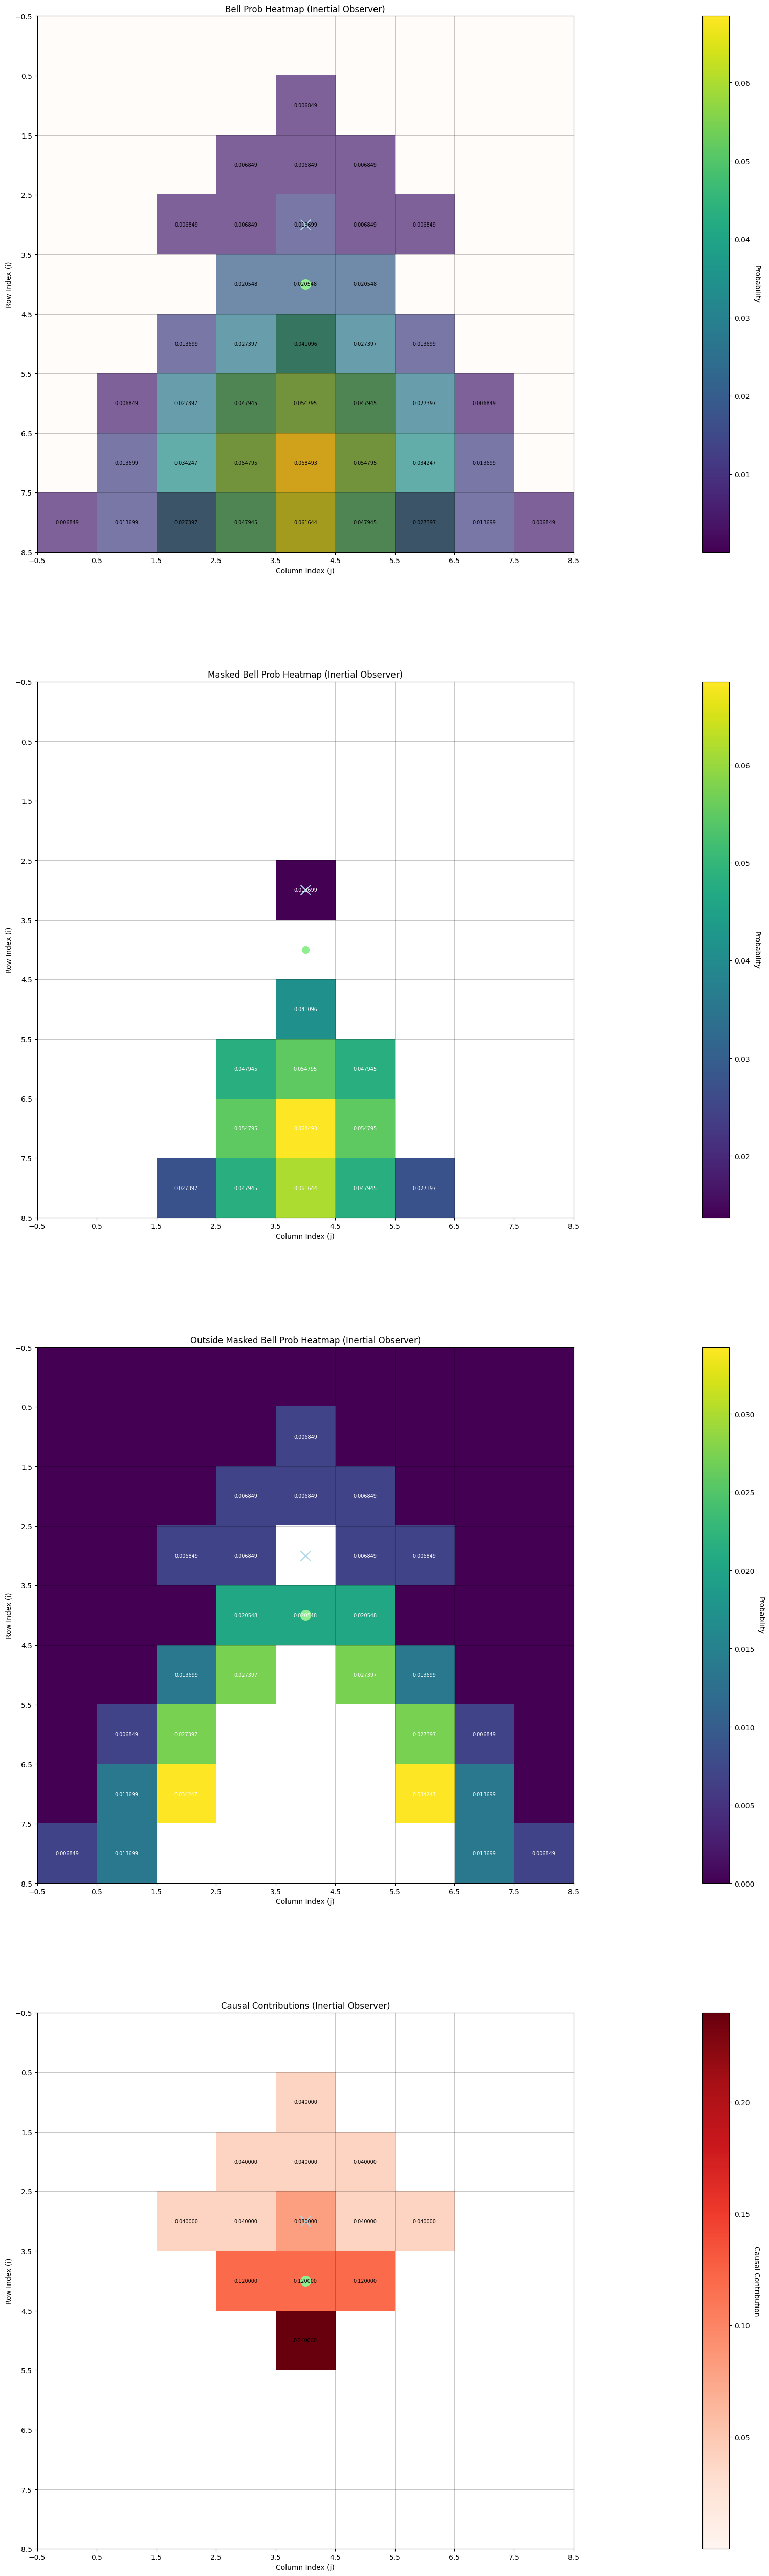

In [ ]:
#Note depends on functions from Current Light Cone Studies

def main():
    # Fine Structure Constant Coincidence - Parameters
    #M, N = 10, 10  # Grid size (rows x columns)
    #M, N = 9, 9  # Grid size (rows x columns)
    #r = 2          # Radius of the uniform Euclidean kernel
    #k = 0.5        # Slope factor for the light cone

    # Test Params
    M, N = 9, 9  # Grid size (rows x columns)
    r = 2          # Radius of the uniform Euclidean kernel
    k = 0.5        # Slope factor for the light cone

    # Initialize grid and center node
    inertial_grid, center_i, center_j = initialize_grid(M, N)

    # Define the kernel
    #kernel = create_uniform_euclidean_kernel(r)
    kernel = create_space_filling_lattice_kernel(r)
    binary_kernel = kernel.copy()


    # Scenario 1: Inertial Observer
    observer_type_1 = 'inertial'
    past_cone_mask_1 = define_past_light_cone(M, N, center_i, center_j, k=k)
    #past_cone_mask_1 = define_adaptive_light_cone(M, N, center_i, center_j, k=k)
    light_cone_mask_1, future_node_mask_1 = add_future_node(past_cone_mask_1, center_i, center_j, observer_type=observer_type_1)
    prob_grid_1 = compute_probability_grid(light_cone_mask_1, kernel, epsilon=1e-10)


    # Compute statistics for both observers
    stats_inertial = verify_probabilities(prob_grid_1, light_cone_mask_1, observer_type_1)

    # Combine statistics into dictionaries for the tables
    stats_table_outside = {
        "Inertial": stats_inertial["Outside"],
        #"Accelerating": stats_accelerating["Outside"]
    }

    stats_table_inside = {
        "Inertial": stats_inertial["Inside"],
        #"Accelerating": stats_accelerating["Inside"]
    }


    # Compute contribution maps
    contribution_from_prob_1 = compute_causal_contributions_from_prob_grid(
        prob_grid_1, kernel, center_i, center_j, observer_type='inertial'
    )


    # Visualization -----------------------------------------
    # Create a figure with GridSpec for arranged subplots and tables
    fig = plt.figure(figsize=(65, 125), constrained_layout=True)

    # Update to 9 rows; adjust height ratios as needed
    gs = gridspec.GridSpec(9, 1, height_ratios=[1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 0.5, 0.5, 0.5], hspace=0.3, wspace=0.1)


    # Row 2: Probability Heatmaps
    ax3 = fig.add_subplot(gs[1, 0])
    plot_probability_heatmap(ax3, prob_grid_1, past_cone_mask=past_cone_mask_1, future_node_mask=future_node_mask_1,
                            center_i=center_i, center_j=center_j, observer_type=observer_type_1, title="Bell Prob Heatmap (Inertial Observer)")


    # Row 3: Masked Probability Heatmaps (Inside PLC)
    ax5 = fig.add_subplot(gs[2, 0])
    plot_masked_probability_heatmap(ax5, prob_grid_1, past_cone_mask=past_cone_mask_1, future_node_mask=future_node_mask_1,
                                    center_i=center_i, center_j=center_j, observer_type=observer_type_1, title="Masked Bell Prob Heatmap (Inertial Observer)")


    # Row 4: Masked Probability Heatmaps (Outside PLC)
    ax7 = fig.add_subplot(gs[3, 0])
    plot_outside_mask_probability_heatmap(ax7, prob_grid_1, past_cone_mask=past_cone_mask_1, future_node_mask=future_node_mask_1,
                                          center_i=center_i, center_j=center_j, observer_type=observer_type_1, title="Outside Masked Bell Prob Heatmap (Inertial Observer)")

    # Row 5 (NEW): Causal Contributions Heatmaps
    ax9 = fig.add_subplot(gs[4, 0])
    plot_causal_contributions_heatmap(ax9, contribution_from_prob_1, center_i, center_j, 'inertial',
                                      title="Causal Contributions (Inertial Observer)")


    # Show the figure
    plt.show()


if __name__ == "__main__":
    main()


# Lorentz Factor Studies


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def count_incidence_inertial(grid_size):
    """
    Counts the number of nearest time-like steps in the inertial frame.
    """
    count = 1  # The standard single step forward in time (i=1, j=0)
    return count

def count_incidence_boosted(grid_size):
    """
    Counts the number of new time-like steps in the accelerated frame,
    where time steps require some spatial offset.
    """
    count = 2  # Two mixed time-space steps needed (i=1, j=1 and i=2, j=2)
    return count

def compute_gamma(inertial_count, boosted_count):
    """
    Computes the discrete Lorentz factor gamma as the ratio of old to new time steps.
    """
    return inertial_count / boosted_count

def main():
    grid_size = 10  # Define grid size

    # Count incidence relationships
    inertial_incidence = count_incidence_inertial(grid_size)
    boosted_incidence = count_incidence_boosted(grid_size)

    # Compute Lorentz gamma factor
    gamma = compute_gamma(inertial_incidence, boosted_incidence)

    print("Inertial time-like step count:", inertial_incidence)
    print("Boosted time-like step count:", boosted_incidence)
    print("Computed Lorentz factor (gamma):", gamma)

    return gamma

if __name__ == "__main__":
    gamma = main()


Inertial time-like step count: 1
Boosted time-like step count: 2
Computed Lorentz factor (gamma): 0.5


# Modified Minkowski Diagram

In [ ]:
# Define the axes
arrow_length = 0.7  # Adjusted to fit range [0, 1]
angle_t_t_prime = 20  # 20-degree angle between t (z-axis) and t'
x_axis = [arrow_length, 0, 0]  # x-axis
t_axis = [0, 0, arrow_length]  # t-axis (now z-axis)
t_prime_axis = [
    0,
    np.cos(np.radians(angle_t_t_prime)) * arrow_length,
    np.sin(np.radians(angle_t_t_prime)) * arrow_length
]  # t'-axis (rotated)

# Create 3D plot
fig = go.Figure()

# Define the 45° x,t plane extending along t' (y-axis)
x_vals_45 = np.linspace(0, arrow_length, 10)  # x-values along the plane
y_vals_45 = np.linspace(0, 1, 10)  # Extend along y-axis (t')
x_plane_45, y_plane_45 = np.meshgrid(x_vals_45, y_vals_45)
z_plane_45 = x_plane_45  # z = x for the 45° x,z plane

# Add the 45° x,t plane to the plot
fig.add_trace(go.Surface(
    x=x_plane_45,
    y=y_plane_45,
    z=z_plane_45,
    colorscale='Reds',
    opacity=0.5,
    showscale=False,
    name='45° x,t plane'
))

# Define the x, t' plane
x_vals_t_prime = np.linspace(0, arrow_length, 10)  # x-values along the plane
y_vals_t_prime = np.linspace(0, 1, 10)  # Full range along the y-axis
x_plane_t_prime, y_plane_t_prime = np.meshgrid(x_vals_t_prime, y_vals_t_prime)
z_plane_t_prime = y_plane_t_prime * np.tan(np.radians(angle_t_t_prime))  # Calculate z-coordinates from t' angle

# Add the x, t' plane to the plot
fig.add_trace(go.Surface(
    x=x_plane_t_prime,
    y=y_plane_t_prime,
    z=z_plane_t_prime,
    colorscale='Blues',
    opacity=0.5,
    showscale=False,
    name='x, t\' plane'
))

# Define points in the y,z plane
points_yz = [
    {"y": 0.3, "z": 0.6},  # Point 1
    {"y": 0.5, "z": 0.3}   # Point 2
]

# Calculate intersection points on the 45° x,z plane
intersection_points = []
for point in points_yz:
    intersection_x = point["z"]  # On the 45° plane, x = z
    intersection_y = point["y"]  # y remains the same
    intersection_z = intersection_x  # z = x for the 45° plane
    intersection_points.append({"x": intersection_x, "y": intersection_y, "z": intersection_z})

# Add the intersection points to the plot
for i, intersection in enumerate(intersection_points, start=1):
    fig.add_trace(go.Scatter3d(
        x=[intersection["x"]], y=[intersection["y"]], z=[intersection["z"]],
        mode='markers',
        marker=dict(color='orange', size=5),
        text=f"Intersection {i}",
        textposition="top center",
        name=f"Intersection Point {i}"
    ))

    # Add dashed lines connecting the y,z points to the intersection points
    original_point = points_yz[i - 1]
    fig.add_trace(go.Scatter3d(
        x=[0, intersection["x"]],  # From the y,z plane (x=0) to the intersection
        y=[original_point["y"], intersection["y"]],  # Maintain the y-coordinate
        z=[original_point["z"], intersection["z"]],  # From z to intersection
        mode='lines',
        line=dict(color='orange', width=2, dash='dash'),
        name=f"Line to Intersection {i}"
    ))

# Add the points and dashed lines to the 45° x,z plane
for i, point in enumerate(points_yz, start=1):
    # Plot the point on the y,z plane
    fig.add_trace(go.Scatter3d(
        x=[0], y=[point["y"]], z=[point["z"]],
        mode='markers+text',
        marker=dict(color='green', size=5),
        text=f"Event {i}",
        textposition="top center",
        name=f"Event {i}"
    ))

    # Calculate the intersection on the 45° x,z plane
    intersection_x = point["z"]  # Since the plane is at 45° in the x,z plane (z = x)
    fig.add_trace(go.Scatter3d(
        x=[0, intersection_x],  # From the y,z plane (x=0) to the intersection
        y=[point["y"], point["y"]],  # Maintain the y-coordinate
        z=[point["z"], intersection_x],  # From z to intersection
        mode='lines',
        line=dict(color='green', width=2, dash='dash'),
        name=f"Line to 45° x,z plane from Point {i}"
    ))

# Main axes
fig.add_trace(go.Scatter3d(
    x=[0, x_axis[0]], y=[0, x_axis[1]], z=[0, x_axis[2]],
    mode='lines+text',
    line=dict(color='black', width=5),
    text=["", "x"],
    textposition="top center",
    name='x-axis'
))
fig.add_trace(go.Scatter3d(
    x=[0, t_axis[0]], y=[0, t_axis[1]], z=[0, t_axis[2]],
    mode='lines+text',
    line=dict(color='black', width=5),
    text=["", "t"],
    textposition="top center",
    name='z-axis (t-axis)'
))
fig.add_trace(go.Scatter3d(
    x=[0, t_prime_axis[0]], y=[0, t_prime_axis[1]], z=[0, t_prime_axis[2]],
    mode='lines+text',
    line=dict(color='gray', width=5),
    text=["", "t'"],
    textposition="top center",
    name="t'-axis"
))

# Calculate intersection points on the x,t' plane
intersection_points_xt_prime = []
for point in intersection_points:
    y = point["y"]  # y remains the same
    z = y * np.tan(np.radians(angle_t_t_prime))  # z = y * tan(20°)
    x = z  # x = z for the 45° x,z plane
    intersection_points_xt_prime.append({"x": x, "y": y, "z": z})

# Add the intersection points on the x,t' plane to the plot
for i, intersection in enumerate(intersection_points_xt_prime, start=1):
    fig.add_trace(go.Scatter3d(
        x=[intersection["x"]], y=[intersection["y"]], z=[intersection["z"]],
        mode='markers',
        marker=dict(color='blue', size=5),
        text=f"x,t' {i}",
        textposition="top center",
        name=f"x,t' Point {i}"
    ))

    # Add dashed lines connecting the 45° plane intersection points to the x,t' plane intersection points
    prev_point = intersection_points[i - 1]
    fig.add_trace(go.Scatter3d(
        x=[prev_point["x"], intersection["x"]],  # From 45° plane to x,t' plane
        y=[prev_point["y"], intersection["y"]],
        z=[prev_point["z"], intersection["z"]],
        mode='lines',
        line=dict(color='blue', width=2, dash='dash'),
        name=f"Line to x,t' Plane {i}"
    ))

# Define the intersection line of the 45° x,z plane and x,t' plane
y_vals_intersection = np.linspace(0, 1, 50)  # Full range of y
z_vals_intersection = y_vals_intersection * np.tan(np.radians(angle_t_t_prime))  # z from x,t' plane
x_vals_intersection = z_vals_intersection  # x = z for 45° x,z plane

# Add the dashed intersection line to the plot
fig.add_trace(go.Scatter3d(
    x=x_vals_intersection,
    y=y_vals_intersection,
    z=z_vals_intersection,
    mode='lines',
    line=dict(color='purple', width=4, dash='dash'),
    name="c'"
))


# Draw dashed lines from the intersection points on the 45° plane to the 45° line in the x,z plane
for i, point in enumerate(intersection_points, start=1):
    # Calculate the projection onto the 45° line in x,z plane (z = x, y = 0)
    x_projection = point["x"]  # x-coordinate remains the same
    z_projection = point["z"]  # z = x for the 45° line
    y_projection = 0  # y = 0 on the 45° line

    # Add the dashed line
    fig.add_trace(go.Scatter3d(
        x=[point["x"], x_projection],  # From the point on the 45° plane to the 45° line
        y=[point["y"], y_projection],  # y-coordinate to 0
        z=[point["z"], z_projection],  # z-coordinate remains the same
        mode='lines',
        line=dict(color='purple', width=2, dash='dash'),
        name=f"Line to 45° Line {i}"
    ))

# Add lines in the x,z plane from the 45° line endpoints to the x-axis
for i, point in enumerate(intersection_points, start=1):
    # Calculate the endpoint on the 45° line in x,z plane (z = x, y = 0)
    x_endpoint = point["x"]  # x-coordinate remains the same
    z_endpoint = point["z"]  # z = x for the 45° line
    y_endpoint = 0  # y = 0 on the 45° line

    # Add a line from the 45° line endpoint to the x-axis
    fig.add_trace(go.Scatter3d(
        x=[x_endpoint, x_endpoint],  # x-coordinate remains constant
        y=[y_endpoint, y_endpoint],  # y-coordinate remains constant at 0
        z=[z_endpoint, 0],  # From z to 0
        mode='lines',
        line=dict(color='blue', width=2, dash='dash'),
        name=f"Line to x-axis {i}"
    ))

# Define a line on the x,z plane at 45 degrees
x_vals_c = np.linspace(0, arrow_length, 10)  # x-values for the 45° line
z_vals_c = x_vals_c  # z = x for 45° line
y_vals_c = np.zeros_like(x_vals_c)  # y = 0 for the x,z plane

# Add the 45° line to the plot
fig.add_trace(go.Scatter3d(
    x=x_vals_c,
    y=y_vals_c,
    z=z_vals_c,
    mode='lines+text',
    line=dict(color='darkgrey', width=4),
    text=[""] * (len(x_vals_c) - 1) + ["c"],  # Label the line at the end
    textposition="top right",
    name="45° Line (c)"
))


# Layout
fig.update_layout(
    width=2000,  # Set the desired width of the canvas
    height=900,   # Set the desired height of the canvas
    scene=dict(
    aspectmode='manual',  # Enables manual control of the aspect ratio
        aspectratio=dict(
            x=1,  # Relative scaling for x-axis
            y=0.85,  # Relative scaling for y-axis
            z=1   # Relative scaling for z-axis
        ),
        xaxis=dict(range=[0, 1],tickvals=[],title=''),
        yaxis=dict(range=[0, 1],tickvals=[],title=''),
        zaxis=dict(range=[0, 1],tickvals=[],title='')
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

# Show the plot
fig.show()


# Feedback Path Studies

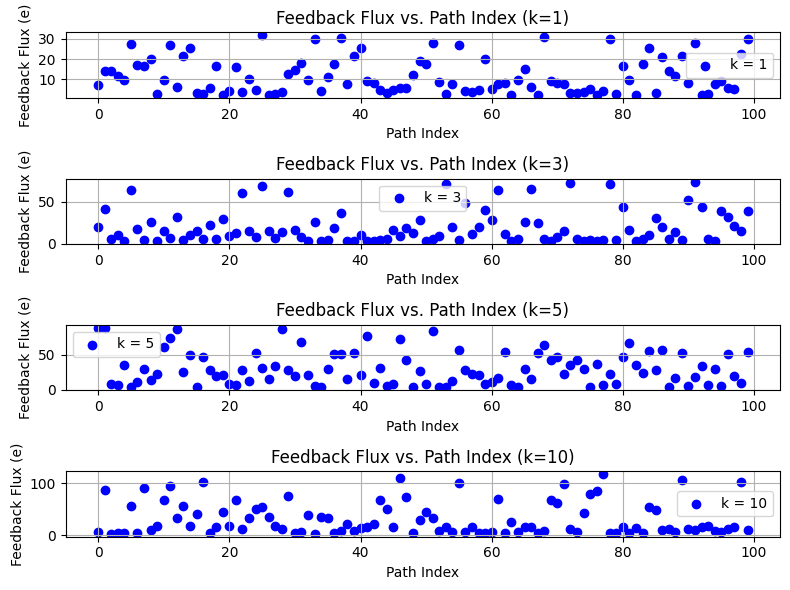

In [ ]:
# Parameters
a = 1   # Scaling factor for the base information content h
b = 1   # Decay factor
k_values = [1, 3, 5, 10]  # Different numbers of event paths (k)
n_paths = 100  # Number of event paths
c_min = 1.2  # Minimum value for c
c_max = 5.0  # Maximum value for c

# Initialize figure for plotting
fig, axes = plt.subplots(len(k_values), 1, figsize=(8, 6))

# Simulate for each k value
for i, k in enumerate(k_values):
    c_values = np.random.uniform(c_min, c_max, n_paths)  # Random values for c
    e_values = np.zeros(n_paths)

    for j in range(n_paths):
        # Calculate e_i for each path
        e_values[j] = (a + 1 / (b * k)) ** (c_values[j] * k)

    # Plot the results
    axes[i].scatter(range(n_paths), e_values, label=f'k = {k}', color='b')
    axes[i].set_title(f'Feedback Flux vs. Path Index (k={k})')
    axes[i].set_xlabel('Path Index')
    axes[i].set_ylabel('Feedback Flux (e)')
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()
plt.show()

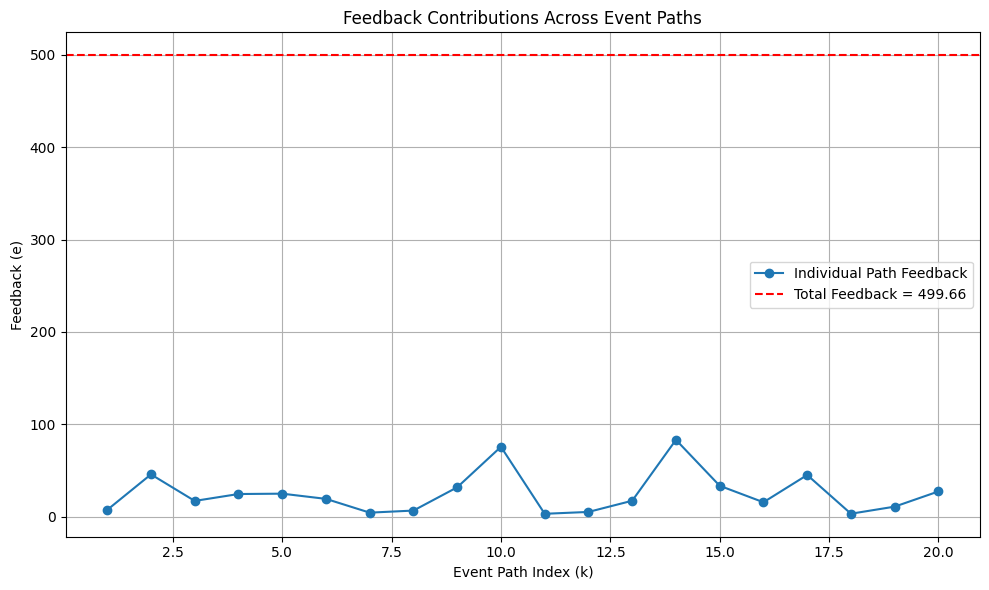

In [ ]:
# Parameters
a = 1  # Scaling factor for the base term
b = 1  # Decay factor
n_paths = 20  # Number of paths (n)
k_values = np.arange(1, n_paths + 1)  # Path indices
random_c = np.random.uniform(1, 5, size=n_paths)  # Randomized c values for each path

# Calculate the total feedback for each path
feedback_values = []

for i in range(n_paths):
    e_i = (a + 1 / (b * k_values[i]))**(random_c[i] * k_values[i])
    feedback_values.append(e_i)

# Calculate the total feedback across all paths
total_feedback = np.sum(feedback_values)

# Plotting the individual feedback contributions and the total feedback
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(k_values, feedback_values, label="Individual Path Feedback", marker='o')
ax.axhline(y=total_feedback, color='r', linestyle='--', label=f"Total Feedback = {total_feedback:.2f}")

# Set labels and title
ax.set_xlabel("Event Path Index (k)")
ax.set_ylabel("Feedback (e)")
ax.set_title("Feedback Contributions Across Event Paths")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


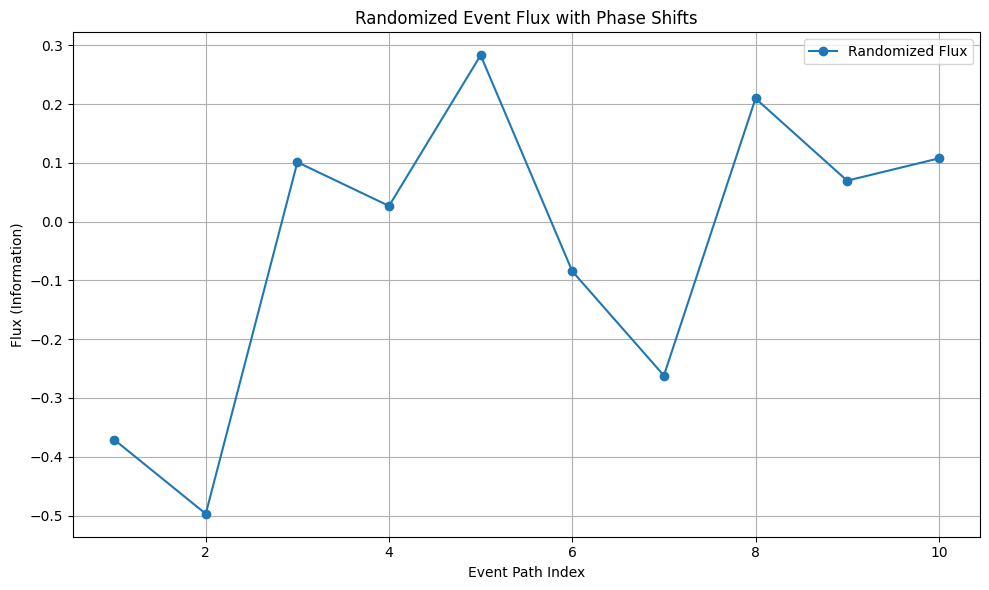

In [ ]:
# Parameters
gamma = 0.02  # Decay rate
n_values = 30  # Number of steps (nodes)
n_paths = 10  # Number of paths to consider

# Random values for r_i (random phase shifts between 0 and 1)
r_values = np.random.rand(n_paths)

# Generate distances and event indices
distances = np.linspace(1, 100, n_paths)
n_indices = np.arange(1, n_paths + 1)

# Create a figure for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate the flux for each path
flux_values = []
for i in range(n_paths):
    flux = np.exp(-gamma * distances[i]) * np.cos(np.pi * n_indices[i] + r_values[i] * np.pi)  # Flux for each path
    flux_values.append(flux)

# Plot the flux
ax.plot(n_indices, flux_values, label="Randomized Flux", marker='o')

# Set labels and title
ax.set_xlabel("Event Path Index")
ax.set_ylabel("Flux (Information)")
ax.set_title("Randomized Event Flux with Phase Shifts")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()


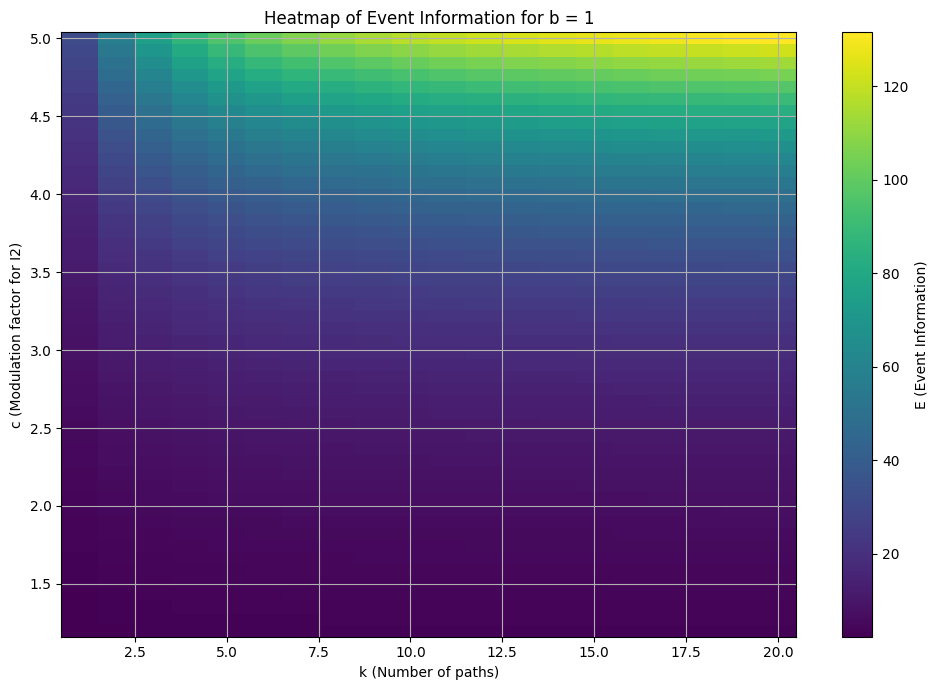

In [ ]:
# Constants
a = 1  # Keeping a fixed unit value for simplicity
h = 1  # Planck's constant (normalized)
b = 1  # Set decay constant for this plot
k_values = np.arange(1, 21)  # Number of paths in I1 (1 to 20)
c_values = np.linspace(1.2, 5, 50)  # Modulation of I2 (more fine-grained range)

# Create meshgrid for k and c
k_grid, c_grid = np.meshgrid(k_values, c_values)

# Calculate E values
E_values = (a*h + h/(b*k_grid))**(c_grid*k_grid)

# Create a figure for the heatmap
fig, ax = plt.subplots(figsize=(10, 7))

# Create the heatmap
cmap = cm.viridis
heatmap = ax.pcolormesh(k_grid, c_grid, E_values, shading='auto', cmap=cmap)
fig.colorbar(heatmap, ax=ax, label='E (Event Information)')

# Set axis labels and title
ax.set_xlabel('k (Number of paths)')
ax.set_ylabel('c (Modulation factor for I2)')
ax.set_title(f'Heatmap of Event Information for b = {b}')

# Add grid and colorbar
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


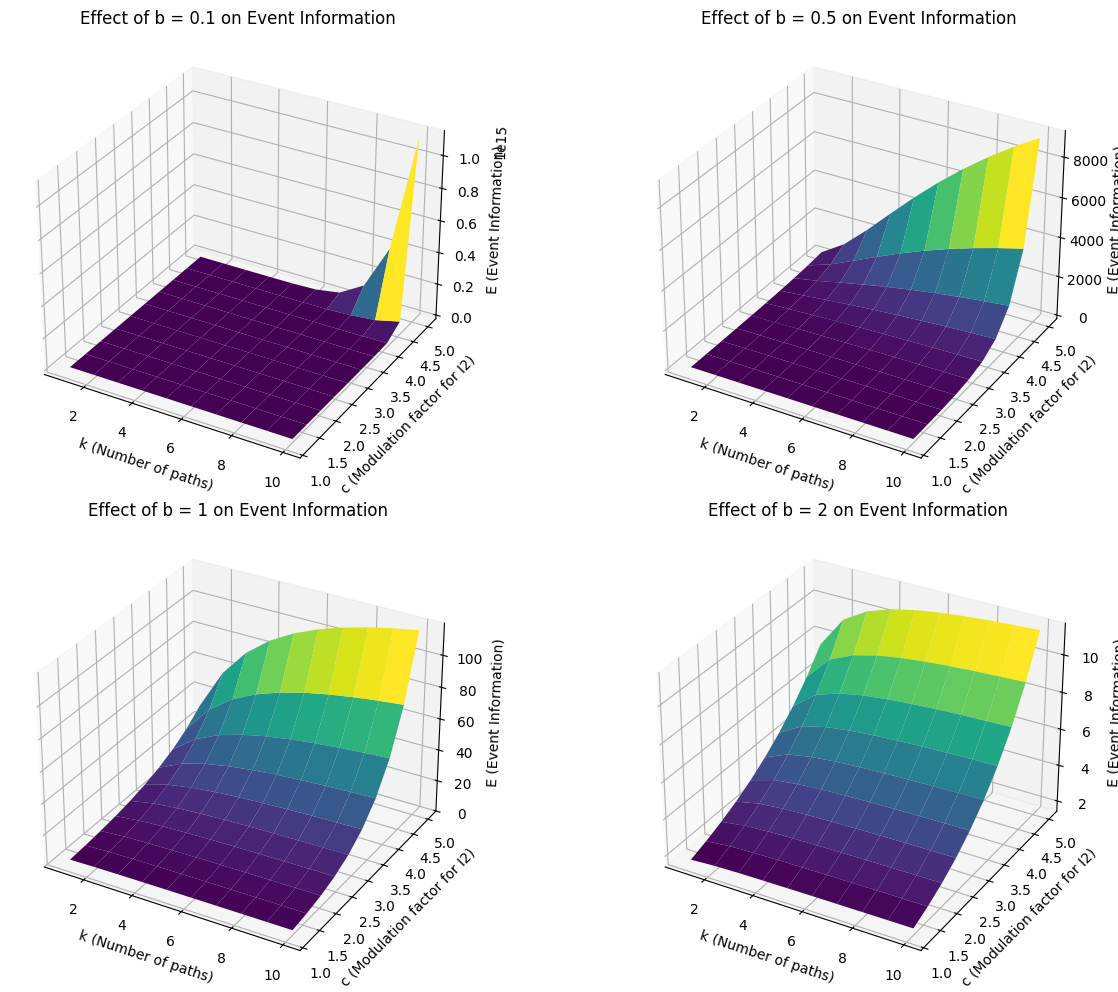

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Constants
a = 1  # Keeping a fixed unit value for simplicity
h = 1  # Planck's constant (normalized)
b_values = [0.1, 0.5, 1, 2]  # Decay values to vary
k_values = np.arange(1, 11)  # Number of paths in I1 (1 to 10)
c_values = np.linspace(1.2, 5, 10)  # Modulation of I2

# Create figure
fig = plt.figure(figsize=(14, 10))

# Create 3D plots
for idx, b in enumerate(b_values):
    # Prepare meshgrid for k and c
    k_grid, c_grid = np.meshgrid(k_values, c_values)
    E_values = (a*h + h/(b*k_grid))**(c_grid*k_grid)

    # Create 3D axis for each decay factor b
    ax = fig.add_subplot(2, 2, idx + 1, projection='3d')
    ax.plot_surface(k_grid, c_grid, E_values, cmap='viridis')

    # Set labels and titles
    ax.set_xlabel('k (Number of paths)')
    ax.set_ylabel('c (Modulation factor for I2)')
    ax.set_zlabel('E (Event Information)')
    ax.set_title(f'Effect of b = {b} on Event Information')

plt.tight_layout()
plt.show()


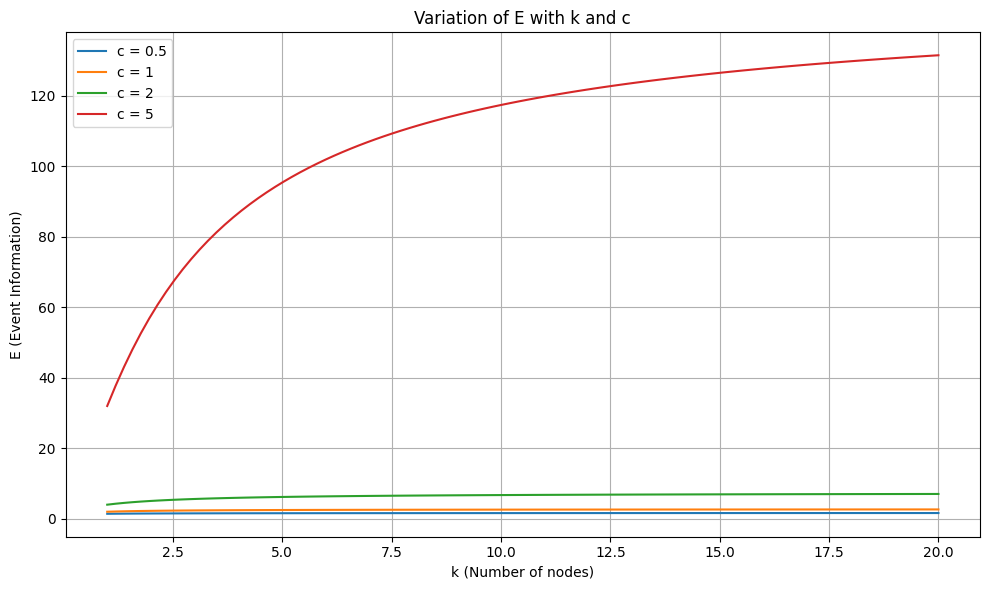

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function for E
def E_function(a, b, k, c):
    return (a * 1 + (1 / (b * k)))**(c * k)

# Set parameters for the plot
a = 1  # Set a to 1 for unitary basis
b = 1  # Set b to 1 for no decay
k_values = np.linspace(1, 20, 100)  # Vary k from 1 to 20
c_values = [0.5, 1, 2, 5]  # Different values of c

# Create the plot
plt.figure(figsize=(10, 6))

# Plot for different values of c
for c in c_values:
    E_values = E_function(a, b, k_values, c)
    plt.plot(k_values, E_values, label=f'c = {c}')

# Add labels and title
plt.title('Variation of E with k and c')
plt.xlabel('k (Number of nodes)')
plt.ylabel('E (Event Information)')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


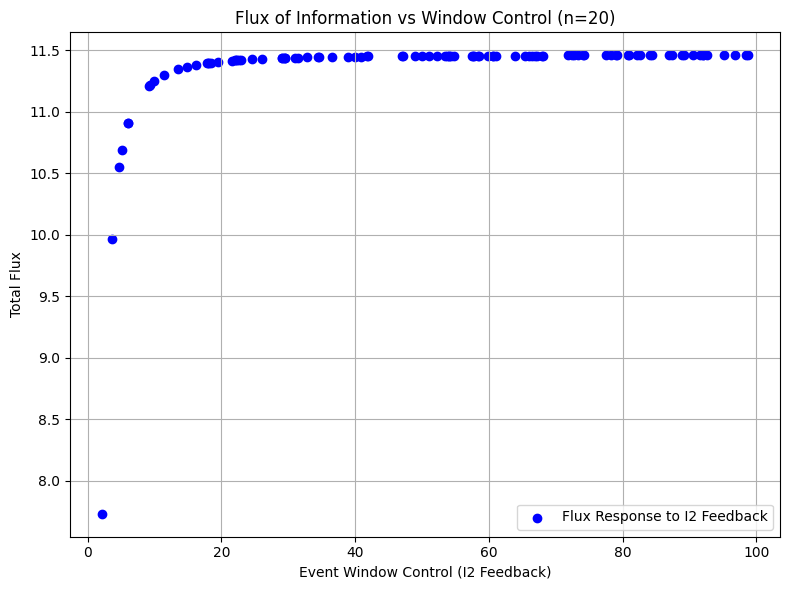

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma = 0.02  # Decay rate
n_steps = 100  # Number of steps for simulating the passage of time
n = 20  # Event path length for this single path scenario
N_max = 50  # Maximum path length in the future (for simulation)

# Create figure for plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Define random multiplicative factors for each new event to simulate I2 feedback
multiplicative_factors = np.random.uniform(1, 100, n_steps)  # Random factors for each step

# Initialize flux values
total_flux = np.zeros(n_steps)

# Loop through steps to calculate the flux for each event path
for step in range(n_steps):
    # Scale N_i by the multiplicative factor at each step
    N_i = N_max * multiplicative_factors[step]  # Path length with scaling factor
    # Sum of decaying oscillations from the future with more events considered
    total_flux[step] = np.sum(np.exp(-gamma * np.linspace(0, n * np.pi, n)) * np.cos(np.pi * np.linspace(0, n * np.pi, n) / N_i))

# Plot the total flux response to the event window control
ax.scatter(multiplicative_factors, total_flux, label='Flux Response to I2 Feedback', color="blue")
ax.set_title(f'Flux of Information vs Window Control (n={n})')
ax.set_ylabel('Total Flux')
ax.set_xlabel('Event Window Control (I2 Feedback)')
ax.grid(True)
ax.legend()

plt.tight_layout()  # Adjust subplots to fit within the figure area
plt.show()


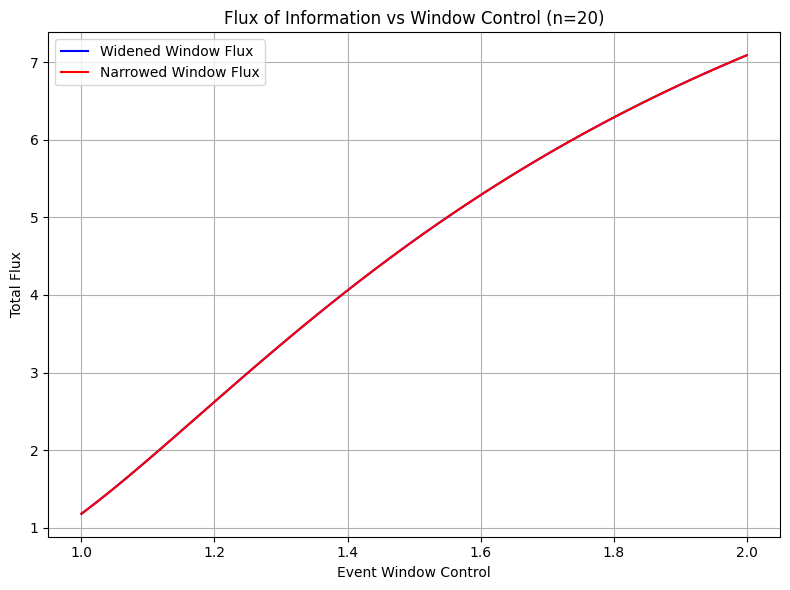

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma = 0.02  # Decay rate
n_steps = 100  # Number of steps for simulating the passage of time
n = 20  # Event path length for this single path scenario
N_max = 50  # Maximum path length in the future (for simulation)

# Create figure for plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Define the event window operations (widening or narrowing)
widen_factor = np.linspace(1, 2, n_steps)  # Factor for widening window over time
narrow_factor = np.linspace(2, 1, n_steps)  # Factor for narrowing window over time

# Compute the total flux for both widening and narrowing window scenarios
total_flux_widen = np.zeros(n_steps)
total_flux_narrow = np.zeros(n_steps)

# Loop to compute the flux for widening the window (adding more events)
for step in range(n_steps):
    N_i = N_max * widen_factor[step]  # Increasing number of events in the window
    # Sum of decaying oscillations from the future
    total_flux_widen[step] = np.sum(np.exp(-gamma * np.linspace(0, n * np.pi, n)) * np.cos(np.pi * np.linspace(0, n * np.pi, n) / N_i))

# Loop to compute the flux for narrowing the window (removing events)
for step in range(n_steps):
    N_i = N_max * narrow_factor[step]  # Decreasing number of events in the window
    # Sum of decaying oscillations from the future
    total_flux_narrow[step] = np.sum(np.exp(-gamma * np.linspace(0, n * np.pi, n)) * np.cos(np.pi * np.linspace(0, n * np.pi, n) / N_i))

# Plot the widening and narrowing flux operations
ax.plot(widen_factor, total_flux_widen, label=f'Widened Window Flux', color="blue")
ax.plot(narrow_factor, total_flux_narrow, label=f'Narrowed Window Flux', color="red")
ax.set_title(f'Flux of Information vs Window Control (n={n})')
ax.set_ylabel('Total Flux')
ax.set_xlabel('Event Window Control')
ax.grid(True)
ax.legend()

plt.tight_layout()  # Adjust subplots to fit within the figure area
plt.show()


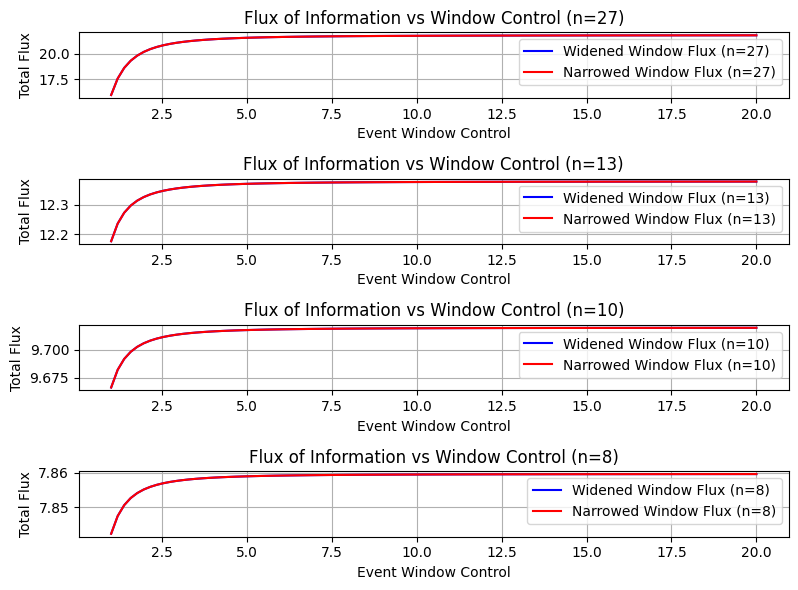

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma = 0.02  # Decay rate
n_steps = 100  # Number of steps for simulating the passage of time
initial_n_values = [27, 13, 10, 8]  # Initial n values for different event path lengths
N_max = 50  # Maximum path length in the future (for simulation)

# Create subplots for each operation on the event selection window
fig, axes = plt.subplots(len(initial_n_values), 1, figsize=(8, 6))

# Loop through each initial n value and plot the control operation effects
for i, n in enumerate(initial_n_values):
    # Initialize the event window and flux
    x_values = np.linspace(0, n * np.pi, n_steps)  # x-values from 0 to n*pi

    # Define the event window operations (narrowing or widening)
    widen_factor = np.linspace(1, 20, n_steps)  # Factor for widening window over time
    narrow_factor = np.linspace(20, 1, n_steps)  # Factor for narrowing window over time

    # Compute the total flux for both widening and narrowing window scenarios
    total_flux_widen = np.zeros(n_steps)
    total_flux_narrow = np.zeros(n_steps)

    # Loop to compute the flux for widening the window (adding more events)
    for step in range(n_steps):
        N_i = N_max * widen_factor[step]  # Increasing number of events in the window
        # Sum of decaying oscillations from the future
        total_flux_widen[step] = np.sum(np.exp(-gamma * x_values[:n]) * np.cos(np.pi * x_values[:n] / N_i))

    # Loop to compute the flux for narrowing the window (removing events)
    for step in range(n_steps):
        N_i = N_max * narrow_factor[step]  # Decreasing number of events in the window
        # Sum of decaying oscillations from the future
        total_flux_narrow[step] = np.sum(np.exp(-gamma * x_values[:n]) * np.cos(np.pi * x_values[:n] / N_i))

    # Plot the widening and narrowing flux operations
    axes[i].plot(widen_factor, total_flux_widen, label=f'Widened Window Flux (n={n})', color="blue")
    axes[i].plot(narrow_factor, total_flux_narrow, label=f'Narrowed Window Flux (n={n})', color="red")
    axes[i].set_title(f'Flux of Information vs Window Control (n={n})')
    axes[i].set_ylabel('Total Flux')
    axes[i].set_xlabel('Event Window Control')
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()  # Adjust subplots to fit within the figure area
plt.show()



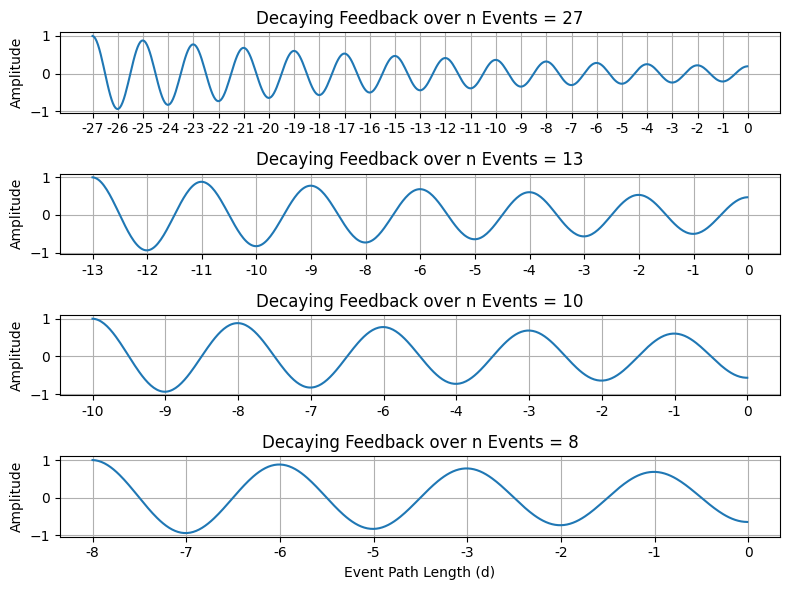

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma = 0.02  # Decay rate
n_values = [27, 13, 10, 8]  # Different values of n (number of full cosine cycles)

# Create subplots for each n value
fig, axes = plt.subplots(len(n_values), 1, figsize=(8, 6))

# Loop through each n value and plot on separate strip chart
for i, n in enumerate(n_values):
    d_values = np.linspace(0, n * np.pi, 500)  # d-values from 0 to n*pi

    # Calculate the decaying cosine wave using complex exponential
    decaying_cosine_wave = np.real(np.exp(1j * d_values)) * np.exp(-gamma * d_values)

    # Plot only the first (n-1) cycles
    axes[i].plot(d_values[:int((n-1)*500/n)], decaying_cosine_wave[:int((n-1)*500/n)])
    axes[i].set_title(f'Decaying Feedback over n Events = {n}')
    axes[i].set_ylabel('Amplitude')

    # Adjust the x-axis labels to reflect multiples of pi
    x_ticks = np.linspace(0, (n-1) * np.pi, n)  # x-ticks from 0 to (n-1)*pi
    x_labels = np.round(np.linspace(-n, 0, n)).astype(int)  # Labels as multiples of pi, rounded and converted to integers

    axes[i].set_xticks(x_ticks)  # Set the x-ticks
    axes[i].set_xticklabels([f'{int(label)}' for label in x_labels])  # Set the x-tick labels as integers

    axes[i].grid(True)

# Set x-axis label
plt.xlabel('Event Path Length (d)')
plt.tight_layout()  # Adjust subplots to fit within the figure area
plt.show()


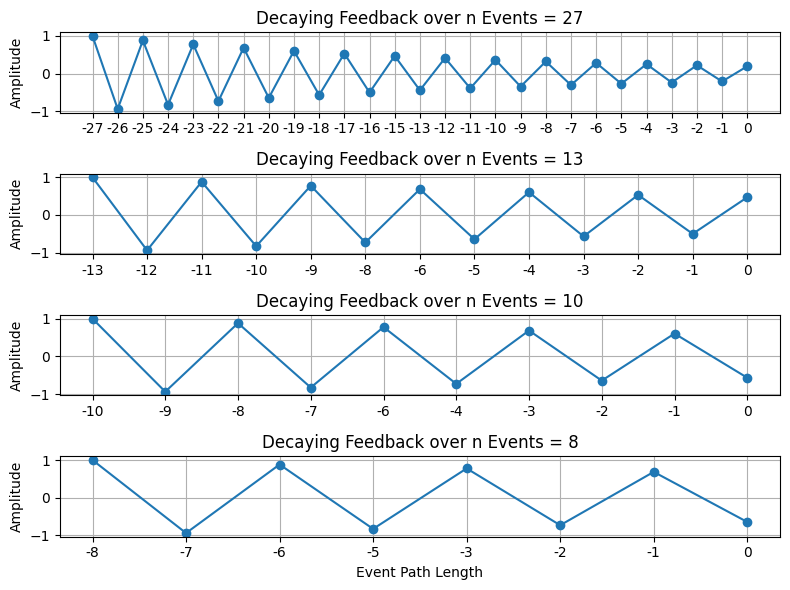

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma = 0.02  # Decay rate
n_values = [27, 13, 10, 8]  # Different values of n (number of full cosine cycles)

# Create subplots for each n value
fig, axes = plt.subplots(len(n_values), 1, figsize=(8, 6))

# Loop through each n value and plot on separate strip chart
for i, n in enumerate(n_values):
    # Create an array of length n, where each value corresponds to n*pi, i.e. multiples of pi
    d_values = np.linspace(0, (n-1) * np.pi, n)

    # Calculate the decaying oscillation for each path at the final value (no summation)
    decaying_cosine_wave = np.exp(-gamma * d_values) * np.cos(d_values)  # Decaying exponential with cosine oscillation

    # Plot the result as discrete values
    axes[i].plot(d_values, decaying_cosine_wave, marker='o', label=f'n={n}')
    axes[i].set_title(f'Decaying Feedback over n Events = {n}')
    axes[i].set_ylabel('Amplitude')

    # Adjust the x-axis labels to reflect multiples of pi
    x_ticks = np.linspace(0, (n-1) * np.pi, n)  # x-ticks from 0 to (n-1)*pi
    x_labels = np.round(np.linspace(-n, 0, n)).astype(int)  # Labels as multiples of pi, rounded and converted to integers

    axes[i].set_xticks(x_ticks)  # Set the x-ticks
    axes[i].set_xticklabels([f'{int(label)}' for label in x_labels])  # Set the x-tick labels as integers

    axes[i].grid(True)

# Set x-axis label
plt.xlabel('Event Path Length')
plt.tight_layout()  # Adjust subplots to fit within the figure area
plt.show()


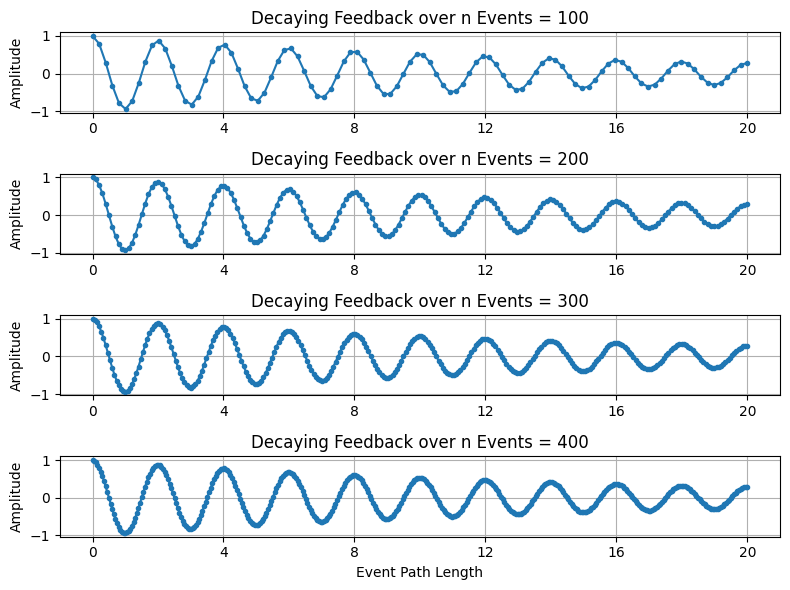

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma = 0.02  # Decay rate
n_values = [100, 200, 300, 400]  # Larger values of n (more cycles)
max_path_length = 20  # Larger path length for smoother oscillations

# Create subplots for each n value
fig, axes = plt.subplots(len(n_values), 1, figsize=(8, 6))

# Loop through each n value and plot on separate strip chart
for i, n in enumerate(n_values):
    # Create an array of length n, where each value corresponds to n*pi, i.e. multiples of pi
    d_values = np.linspace(0, max_path_length * np.pi, n)  # Increase path length for more steps

    # Calculate the decaying oscillation for each path at the final value (no summation)
    decaying_cosine_wave = np.exp(-gamma * d_values) * np.cos(d_values)  # Decaying exponential with cosine oscillation

    # Plot the result as discrete values
    axes[i].plot(d_values, decaying_cosine_wave, marker='o', markersize=3, label=f'n={n}')
    axes[i].set_title(f'Decaying Feedback over n Events = {n}')
    axes[i].set_ylabel('Amplitude')

    # Adjust the x-axis labels to reflect multiples of pi
    x_ticks = np.linspace(0, max_path_length * np.pi, 6)  # x-ticks from 0 to max_path_length*pi
    x_labels = np.round(np.linspace(0, max_path_length, 6)).astype(int)  # Labels as multiples of pi, rounded and converted to integers

    axes[i].set_xticks(x_ticks)  # Set the x-ticks
    axes[i].set_xticklabels([f'{int(label)}' for label in x_labels])  # Set the x-tick labels as integers

    axes[i].grid(True)

# Set x-axis label
plt.xlabel('Event Path Length')
plt.tight_layout()  # Adjust subplots to fit within the figure area
plt.show()


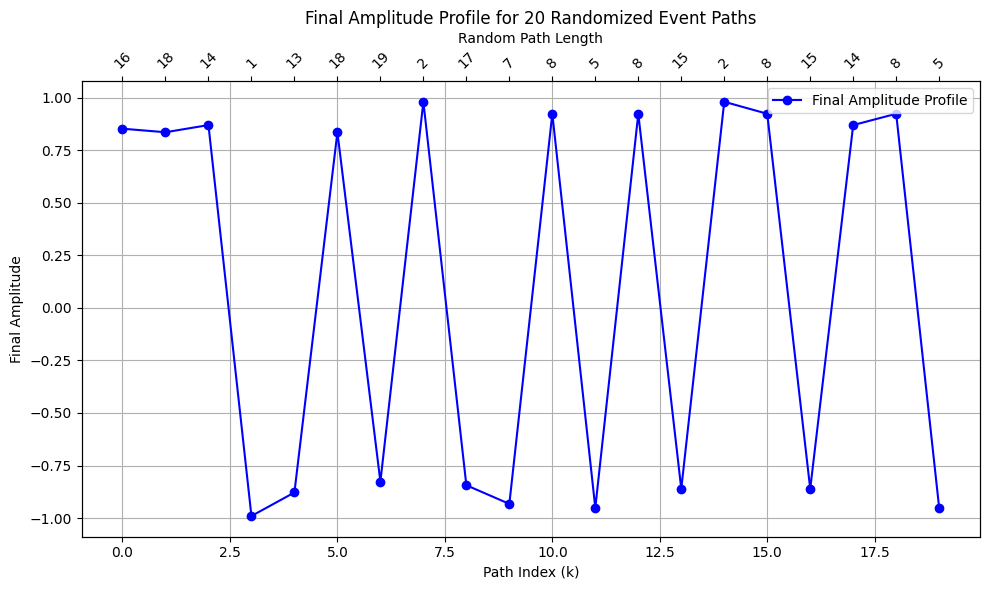

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma = 0.01  # Decay rate
k = 20  # Number of paths to generate

# Initialize lists to hold the final amplitude and the corresponding path lengths
final_amplitudes = []
path_lengths = []

# Loop over the k paths
for i in range(k):
    # Random path length for each path (between 1 and 100)
    n_k = np.random.randint(1, 20)
    # Calculate the oscillation for this path at the final value (no summation)
    final_amplitude = np.exp(-gamma * n_k) * np.cos(np.pi * n_k)
    # Store the final amplitude for this path and its path length
    final_amplitudes.append(final_amplitude)
    path_lengths.append(n_k)

# Plot the final amplitudes for each path
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(range(k), final_amplitudes, marker='o', color='b', label="Final Amplitude Profile")
ax1.set_title(f"Final Amplitude Profile for {k} Randomized Event Paths")
ax1.set_xlabel("Path Index (k)")
ax1.set_ylabel("Final Amplitude")
ax1.grid(True)
ax1.legend()

# Create a second x-axis to display the randomly selected path length for each path
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())  # Make sure both x-axes share the same range
ax2.set_xticks(range(k))
ax2.set_xticklabels(path_lengths)  # Show the path lengths at each point

# Rotate the labels on the top axis
ax2.set_xlabel("Random Path Length")
ax2.tick_params(axis='x', rotation=45)  # Rotate the labels by 45 degrees

plt.tight_layout()
plt.show()



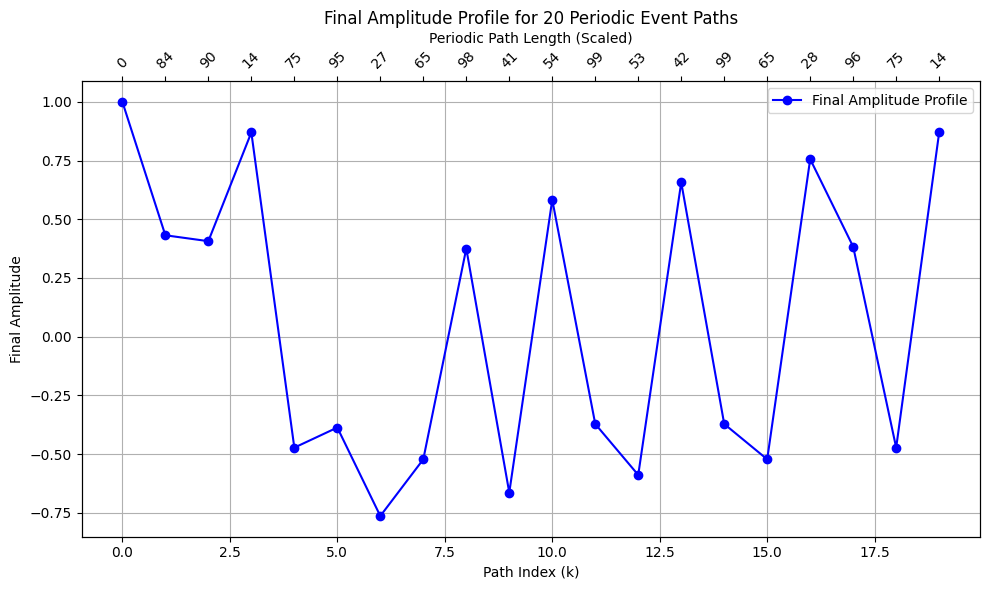

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma = 0.01  # Decay rate
k = 20  # Number of paths to generate
n_steps = 100  # Number of steps (discretized space)
n_values = np.arange(0, n_steps)  # Event index (n)
max_path_length = 100  # Maximum path length

# Initialize lists to hold the final amplitude and the corresponding path lengths
final_amplitudes = []
path_lengths = []

# Generate periodic path lengths
periodic_path_lengths = np.array([int(np.abs(np.sin(i) * max_path_length)) for i in range(k)])

# Loop over the k paths to simulate feedback at different periodic path lengths
for i in range(k):
    n_k = periodic_path_lengths[i]
    # Calculate the final amplitude for this path
    #final_amplitude = np.exp(-gamma * n_k) * np.cos(np.pi * n_k / n_k)  # The value at the final step
    final_amplitude = np.exp(-gamma * n_k) * np.cos(np.pi * n_k)  # The value at the final step
    final_amplitudes.append(final_amplitude)
    path_lengths.append(n_k)

# Plot the final amplitudes for each path
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(range(k), final_amplitudes, marker='o', color='b', label="Final Amplitude Profile")
ax1.set_title(f"Final Amplitude Profile for {k} Periodic Event Paths")
ax1.set_xlabel("Path Index (k)")
ax1.set_ylabel("Final Amplitude")
ax1.grid(True)
ax1.legend()

# Create a second x-axis to display the periodically selected path lengths for each path
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())  # Make sure both x-axes share the same range
ax2.set_xticks(range(k))
ax2.set_xticklabels(path_lengths)  # Show the path lengths at each point

# Rotate the labels on the top axis
ax2.set_xlabel("Periodic Path Length (Scaled)")
ax2.tick_params(axis='x', rotation=45)  # Rotate the labels by 45 degrees

plt.tight_layout()
plt.show()


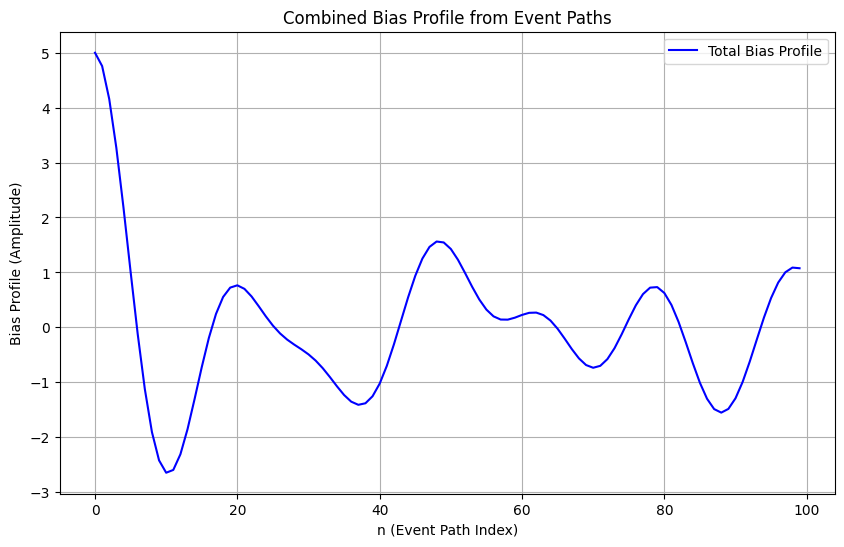

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma = 0.01  # Decay rate
n_steps = 100  # Number of steps (discretized space)
n_values = np.arange(0, n_steps)  # Event index (n)

# Number of event paths
k = 5

# Event path lengths (N_i for each event path)
N_values = [27, 13, 10, 8, 12]

# Calculate the bias profile (sum of oscillations)
bias_profile = np.zeros(n_steps)

for i in range(k):
    N_i = N_values[i]
    # Oscillation for each event path, with decay
    bias_profile += np.exp(-gamma * n_values) * np.cos(np.pi * n_values / N_i)

# Plot the resulting bias profile
plt.figure(figsize=(10, 6))
plt.plot(n_values, bias_profile, label="Total Bias Profile", color="blue")
plt.title("Combined Bias Profile from Event Paths")
plt.xlabel("n (Event Path Index)")
plt.ylabel("Bias Profile (Amplitude)")
plt.grid(True)
plt.legend()
plt.show()


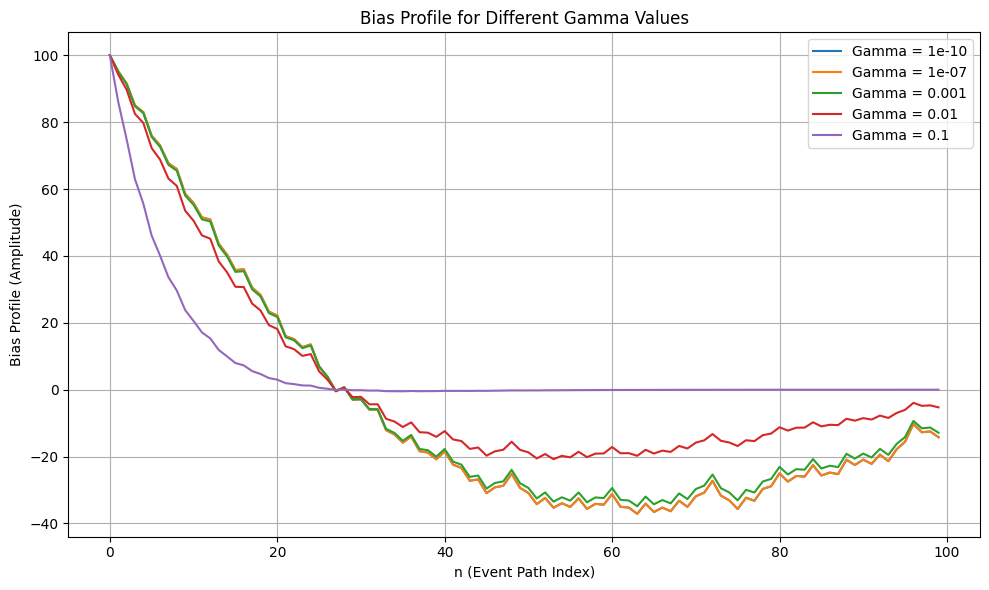

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_steps = 100  # Number of steps (discretized space)
n_values = np.arange(0, n_steps)  # Event index (n)
gamma_values = [1e-10, 1e-7, 0.001, 0.01, 0.1]  # Different decay rates
#gamma_values = [1e-20, 1e-7, 0.1]  # Different decay rates
max_N = 100  # Maximum path length for event paths

# Create a figure for the combined plot
plt.figure(figsize=(10, 6))

# Iterate over different gamma values
for gamma in gamma_values:
    # Initialize the bias profile
    bias_profile = np.zeros(n_steps)

    # Loop over the range of N (event path lengths)
    for N_i in range(1, max_N + 1):
        # Oscillation for each event path, with decay
        bias_profile += np.exp(-gamma * n_values) * np.cos(np.pi * n_values / N_i)

    # Plot the bias profile for this gamma value
    plt.plot(n_values, bias_profile, label=f"Gamma = {gamma}")

plt.title("Bias Profile for Different Gamma Values")
plt.xlabel("n (Event Path Index)")
plt.ylabel("Bias Profile (Amplitude)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


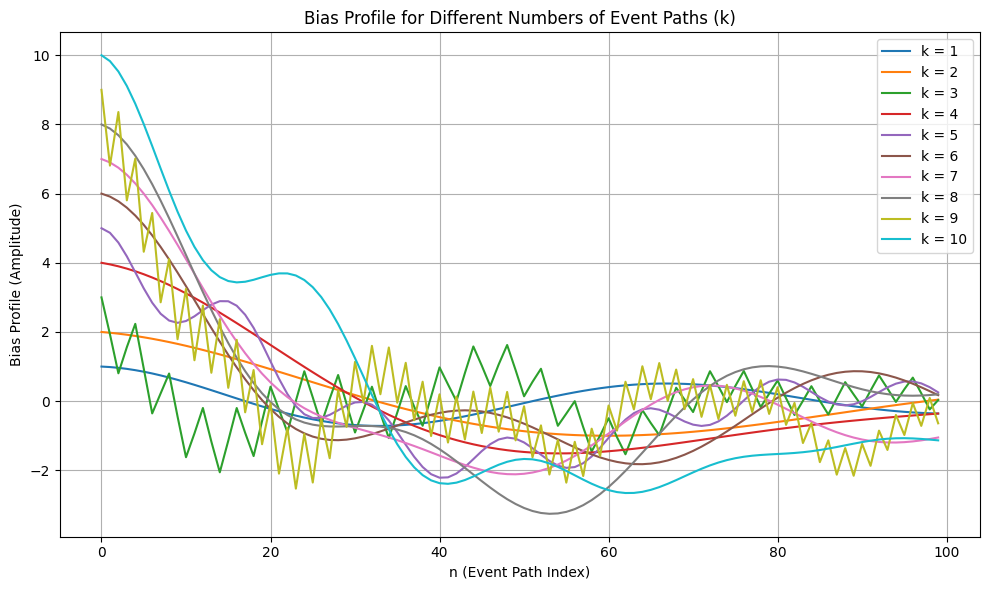

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_steps = 100  # Number of steps (discretized space)
n_values = np.arange(0, n_steps)  # Event index (n)
gamma_values = [0.001, 0.01, 0.1]  # Different decay rates
max_k = 10  # Maximum number of paths to sum over

# Create a plot for bias profile as a function of k
fig, ax = plt.subplots(figsize=(10, 6))

# Loop over different values of k (number of paths)
for k in range(1, max_k + 1):
    bias_profile = np.zeros(n_steps)

    # For each path, assign a random length n and calculate the bias
    for i in range(k):
        n_i = np.random.randint(1, n_steps)  # Random path length for each path
        bias_profile += np.exp(-gamma_values[1] * n_values) * np.cos(np.pi * n_values / n_i)

    ax.plot(n_values, bias_profile, label=f'k = {k}')

ax.set_title("Bias Profile for Different Numbers of Event Paths (k)")
ax.set_xlabel("n (Event Path Index)")
ax.set_ylabel("Bias Profile (Amplitude)")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


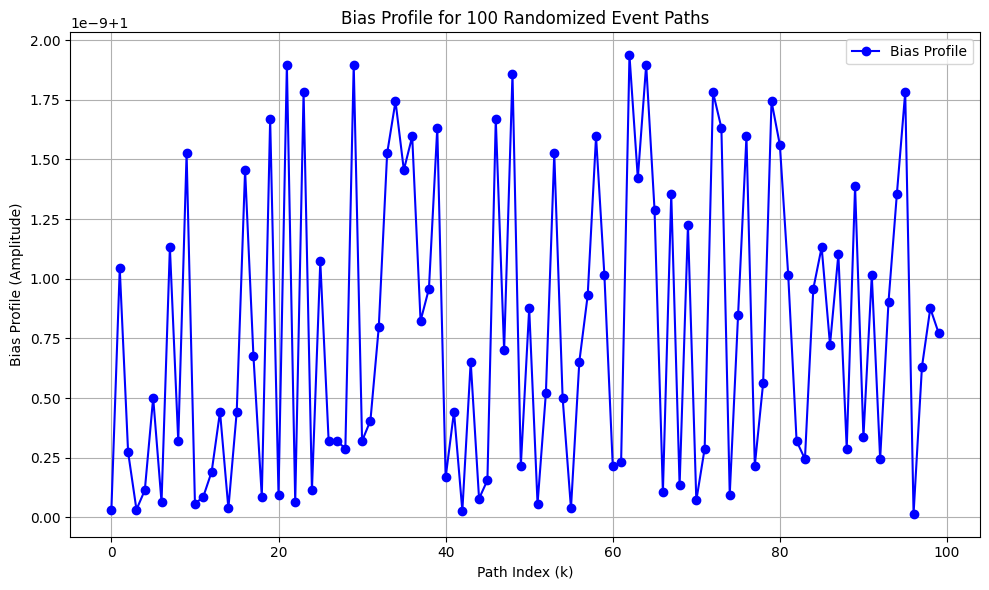

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_steps = 100  # Number of steps (discretized space)
gamma = 1e-12  # Decay rate
k = 100  # Number of paths to sum over (different path indices)

# Initialize a list to hold the bias values for each path
bias_values = []

# Loop over the k paths
for i in range(k):
    # Random path length for each path
    n_i = np.random.randint(10, n_steps)  # Random path length between 10 and n_steps
    # Calculate the oscillation for this particular path (sum over the path length)
    bias_value = np.sum(np.exp(-gamma * np.arange(n_i)) * np.cos(np.pi * np.arange(n_i) / n_i))
    # Store the total bias value for this path
    bias_values.append(bias_value)

# Plot the bias values for each path
plt.figure(figsize=(10, 6))

plt.plot(range(k), bias_values, marker='o', color='b', label="Bias Profile")
plt.title(f"Bias Profile for {k} Randomized Event Paths")
plt.xlabel("Path Index (k)")
plt.ylabel("Bias Profile (Amplitude)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


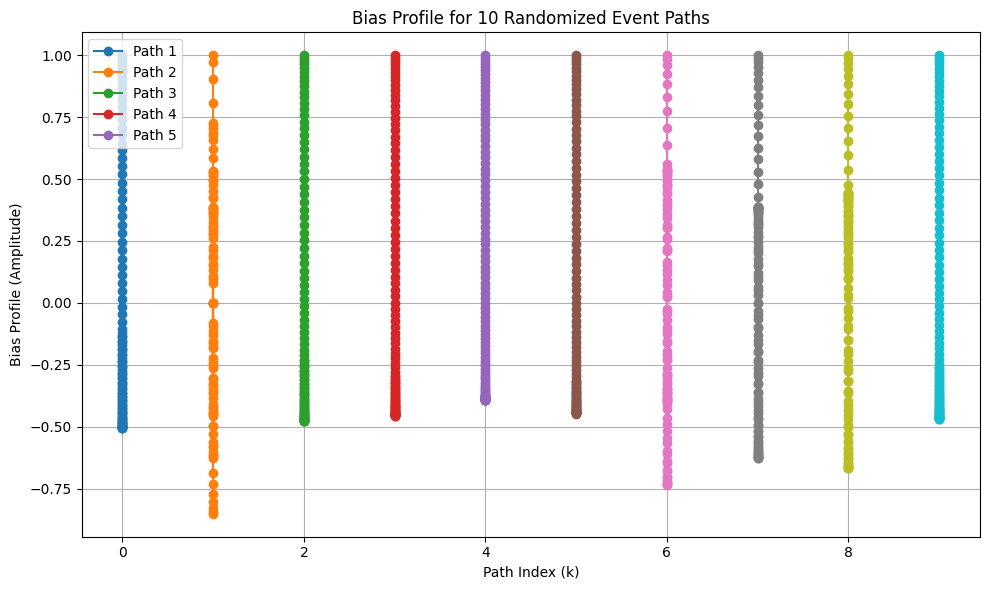

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_steps = 100  # Number of steps (discretized space)
gamma = 0.01  # Decay rate
k = 10  # Number of paths to sum over (different path indices)

# Initialize a list to hold the bias for each path
bias_profiles = []

# Loop over the k paths
for i in range(k):
    # Random path length for each path
    n_i = np.random.randint(10, n_steps)  # Random path length between 10 and n_steps
    # Calculate the oscillation for this particular path
    bias_profile = np.exp(-gamma * n_values) * np.cos(np.pi * n_values / n_i)
    # Store the bias profile for this path
    bias_profiles.append(bias_profile)

# Plot the bias profiles for each path
plt.figure(figsize=(10, 6))

for i in range(k):
    plt.plot(np.full_like(n_values, i), bias_profiles[i], label=f'Path {i+1}' if i < 5 else "", marker="o")  # Plot path index vs bias profile

plt.title(f"Bias Profile for {k} Randomized Event Paths")
plt.xlabel("Path Index (k)")
plt.ylabel("Bias Profile (Amplitude)")
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


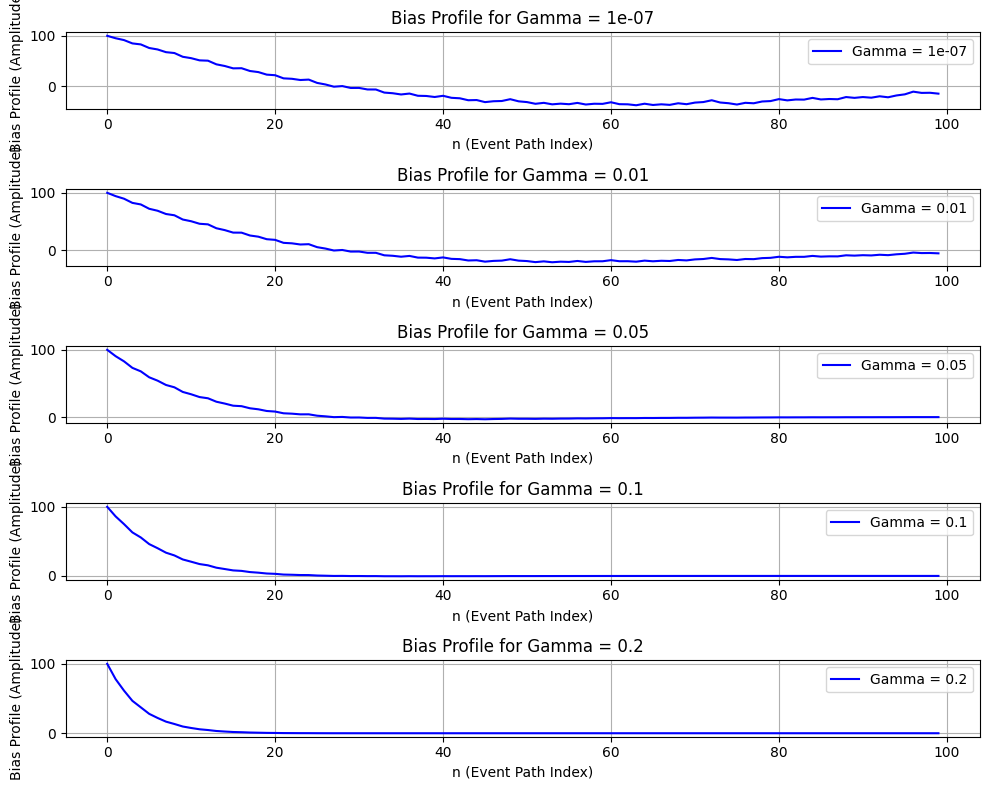

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_steps = 100  # Number of steps (discretized space)
n_values = np.arange(0, n_steps)  # Event index (n)
gamma_values = [0.0000001, 0.01, 0.05, 0.1, 0.2]  # Different decay rates
max_N = 100  # Maximum path length for event paths

# Create subplots for each gamma value
fig, axes = plt.subplots(len(gamma_values), 1, figsize=(10, 8))

# Iterate over different gamma values
for idx, gamma in enumerate(gamma_values):
    # Initialize the bias profile
    bias_profile = np.zeros(n_steps)

    # Loop over the range of N (event path lengths)
    for N_i in range(1, max_N + 1):
        # Oscillation for each event path, with decay
        bias_profile += np.exp(-gamma * n_values) * np.cos(np.pi * n_values / N_i)

    # Plot the bias profile for this gamma value
    axes[idx].plot(n_values, bias_profile, label=f"Gamma = {gamma}", color="blue")
    axes[idx].set_title(f"Bias Profile for Gamma = {gamma}")
    axes[idx].set_xlabel("n (Event Path Index)")
    axes[idx].set_ylabel("Bias Profile (Amplitude)")
    axes[idx].grid(True)
    axes[idx].legend()

plt.tight_layout()
plt.show()


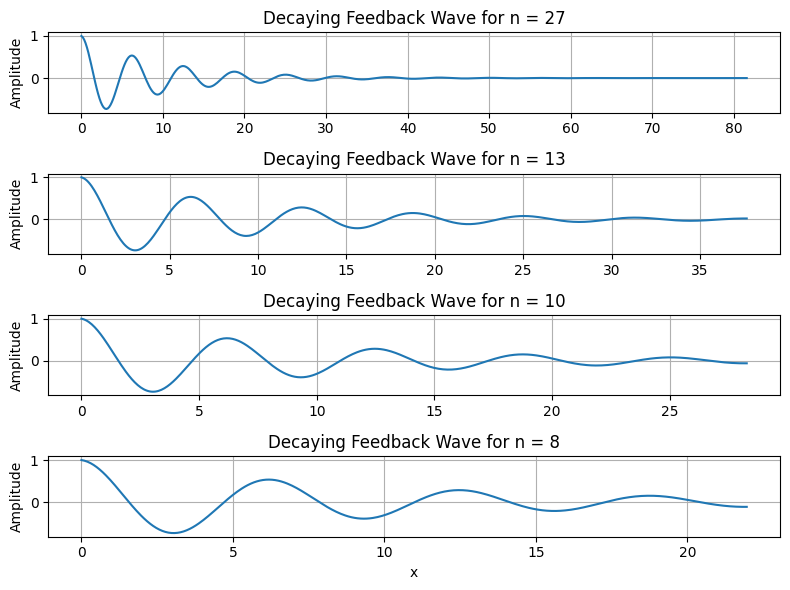

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma = 0.1  # Decay rate
n_values = [27, 13, 10, 8]  # Different values of n (number of full cosine cycles)

# Create subplots for each n value
fig, axes = plt.subplots(len(n_values), 1, figsize=(8, 6))

# Loop through each n value and plot on separate strip chart
for i, n in enumerate(n_values):
    x_values = np.linspace(0, n * np.pi, 500)  # x-values from 0 to n*pi

    # Calculate the decaying cosine wave using complex exponential
    decaying_cosine_wave = np.real(np.exp(1j * x_values)) * np.exp(-gamma * x_values)

    # Plot only the first (n-1) cycles
    axes[i].plot(x_values[:int((n-1)*500/n)], decaying_cosine_wave[:int((n-1)*500/n)])
    axes[i].set_title(f'Decaying Feedback Wave for n = {n}')
    axes[i].set_ylabel('Amplitude')
    axes[i].grid(True)

# Set x-axis label
plt.xlabel('x')
plt.tight_layout()  # Adjust subplots to fit within the figure area
plt.show()


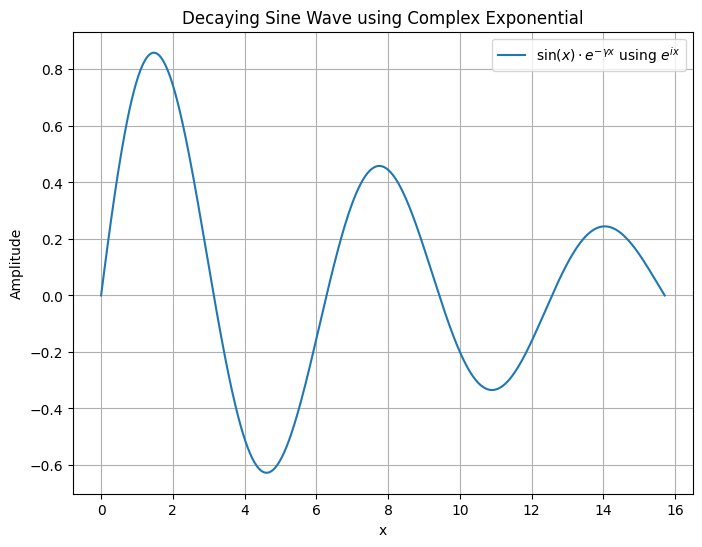

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n = 5  # Number of full sine wave cycles (e.g., 5*pi)
gamma = 0.1  # Decay rate
x_values = np.linspace(0, n * np.pi, 500)  # x-values from 0 to n*pi

# Using the complex exponential form of the sine wave with decay:
# sin(x) = Im(e^(ix)) and decay = e^(-gamma * x)
decaying_sine_wave = np.imag(np.exp(1j * x_values)) * np.exp(-gamma * x_values)

# Plot the decaying sine wave
plt.figure(figsize=(8, 6))
plt.plot(x_values, decaying_sine_wave, label=r'$\sin(x) \cdot e^{-\gamma x}$ using $e^{ix}$')
plt.title('Decaying Sine Wave using Complex Exponential')
plt.xlabel('x')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()


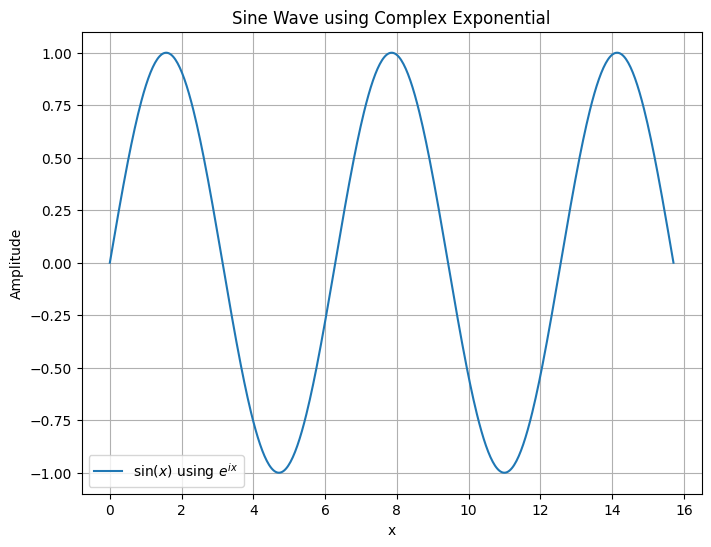

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n = 5  # Number of full sine wave cycles (e.g., 5*pi)
x_values = np.linspace(0, n * np.pi, 500)  # x-values from 0 to n*pi

# Using the complex exponential form of the sine wave: sin(x) = Im(e^(ix))
sine_wave = np.imag(np.exp(1j * x_values))

# Plot the sine wave
plt.figure(figsize=(8, 6))
plt.plot(x_values, sine_wave, label=r'$\sin(x)$ using $e^{ix}$')
plt.title('Sine Wave using Complex Exponential')
plt.xlabel('x')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()


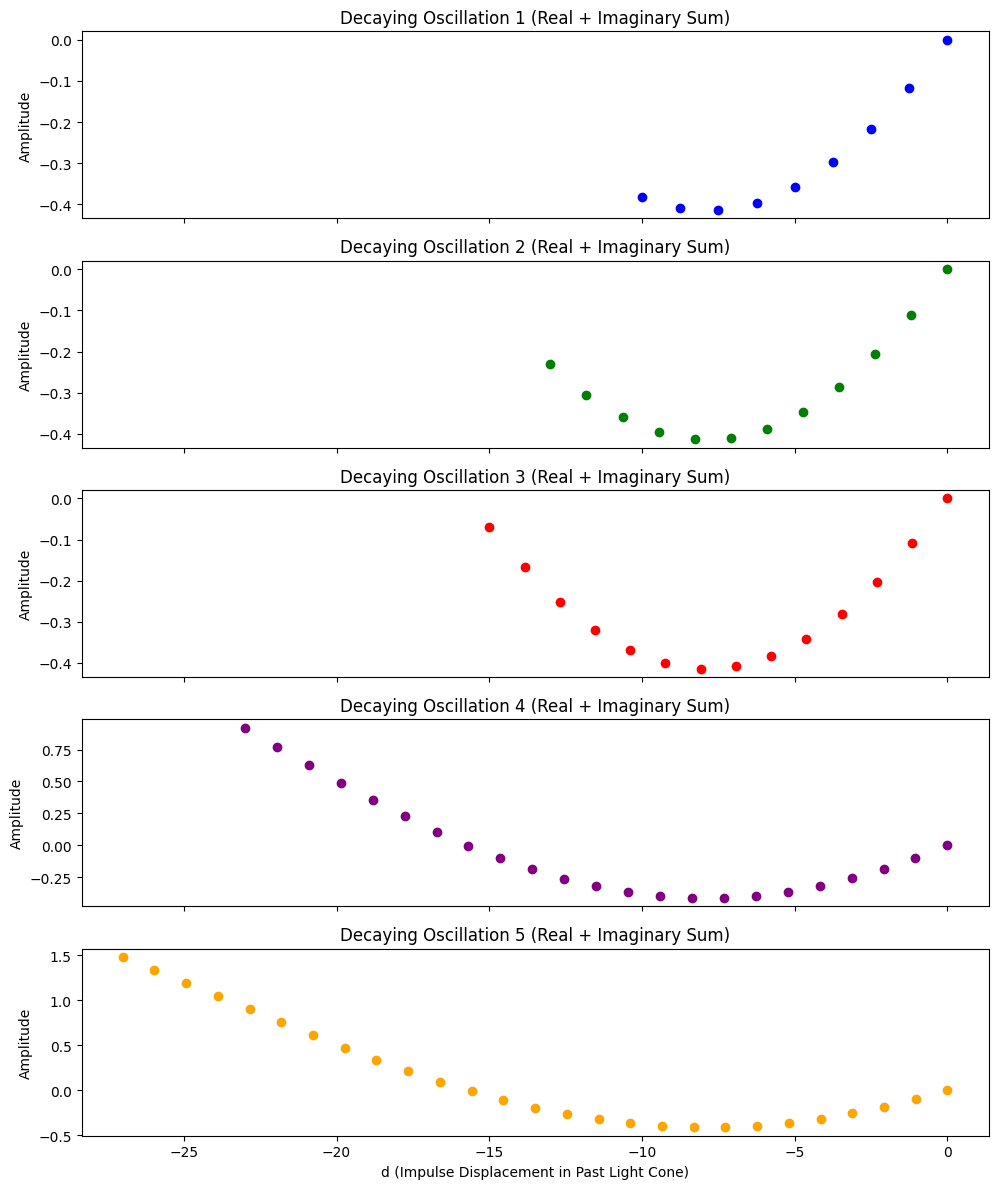

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma = 0.1  # Decay rate

# Define different d-values for each path (number of events varies per path)
d_values_1 = np.linspace(-10, 0, 9)  # Range of d values
d_values_2 = np.linspace(-13, 0, 12)  # Range of d values
d_values_3 = np.linspace(-15, 0, 14)  # Range of d values
d_values_4 = np.linspace(-23, 0, 23)  # Range of d values
d_values_5 = np.linspace(-27, 0, 27)  # Range of d values

# Calculate the decaying oscillation for different starting points (different phases and d ranges)
# Modified equation: 1 - e^(i * gamma * d)
decaying_oscillation_1 = 1 - np.exp(1j * gamma * -d_values_1)  # First oscillation
decaying_oscillation_2 = 1 - np.exp(1j * gamma * -d_values_2)  # Second oscillation
decaying_oscillation_3 = 1 - np.exp(1j * gamma * -d_values_3)  # Third oscillation
decaying_oscillation_4 = 1 - np.exp(1j * gamma * -d_values_4)  # Fourth oscillation
decaying_oscillation_5 = 1 - np.exp(1j * gamma * -d_values_5)  # Fifth oscillation

# Sum the real and imaginary parts to get the total oscillation
total_oscillation_1 = np.real(decaying_oscillation_1) + np.imag(decaying_oscillation_1)
total_oscillation_2 = np.real(decaying_oscillation_2) + np.imag(decaying_oscillation_2)
total_oscillation_3 = np.real(decaying_oscillation_3) + np.imag(decaying_oscillation_3)
total_oscillation_4 = np.real(decaying_oscillation_4) + np.imag(decaying_oscillation_4)
total_oscillation_5 = np.real(decaying_oscillation_5) + np.imag(decaying_oscillation_5)

# Create the plots
fig, axs = plt.subplots(5, 1, figsize=(10, 12), sharex=True)

# Plot each oscillation in a separate subplot
axs[0].scatter(d_values_1, total_oscillation_1, color='blue')
axs[0].set_title("Decaying Oscillation 1 (Real + Imaginary Sum)")
axs[0].set_ylabel("Amplitude")

axs[1].scatter(d_values_2, total_oscillation_2, color='green')
axs[1].set_title("Decaying Oscillation 2 (Real + Imaginary Sum)")
axs[1].set_ylabel("Amplitude")

axs[2].scatter(d_values_3, total_oscillation_3, color='red')
axs[2].set_title("Decaying Oscillation 3 (Real + Imaginary Sum)")
axs[2].set_ylabel("Amplitude")

axs[3].scatter(d_values_4, total_oscillation_4, color='purple')
axs[3].set_title("Decaying Oscillation 4 (Real + Imaginary Sum)")
axs[3].set_ylabel("Amplitude")

axs[4].scatter(d_values_5, total_oscillation_5, color='orange')
axs[4].set_title("Decaying Oscillation 5 (Real + Imaginary Sum)")
axs[4].set_xlabel("d (Impulse Displacement in Past Light Cone)")
axs[4].set_ylabel("Amplitude")

# Display the plot
plt.tight_layout()
plt.show()


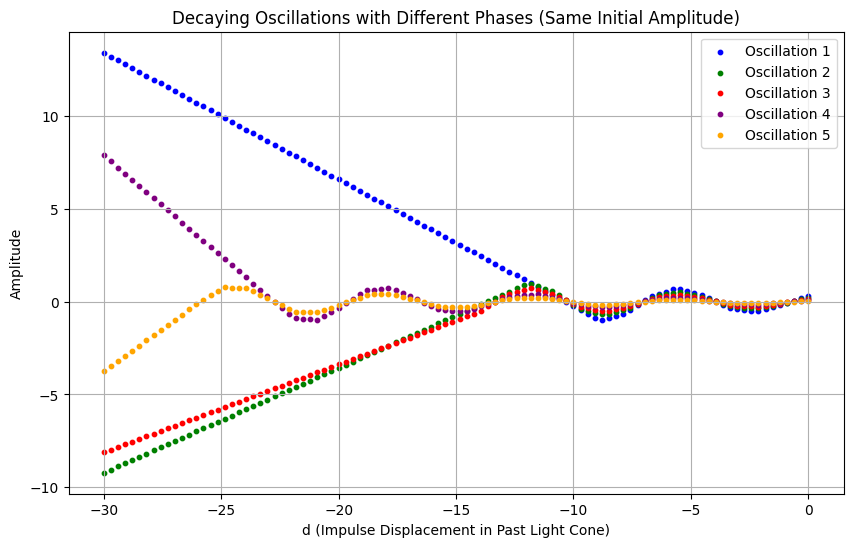

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Parameters
gamma = 0.1  # Decay rate

# Define different d-values for each path (number of events varies per path)
d_values_1 = np.linspace(-10, 0, 10)  # Range of d values
d_values_2 = np.linspace(-13, 0, 13)  # Range of d values
d_values_3 = np.linspace(-15, 0, 15)  # Range of d values
d_values_4 = np.linspace(-23, 0, 23)  # Range of d values
d_values_5 = np.linspace(-27, 0, 27)  # Range of d values

# Calculate the decaying oscillation for different starting points (different phases and d ranges)
decaying_oscillation_1 = np.exp(1j * 1 * d_values_1 - gamma * d_values_1)  # First oscillation
decaying_oscillation_2 = np.exp(1j * 1 * d_values_2 - gamma * d_values_2)  # Second oscillation
decaying_oscillation_3 = np.exp(1j * 1 * d_values_3 - gamma * d_values_3)  # Third oscillation
decaying_oscillation_4 = np.exp(1j * 1 * d_values_4 - gamma * d_values_4)  # Fourth oscillation
decaying_oscillation_5 = np.exp(1j * 1 * d_values_5 - gamma * d_values_5)  # Fifth oscillation

# Sum the real and imaginary parts to get the total oscillation
total_oscillation_1 = np.real(decaying_oscillation_1) + np.imag(decaying_oscillation_1)
total_oscillation_2 = np.real(decaying_oscillation_2) + np.imag(decaying_oscillation_2)
total_oscillation_3 = np.real(decaying_oscillation_3) + np.imag(decaying_oscillation_3)
total_oscillation_4 = np.real(decaying_oscillation_4) + np.imag(decaying_oscillation_4)
total_oscillation_5 = np.real(decaying_oscillation_5) + np.imag(decaying_oscillation_5)

# Normalize each oscillation to start with amplitude 1
total_oscillation_1 /= np.max(np.abs(total_oscillation_1))
total_oscillation_2 /= np.max(np.abs(total_oscillation_2))
total_oscillation_3 /= np.max(np.abs(total_oscillation_3))
total_oscillation_4 /= np.max(np.abs(total_oscillation_4))
total_oscillation_5 /= np.max(np.abs(total_oscillation_5))

# Re-scale the total oscillations to match the longest sequence of events
common_d = np.linspace(-30, 0, 100)

# Interpolate each oscillation to a common d range for comparison
interp_oscillation_1 = interp1d(d_values_1, total_oscillation_1, kind='linear', fill_value="extrapolate")
interp_oscillation_2 = interp1d(d_values_2, total_oscillation_2, kind='linear', fill_value="extrapolate")
interp_oscillation_3 = interp1d(d_values_3, total_oscillation_3, kind='linear', fill_value="extrapolate")
interp_oscillation_4 = interp1d(d_values_4, total_oscillation_4, kind='linear', fill_value="extrapolate")
interp_oscillation_5 = interp1d(d_values_5, total_oscillation_5, kind='linear', fill_value="extrapolate")

# Generate interpolated oscillations for common d
total_oscillation_1_common = interp_oscillation_1(common_d)
total_oscillation_2_common = interp_oscillation_2(common_d)
total_oscillation_3_common = interp_oscillation_3(common_d)
total_oscillation_4_common = interp_oscillation_4(common_d)
total_oscillation_5_common = interp_oscillation_5(common_d)

# Plot the total oscillation as scatter plot
plt.figure(figsize=(10, 6))

plt.scatter(common_d, total_oscillation_1_common, label="Oscillation 1", color="blue", s=10)
plt.scatter(common_d, total_oscillation_2_common, label="Oscillation 2", color="green", s=10)
plt.scatter(common_d, total_oscillation_3_common, label="Oscillation 3", color="red", s=10)
plt.scatter(common_d, total_oscillation_4_common, label="Oscillation 4", color="purple", s=10)
plt.scatter(common_d, total_oscillation_5_common, label="Oscillation 5", color="orange", s=10)

plt.title("Decaying Oscillations with Different Phases (Same Initial Amplitude)")
plt.xlabel("d (Impulse Displacement in Past Light Cone)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


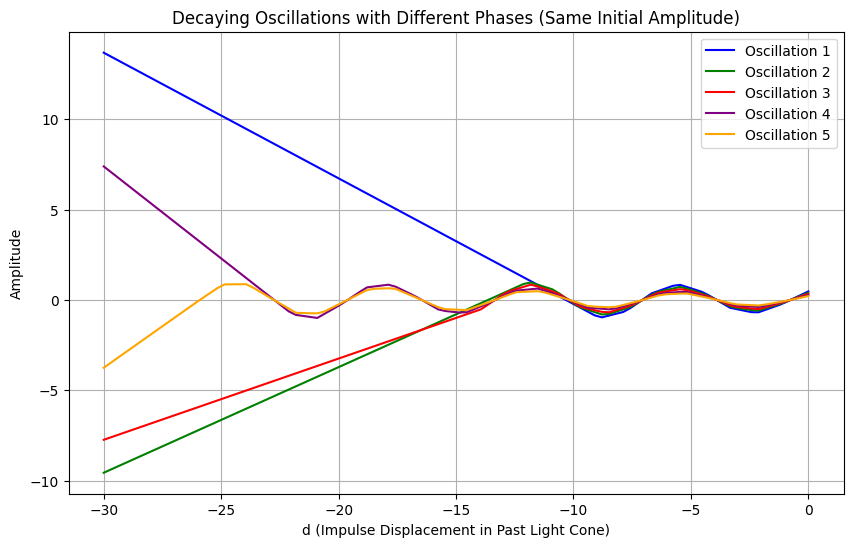

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma = 0.05  # Decay rate

# Define different d-values for each path (number of events varies per path)
d_values_1 = np.linspace(-10, 0, 10)  # Range of d values
d_values_2 = np.linspace(-13, 0, 13)  # Range of d values
d_values_3 = np.linspace(-15, 0, 15)  # Range of d values
d_values_4 = np.linspace(-23, 0, 23)  # Range of d values
d_values_5 = np.linspace(-27, 0, 27)  # Range of d values

# Calculate the decaying oscillation for different starting points (different phases and d ranges)
decaying_oscillation_1 = np.exp(1j * 1 * d_values_1 - gamma * d_values_1)  # First oscillation
decaying_oscillation_2 = np.exp(1j * 1 * d_values_2 - gamma * d_values_2)  # Second oscillation
decaying_oscillation_3 = np.exp(1j * 1 * d_values_3 - gamma * d_values_3)  # Third oscillation
decaying_oscillation_4 = np.exp(1j * 1 * d_values_4 - gamma * d_values_4)  # Fourth oscillation
decaying_oscillation_5 = np.exp(1j * 1 * d_values_5 - gamma * d_values_5)  # Fifth oscillation

# Sum the real and imaginary parts to get the total oscillation
total_oscillation_1 = np.real(decaying_oscillation_1) + np.imag(decaying_oscillation_1)
total_oscillation_2 = np.real(decaying_oscillation_2) + np.imag(decaying_oscillation_2)
total_oscillation_3 = np.real(decaying_oscillation_3) + np.imag(decaying_oscillation_3)
total_oscillation_4 = np.real(decaying_oscillation_4) + np.imag(decaying_oscillation_4)
total_oscillation_5 = np.real(decaying_oscillation_5) + np.imag(decaying_oscillation_5)

# Normalize each oscillation to start with amplitude 1
total_oscillation_1 /= np.max(np.abs(total_oscillation_1))
total_oscillation_2 /= np.max(np.abs(total_oscillation_2))
total_oscillation_3 /= np.max(np.abs(total_oscillation_3))
total_oscillation_4 /= np.max(np.abs(total_oscillation_4))
total_oscillation_5 /= np.max(np.abs(total_oscillation_5))

# Re-scale the total oscillations to match the longest sequence of events
common_d = np.linspace(-30, 0, 100)

# Interpolate each oscillation to a common d range for comparison
from scipy.interpolate import interp1d

interp_oscillation_1 = interp1d(d_values_1, total_oscillation_1, kind='linear', fill_value="extrapolate")
interp_oscillation_2 = interp1d(d_values_2, total_oscillation_2, kind='linear', fill_value="extrapolate")
interp_oscillation_3 = interp1d(d_values_3, total_oscillation_3, kind='linear', fill_value="extrapolate")
interp_oscillation_4 = interp1d(d_values_4, total_oscillation_4, kind='linear', fill_value="extrapolate")
interp_oscillation_5 = interp1d(d_values_5, total_oscillation_5, kind='linear', fill_value="extrapolate")

# Generate interpolated oscillations for common d
total_oscillation_1_common = interp_oscillation_1(common_d)
total_oscillation_2_common = interp_oscillation_2(common_d)
total_oscillation_3_common = interp_oscillation_3(common_d)
total_oscillation_4_common = interp_oscillation_4(common_d)
total_oscillation_5_common = interp_oscillation_5(common_d)

# Plot the total oscillation
plt.figure(figsize=(10, 6))

plt.plot(common_d, total_oscillation_1_common, label="Oscillation 1", color="blue")
plt.plot(common_d, total_oscillation_2_common, label="Oscillation 2", color="green")
plt.plot(common_d, total_oscillation_3_common, label="Oscillation 3", color="red")
plt.plot(common_d, total_oscillation_4_common, label="Oscillation 4", color="purple")
plt.plot(common_d, total_oscillation_5_common, label="Oscillation 5", color="orange")

plt.title("Decaying Oscillations with Different Phases (Same Initial Amplitude)")
plt.xlabel("d (Impulse Displacement in Past Light Cone)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


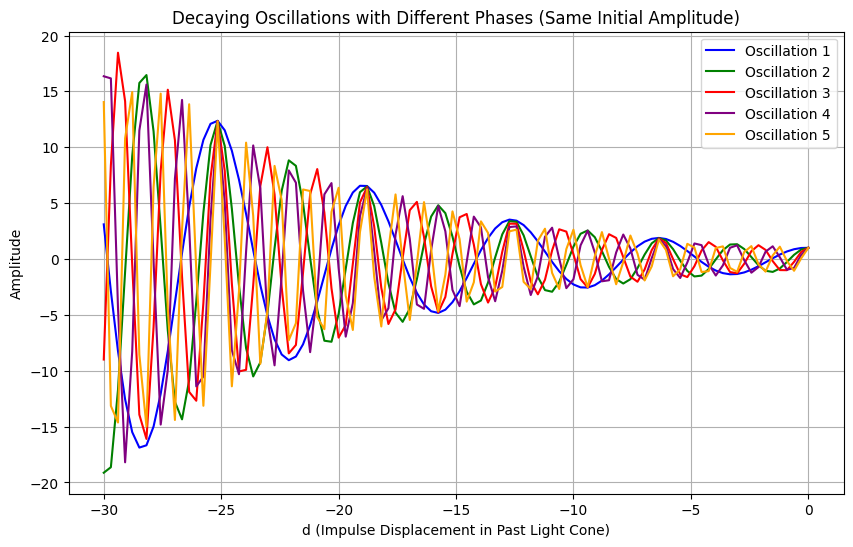

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma = 0.1  # Decay rate
common_d = np.linspace(-30, 0, 100)  # Common range for d (to compare all oscillations)

# Calculate the decaying oscillation for different starting points (different phases and d ranges)
decaying_oscillation_1 = np.exp(1j * 1 * common_d - gamma * common_d)  # First oscillation
decaying_oscillation_2 = np.exp(1j * 2 * common_d - gamma * common_d)  # Second oscillation
decaying_oscillation_3 = np.exp(1j * 3 * common_d - gamma * common_d)  # Third oscillation
decaying_oscillation_4 = np.exp(1j * 4 * common_d - gamma * common_d)  # Fourth oscillation
decaying_oscillation_5 = np.exp(1j * 5 * common_d - gamma * common_d)  # Fifth oscillation

# Sum the real parts to get the total oscillation (ignoring the imaginary part)
total_oscillation_1 = np.real(decaying_oscillation_1)
total_oscillation_2 = np.real(decaying_oscillation_2)
total_oscillation_3 = np.real(decaying_oscillation_3)
total_oscillation_4 = np.real(decaying_oscillation_4)
total_oscillation_5 = np.real(decaying_oscillation_5)

# Plot the total oscillation
plt.figure(figsize=(10, 6))

plt.plot(common_d, total_oscillation_1, label="Oscillation 1", color="blue")
plt.plot(common_d, total_oscillation_2, label="Oscillation 2", color="green")
plt.plot(common_d, total_oscillation_3, label="Oscillation 3", color="red")
plt.plot(common_d, total_oscillation_4, label="Oscillation 4", color="purple")
plt.plot(common_d, total_oscillation_5, label="Oscillation 5", color="orange")

plt.title("Decaying Oscillations with Different Phases (Same Initial Amplitude)")
plt.xlabel("d (Impulse Displacement in Past Light Cone)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


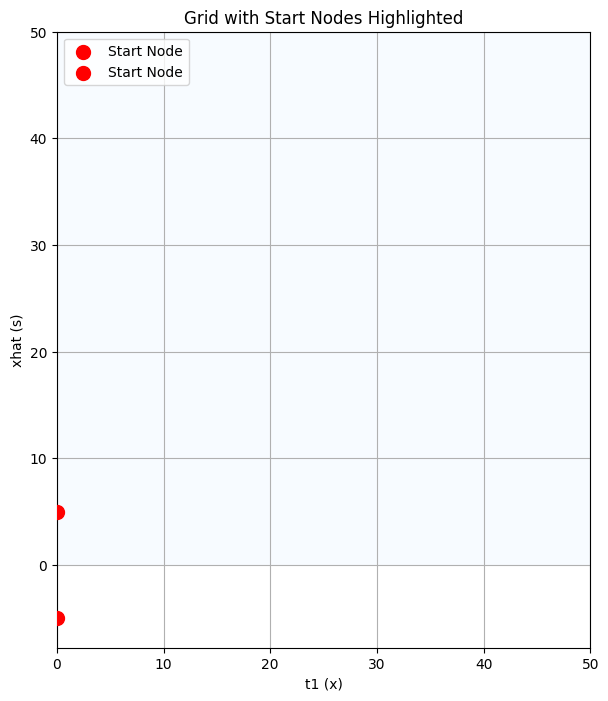

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to construct the grid
def construct_grid(grid_size):
    grid = np.zeros((grid_size, grid_size), dtype=object)
    for i in range(grid_size):
        for j in range(grid_size):
            grid[i, j] = {
                'coord': (i, j),  # Coordinates (unique ID for each node)
                'I1_info': 0,  # Information from I1 (causal)
                'I2_info': 0,  # Information from I2 (non-local)
                'total_info': 1.0  # Initialize total information to a small value (1.0)
            }
    return grid

# Function to map grid indices to visual coordinates
def grid_to_visual_coordinates(i, j, grid_size):
    # Map i to x (t1) and j to y (s)
    x = i
    y = grid_size / 2 - j
    return x, y

# Function to plot the grid and highlight the start nodes
def plot_grid_with_start_nodes(grid, start_nodes, grid_size):
    """
    Plots the existing grid with start nodes highlighted.

    Parameters:
    - grid (2D numpy array): The existing grid with node data.
    - start_nodes (list of tuples): List of start nodes' coordinates.
    - grid_size (int): The size of the grid (NxN).
    """
    # Create a blank grid for plotting
    grid_plot = np.zeros((grid_size, grid_size))

    # Populate the grid plot with the total information for each node
    for i in range(grid_size):
        for j in range(grid_size):
            grid_plot[i, j] = grid[i, j]['total_info']

    # Plot the grid
    plt.figure(figsize=(8, 8))
    plt.imshow(grid_plot, cmap='Blues', extent=[0, grid_size, 0, grid_size], interpolation='nearest')

    # Highlight the start nodes in red
    for node in start_nodes:
        x, y = grid_to_visual_coordinates(node[0], node[1], grid_size)
        plt.scatter(x, y, color='red', label="Start Node", s=100, zorder=5)

    # Add labels and titles
    plt.title("Grid with Start Nodes Highlighted")
    plt.xlabel("t1 (x)")
    plt.ylabel("xhat (s)")
    plt.grid(True)

    # Add a legend
    plt.legend(loc='upper left')

    # Show the plot
    plt.show()

# Example usage:
grid_size = 50  # Set the grid size
# Example start nodes (initial positions on the grid)
start_node_1 = (0, grid_size // 2 - 5)  # Node 1 at t=0, slightly below center
start_node_2 = (0, grid_size // 2 + 5)  # Node 2 at t=0, slightly above center
start_nodes = [start_node_1, start_node_2]

# Construct the grid with the defined size
grid = construct_grid(grid_size)

# Plot the grid with the start nodes highlighted
plot_grid_with_start_nodes(grid, start_nodes, grid_size)
